In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import RMSprop
from grid_cells import GridCells
from utils import get_coords, to_tensor, get_loc_batch
from agent import Agent
from tqdm import tqdm

In [2]:
def eval_position(agent, size=4096):
    losses = list()
    for _ in range(size // 256):
        x, y = get_loc_batch(c, gc, bs=256)
        x = agent.actor(x)[1]
        loss = torch.sum((x - y)**2).detach().cpu().numpy()
        losses.append(loss)
    return np.mean(losses)

def print_stats(w):
    print("min   |max  |mean |std  |shape")
    print(f"{w.min():.03f}|{w.max():.03f}|{w.mean():.03f}|{w.std():.03f}|{w.shape}")

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 100
scales = np.linspace(90, 300, 10, dtype=int)

coords = get_coords(resolution, MIN, MAX)
gcs = GridCells(scales, n_per_module=N, res=resolution)
gcs.reset_modules(1)
gcs.compile_numpy()
grid_cells = gcs.grid_cells.transpose(1, 2, 0)
c, gc = to_tensor(coords), to_tensor(grid_cells)

In [4]:
import torch
import torch.nn as nn
import numpy as np

from utils import ReplayBuffer, device
from torch.optim import Adam, RMSprop


class Critic(nn.Module):
    def __init__(self, inp_size, hidden=256):
        super().__init__()
        self.lin1 = nn.Linear(inp_size, hidden)
        self.lin2 = nn.Linear(hidden, 1)
    
    def forward(self, state, action):
        x = torch.concat([state, action], dim=-1)
        x = nn.functional.relu(self.lin1(x))
        return self.lin2(x)

    
class Actor(nn.Module):
    def __init__(self, inp_size, actions, bounds, hidden=128, action_amp=1):
        super().__init__()
        self.w1 = nn.parameter.Parameter(torch.Tensor(hidden, inp_size).exponential_(lambd=1))
        self.b1 = nn.parameter.Parameter(torch.zeros(hidden))
        # self.lin1 = nn.Linear(inp_size, hidden)
        self.norm = nn.LayerNorm(hidden)
        self.lin2 = nn.Linear(hidden, 2 * actions)
        self.actions = actions
        self.bounds = bounds
        self.position_amp = np.diff(self.bounds).item()
        self.action_amp = action_amp
    
    def forward(self, state):
        h = self.lin1(state)
        # h = nn.functional.sigmoid(self.lin1(state))
        x = self.lin2(h).view(-1, 2 * self.actions)
        actions, positions = x[:,:self.actions], x[:,self.actions:]
        
        actions = nn.functional.tanh(actions) * self.action_amp
        positions = nn.functional.sigmoid(positions)
        positions = positions * self.position_amp + self.bounds[0]
        
        return actions.squeeze(), positions.squeeze(), h
    
    def clamp_weights(self):
        self.w1.data = self.w1.data.clamp(0)

    def lin1(self, x):
        return nn.functional.sigmoid(self.norm(nn.functional.linear(x, self.w1, self.b1)))
    
    # @staticmethod
    # def transform_weights(weights):
    #     return torch.pow(weights, 2)

    # A separate method for this allows combining different
    # regularization terms for different parts of the network
    def normalization_loss(self, l1, l2):
        loss = torch.pow(self.w1, 2).sum() * l2
        loss += self.w1.abs().sum() * l1
        # loss += self.lin1.bias.abs().sum()
        loss += torch.pow(self.lin2.weight, 2).sum() * l2
        # loss += self.lin2.weight.abs().sum() * l1
        # loss += torch.pow(self.lin2.bias, 2).sum()
        return loss


class Agent:
    def __init__(self, inp_size, actions,
                 bounds=(-1, 1),
                 action_amp=1,
                 exploration_std=0.1,
                 bs=64,
                 tau=0.005,
                 buffer_length=1000,
                 actor_hidden=128,
                 critic_hidden=256,
                 lr_a=1e-4, wd_a=1e-5,
                 lr_c=3e-4, wd_c=1e-5,
                 grad_norm=0.1):
        self.bs = bs
        self.tau = tau
        self.amp = action_amp
        self.exploration_std = exploration_std
        self.grad_norm = grad_norm
        
        self.buffer = ReplayBuffer(inp_size, actions, maxlen=buffer_length)
        
        self.actor = Actor(inp_size, actions, bounds=bounds, action_amp=action_amp, hidden=actor_hidden).to(device)
        self.target_actor = Actor(inp_size, actions, bounds=bounds, action_amp=action_amp, hidden=actor_hidden).to(device)
        self.critic = Critic(inp_size + actions, hidden=critic_hidden).to(device)
        self.target_critic = Critic(inp_size + actions, hidden=critic_hidden).to(device)
        self.update_target_networks(tau=1)
        
        self.optim_critic = RMSprop([p for p in self.critic.parameters()], lr=lr_c, weight_decay=wd_c)
        self.optim_actor = RMSprop([p for p in self.actor.parameters()], lr=lr_a, weight_decay=wd_a)
        self.critic_criterion = nn.MSELoss()
    
    def update_target_networks(self, tau=None):
        if tau is None:
            tau = self.tau
        for name in ['actor', 'critic']:
            self.polyak_update(tau, getattr(self, name), getattr(self, f"target_{name}"))
    
    @staticmethod
    def polyak_update(tau, net, tnet):
        for p, tp in zip(net.parameters(), tnet.parameters()):
            tp.data.copy_(tau * p.data + tp.data * (1 - tau))
    
    def remember(self, state, action, reward, new_state, done, loc=None):
        self.buffer.store_transition(state, action, reward, new_state, done, loc)
    
    def choose_action(self, state, evaluate=False, numpy=False):
        action = self.actor(state)[0].detach()
        if not evaluate:
            action += torch.randn(*action.shape, device=device) * self.exploration_std
            action = torch.clip(action, -self.amp, self.amp)
        return action.detach().cpu().numpy() if numpy else action
    
    def learn(self):
        if self.buffer.counter < self.bs:
            return
        
        states, actions, rewards, next_states, dones, locs = self.buffer.sample(self.bs)
        
        self.optim_critic.zero_grad(set_to_none=True)
        target_actions, _ = self.target_actor(next_states)
        q_next = self.target_critic(next_states, target_actions)
        q = self.critic(states, actions)
        targets = rewards + torch.squeeze(q_next) * (1 - dones)
        loss_critic = self.critic_criterion(q, targets.view(-1, 1))
        loss_critic.backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_norm)
        self.optim_critic.step()
        
        self.optim_actor.zero_grad(set_to_none=True)
        actions_, positions = self.actor(states)
        loss_actor = -self.critic(states, actions_)
        loss_actor = torch.mean(loss_actor)
        # dists = positions - locs
        # loss_actor += torch.sum(dists * dists, dim=-1).mean()
        loss_actor.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_norm)
        self.optim_actor.step()
        
        self.update_target_networks()

In [5]:
hidden = 500
wd_l1 = 1e-5
wd_l2 = 1e-7
agent = Agent(grid_cells.shape[-1], 2, actor_hidden=hidden, lr_a=1e-4)
net = agent.actor
optim = RMSprop([p for p in net.parameters()], lr=3e-4)

In [6]:
losses = list()
for _ in tqdm(range(50000)):
    optim.zero_grad()
    net.clamp_weights()
    x, y = get_loc_batch(c, gc, bs=256)
    _, pred, h = net(x)
    loss = torch.sum((pred - y)**2, dim=-1).mean()
    loss += torch.sum(h, dim=-1).mean() / 50
    loss += net.normalization_loss(wd_l1, wd_l2)
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [19:21<00:00, 43.04it/s]


In [7]:
net.normalization_loss(wd_l1, wd_l2)

tensor(0.0208, device='cuda:0', grad_fn=<AddBackward0>)

In [8]:
print_stats(net.b1)

min   |max  |mean |std  |shape
-3.111|6.263|1.930|2.803|torch.Size([500])


In [9]:
net.clamp_weights()

In [10]:
print_stats(net.w1.sum(1))

min   |max  |mean |std  |shape
0.172|24.775|3.990|6.273|torch.Size([500])


In [11]:
print_stats(net.w1)

min   |max  |mean |std  |shape
0.000|5.141|0.004|0.064|torch.Size([500, 1000])


Position loss: 0.837


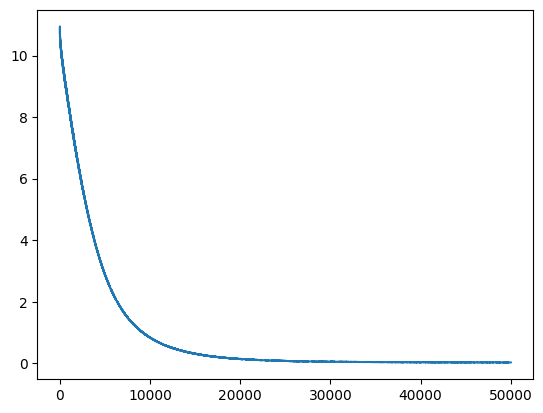

In [12]:
print(f"Position loss: {eval_position(agent):.03f}")
plt.plot(losses)
plt.show()

In [13]:
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:].numpy() + [[0], [hidden]]
print(net.lin2.weight[2:].detach().cpu().flatten()[idx.flatten()])

tensor([ 6.7251, -6.7507, -7.0654,  7.1097,  7.3213,  7.0781,  7.1428,  7.2367,
        -7.9510,  7.9923])


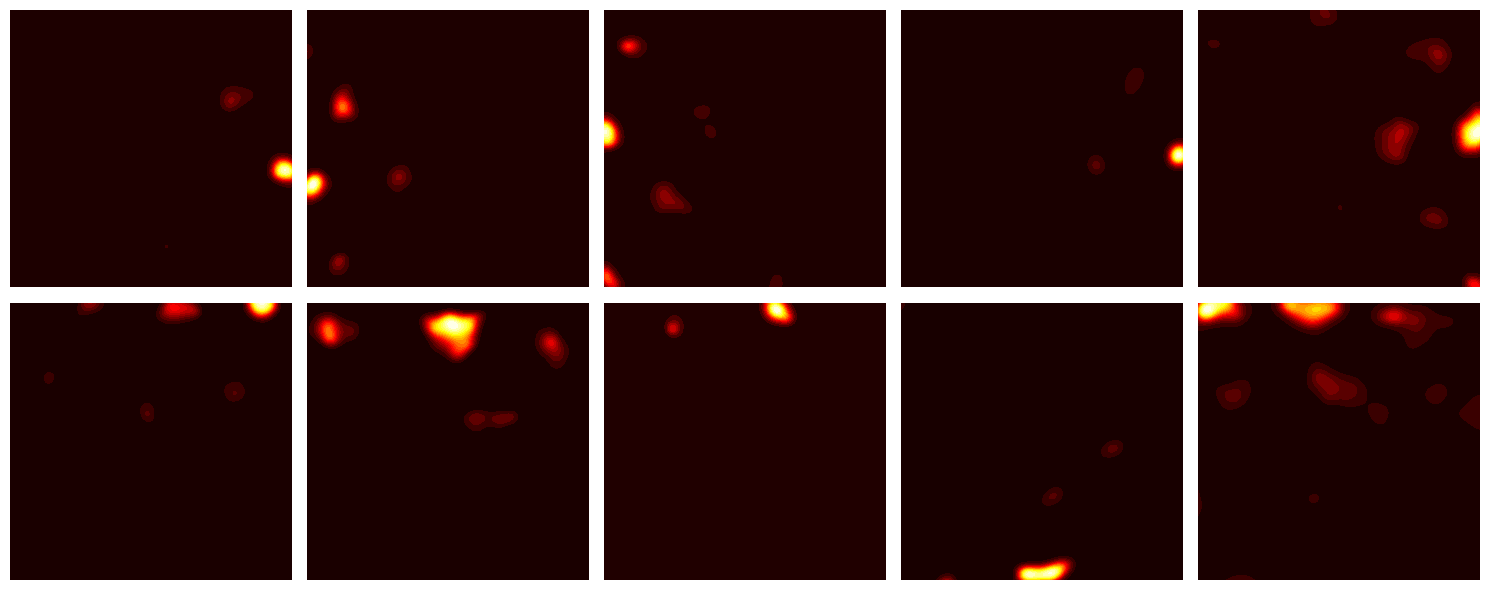

In [14]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

hidden = nn.functional.sigmoid(net.lin1(gc)).permute((-1, 0, 1)).detach().cpu().numpy()
idx = net.lin2.weight[2:].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

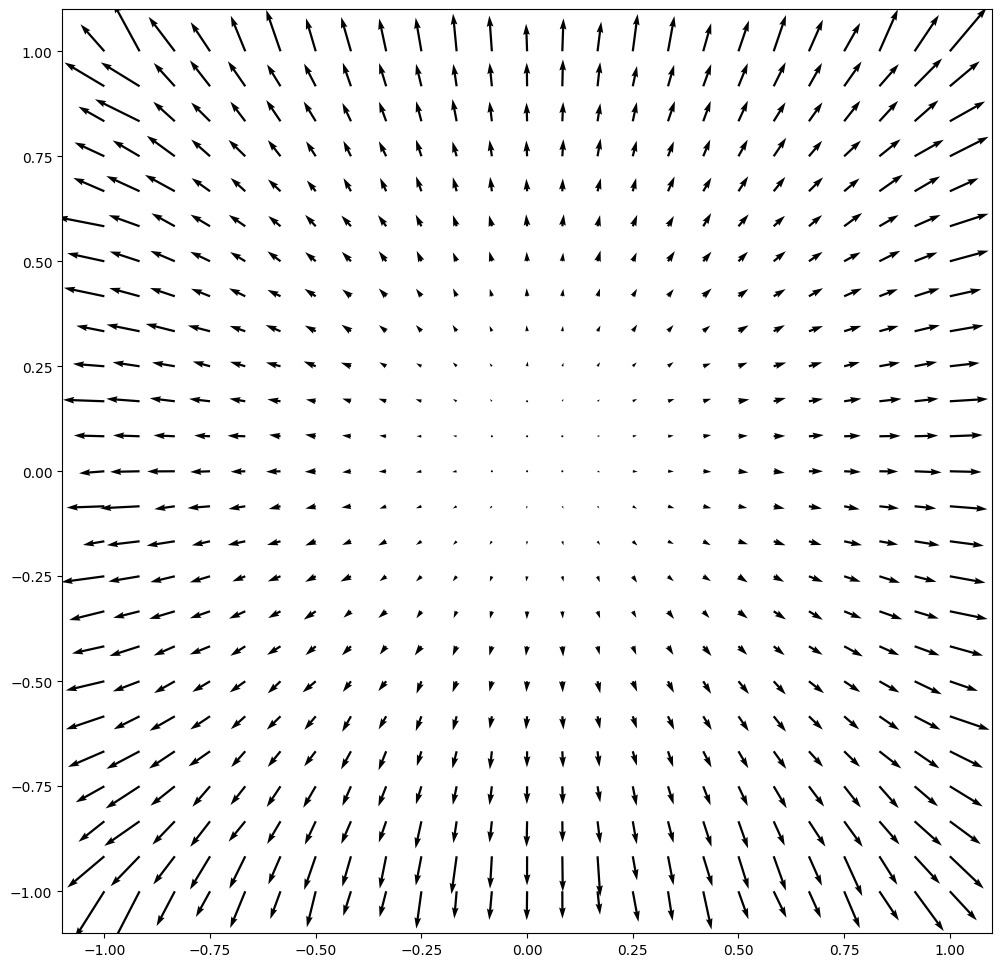

In [15]:
xy = np.linspace(-1, 1, 25)
X, Y = np.meshgrid(xy, xy)

plt.figure(figsize=(12, 12))
plt.quiver(X, Y, *net.lin2(net.lin1(gc))[::16,::16,2:].permute(-1, 0, 1).detach().cpu())
plt.show()

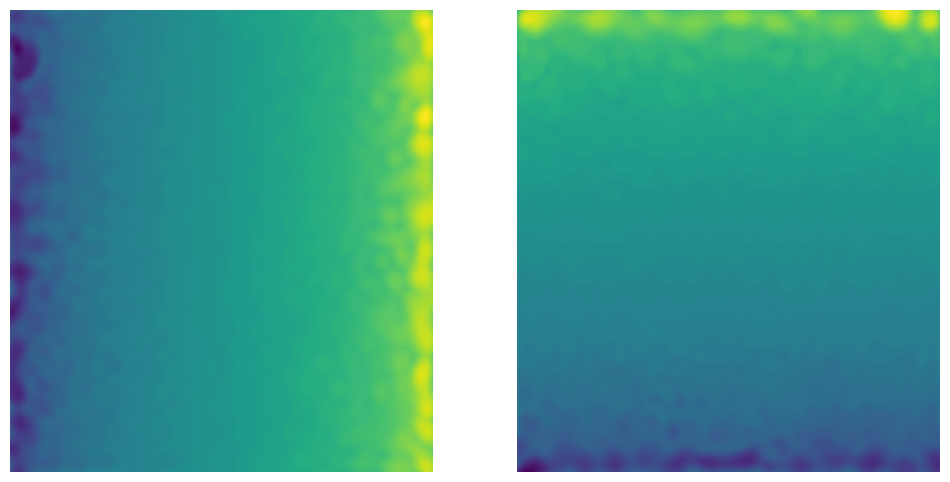

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.axis('off')
ax2.axis('off')
ax1.contourf(net.lin2(net.lin1(gc))[:,:,2].detach().cpu(), levels=100)
ax2.contourf(net.lin2(net.lin1(gc))[:,:,3].detach().cpu(), levels=100)
plt.show()

min   |max  |mean |std  |shape
-7.951|7.992|-0.342|4.581|torch.Size([2, 55])
min   |max  |mean |std  |shape
-6.439|7.237|0.021|1.879|torch.Size([2, 445])


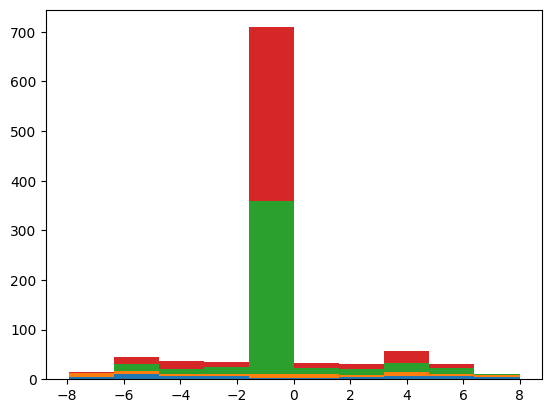

In [17]:
used = hidden.mean((1, 2)) > hidden.mean() + hidden.mean((1, 2)).std()
    
print_stats(net.lin2.weight[2:, used])
print_stats(net.lin2.weight[2:, ~used])

# plt.hist(net.lin2.weight[2:, ~used].detach().cpu(), histtype='barstacked')
# plt.hist(net.lin2.weight[2:, used].detach().cpu(), histtype='barstacked')
plt.hist([*net.lin2.weight[2:, used].detach().cpu(),
          *net.lin2.weight[2:, ~used].detach().cpu()],
         histtype='barstacked')
plt.show()

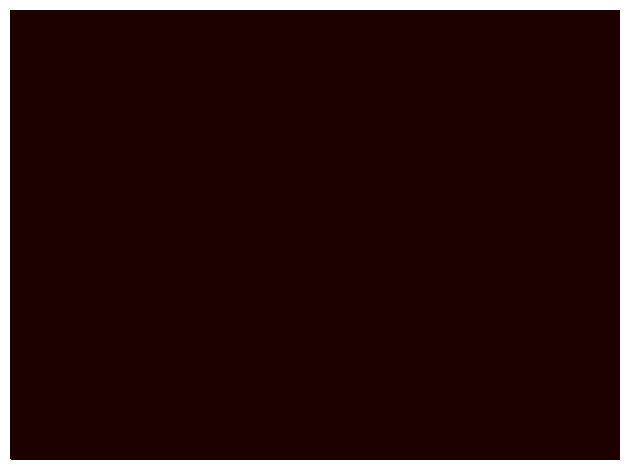

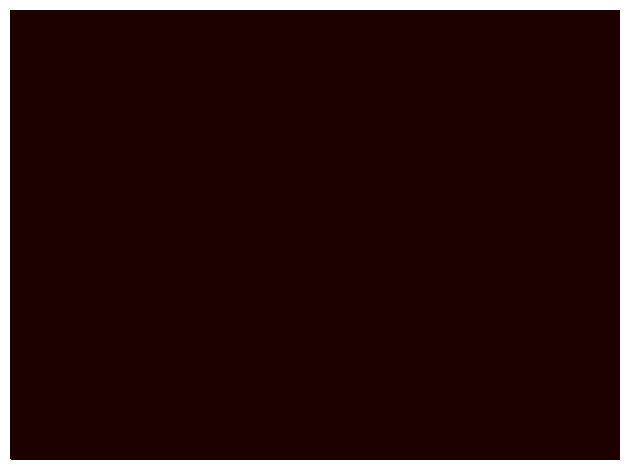

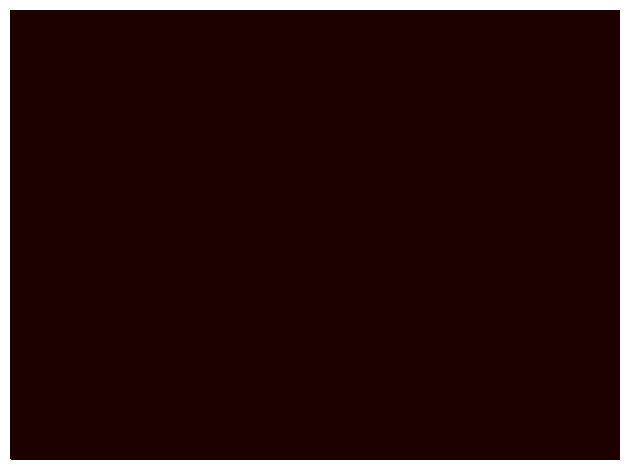

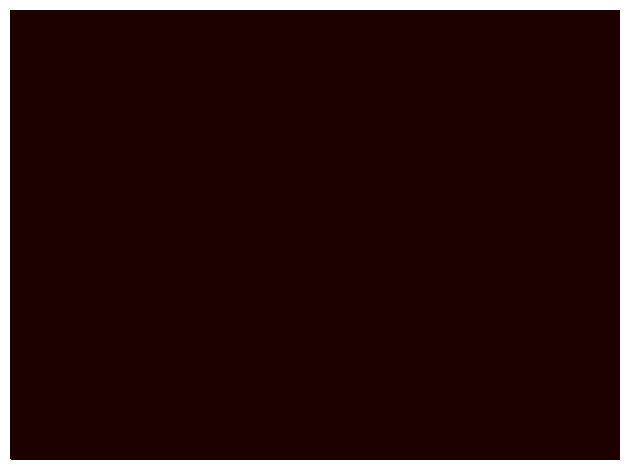

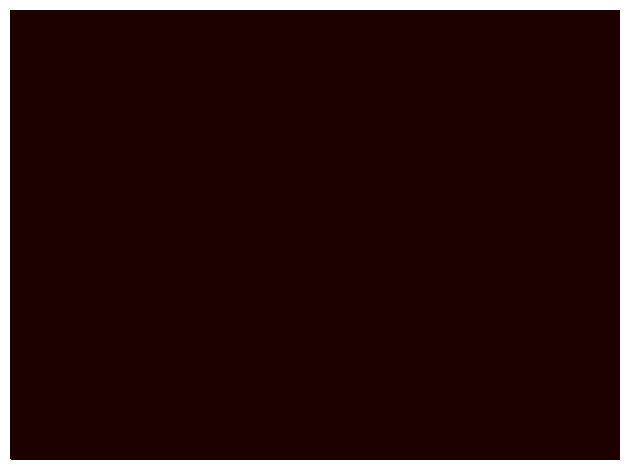

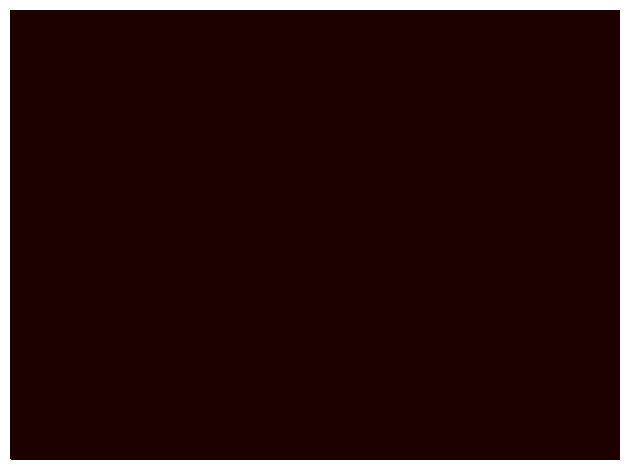

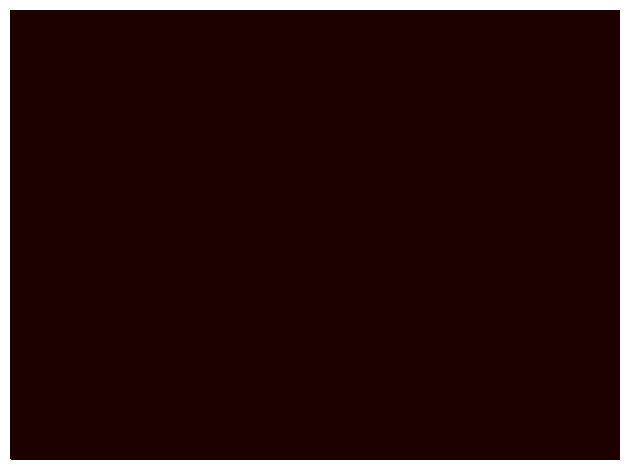

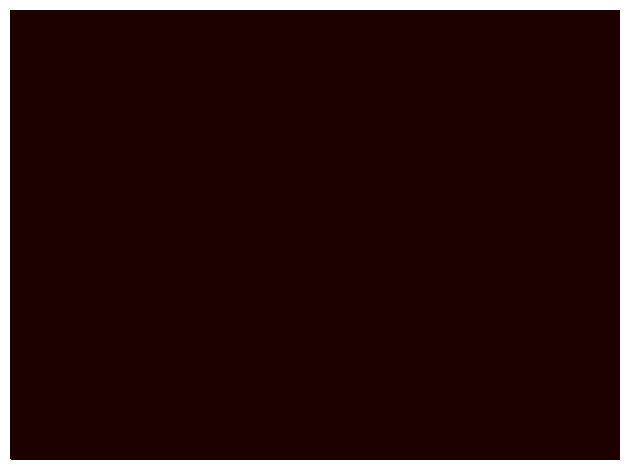

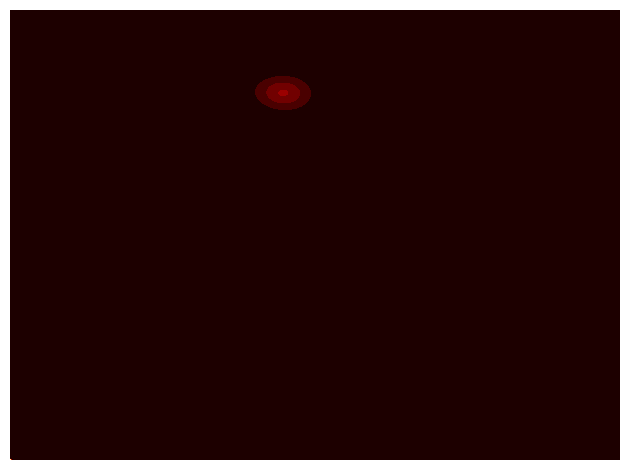

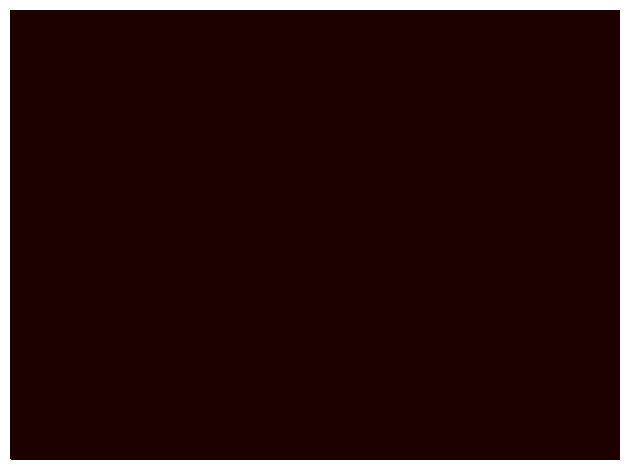

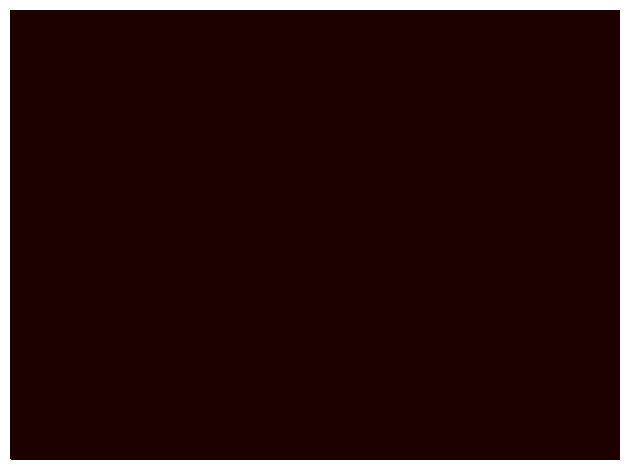

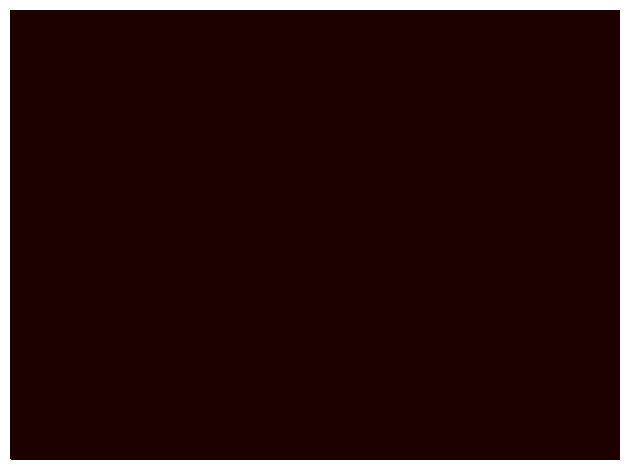

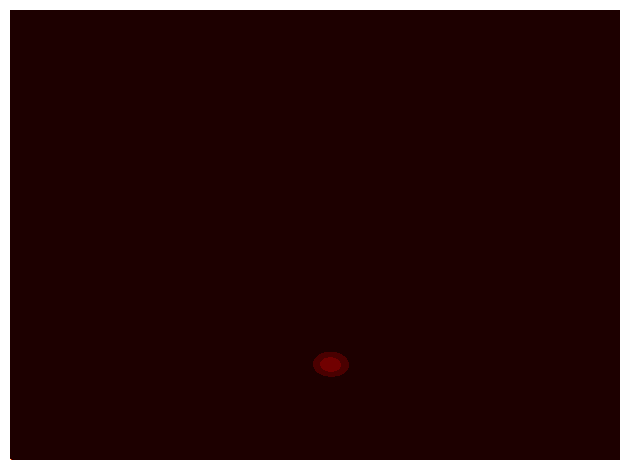

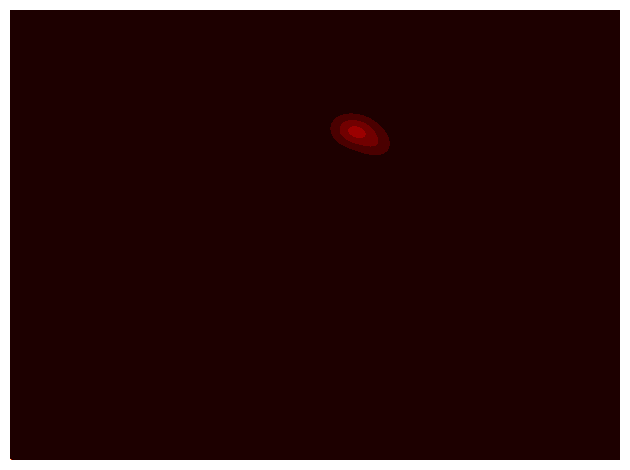

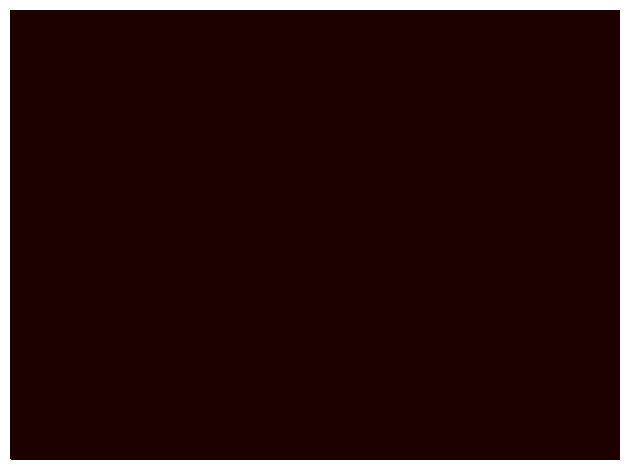

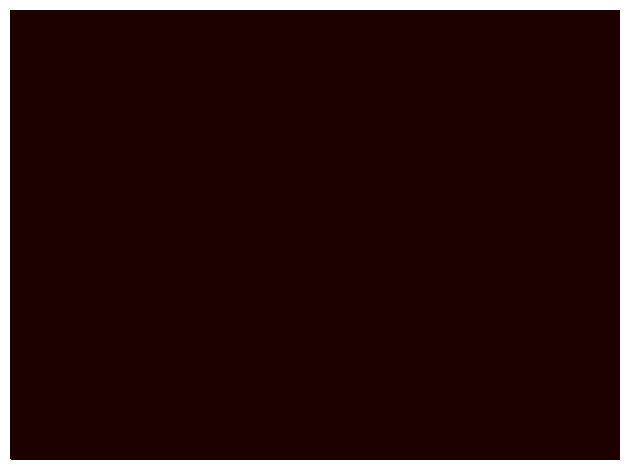

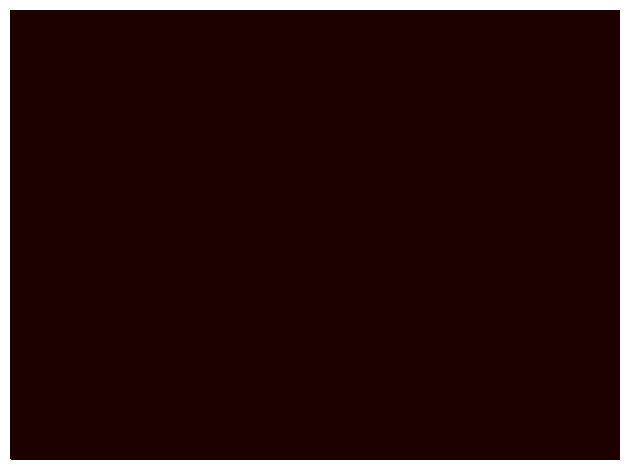

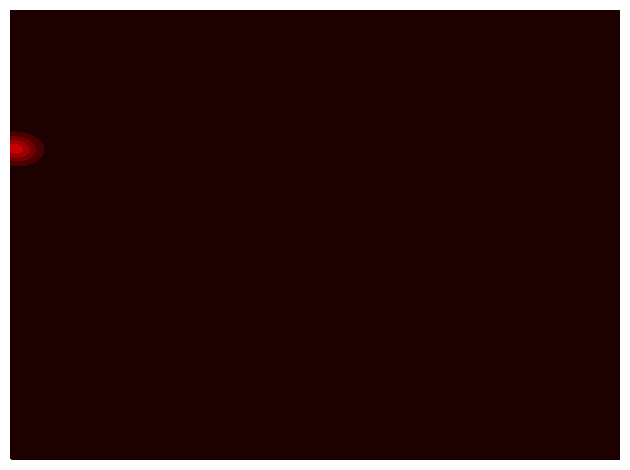

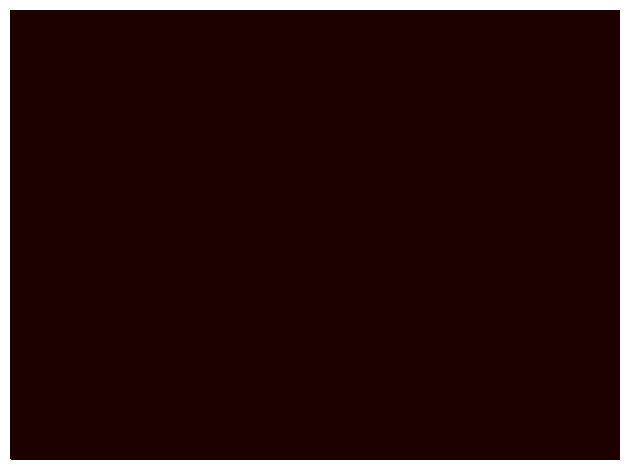

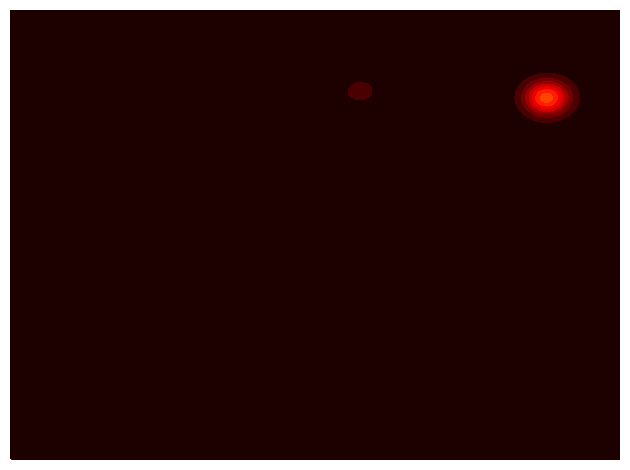

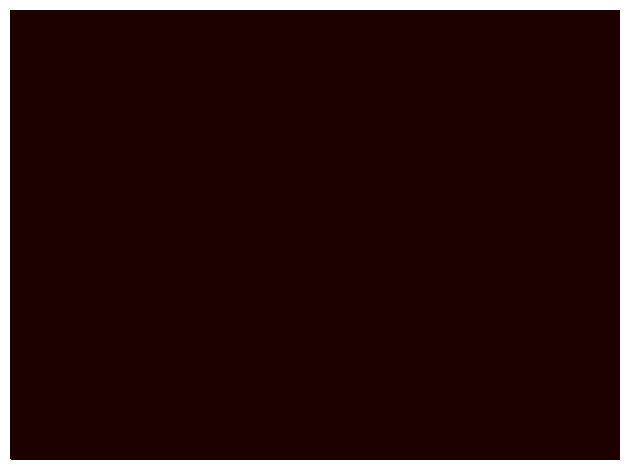

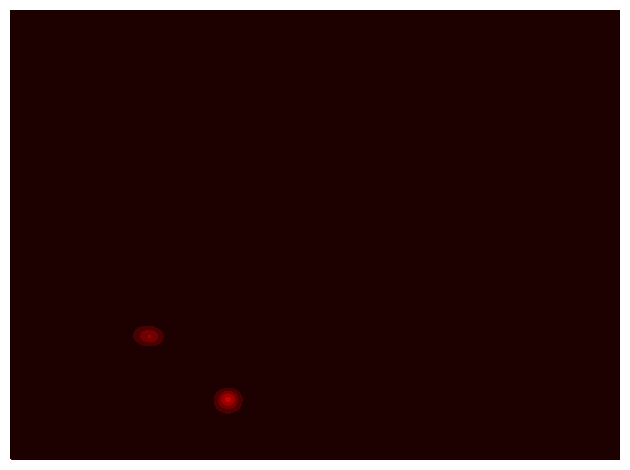

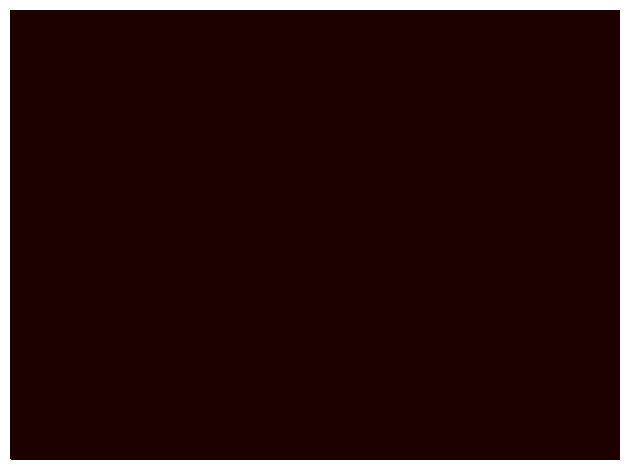

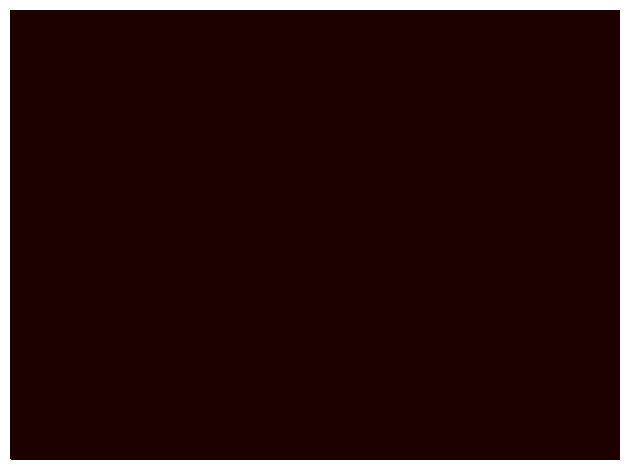

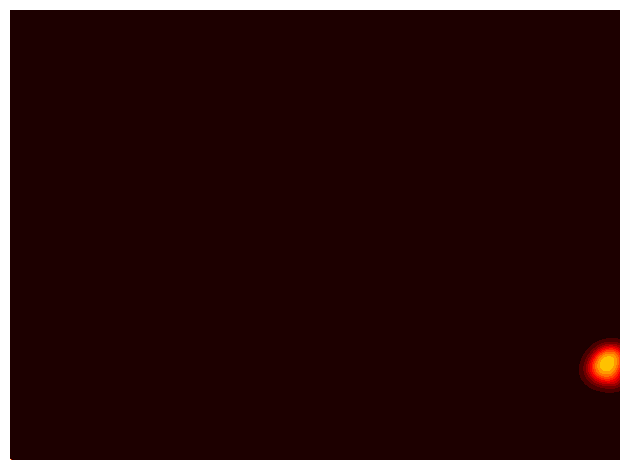

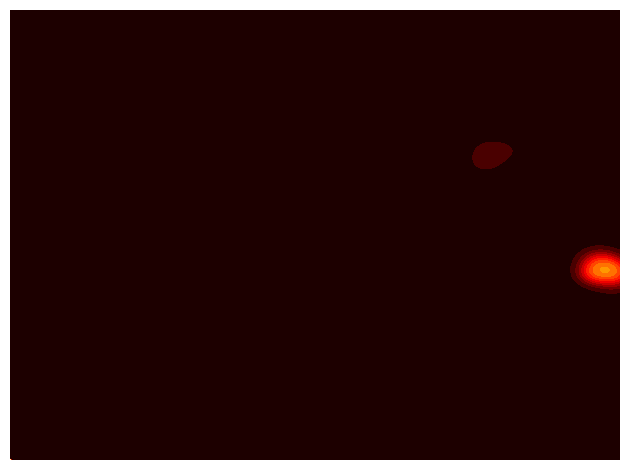

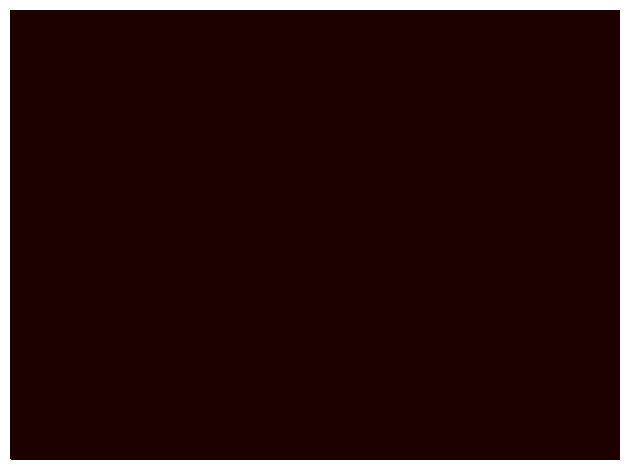

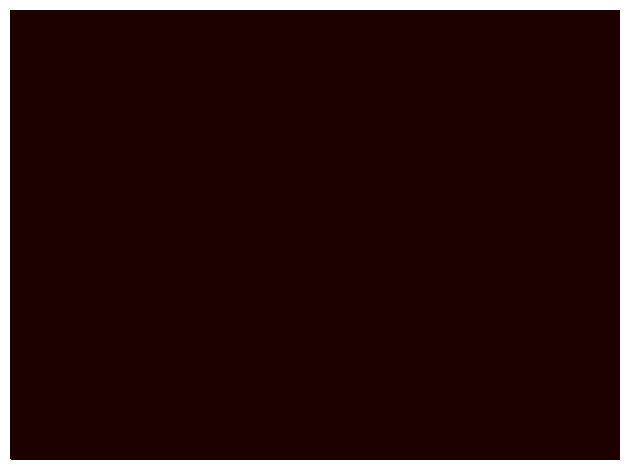

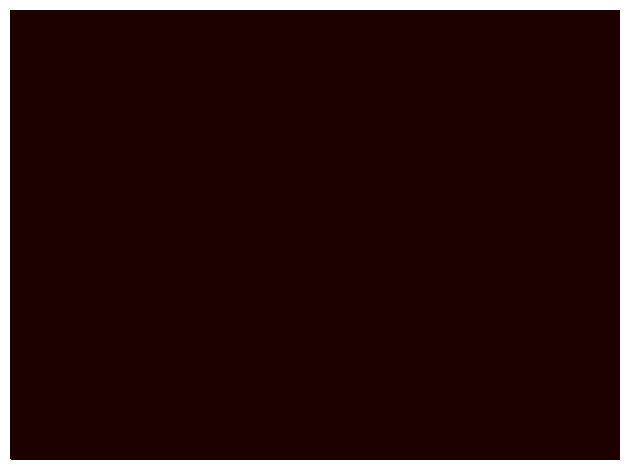

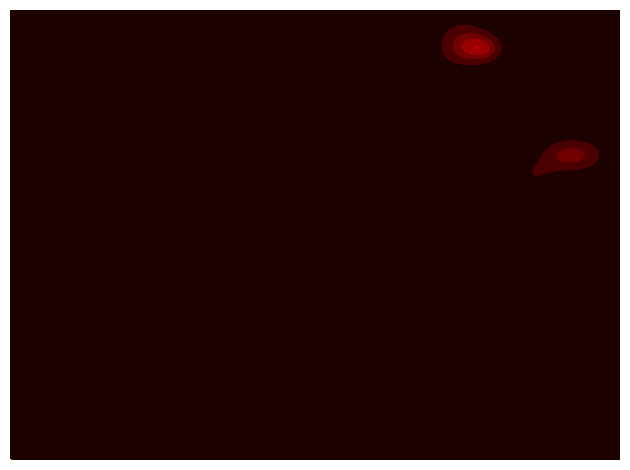

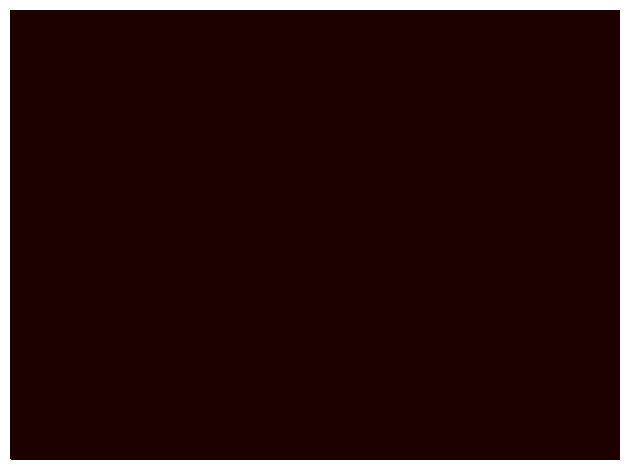

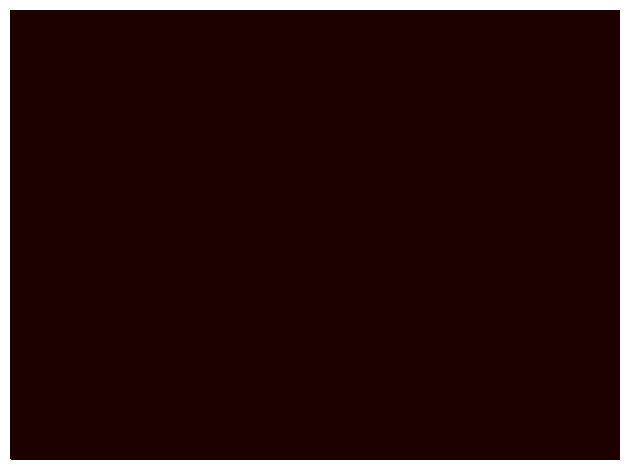

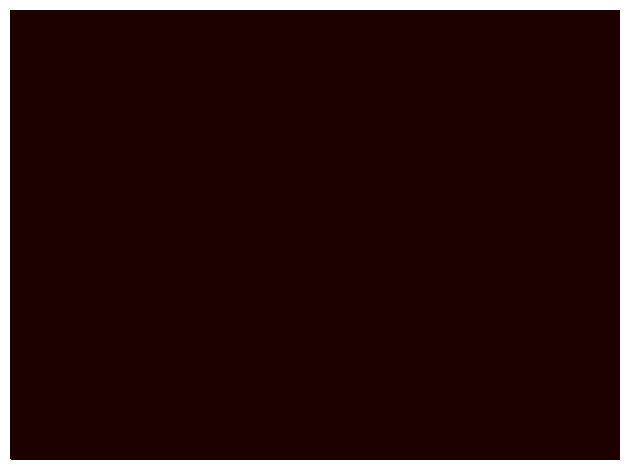

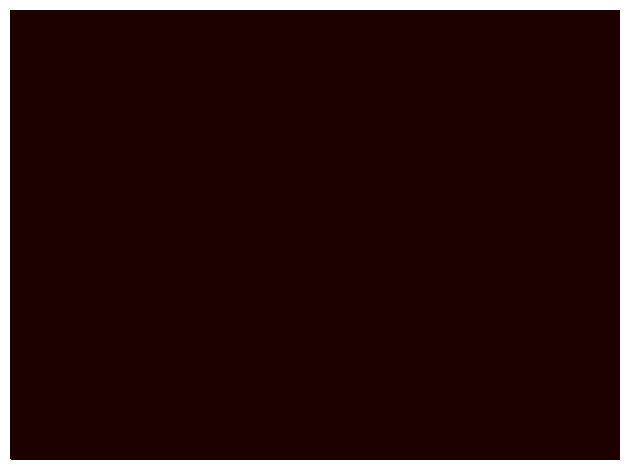

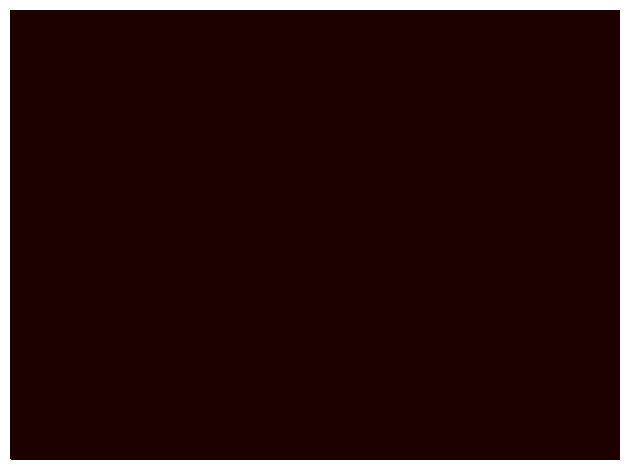

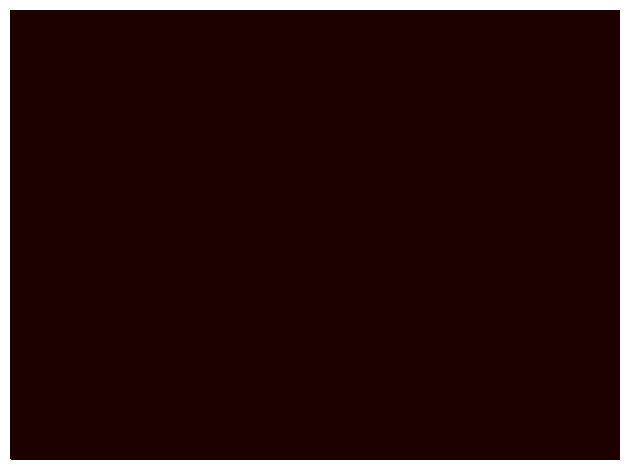

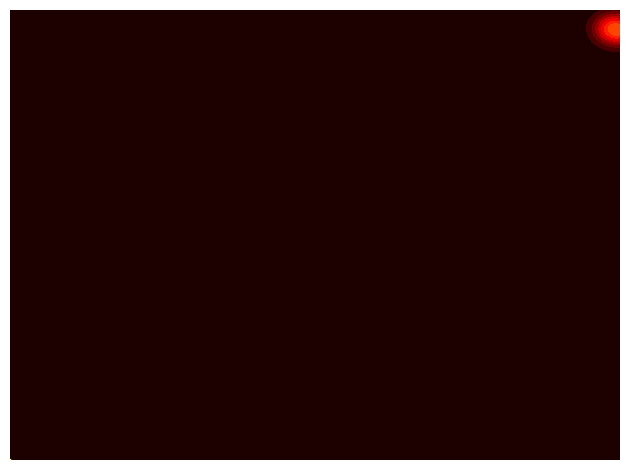

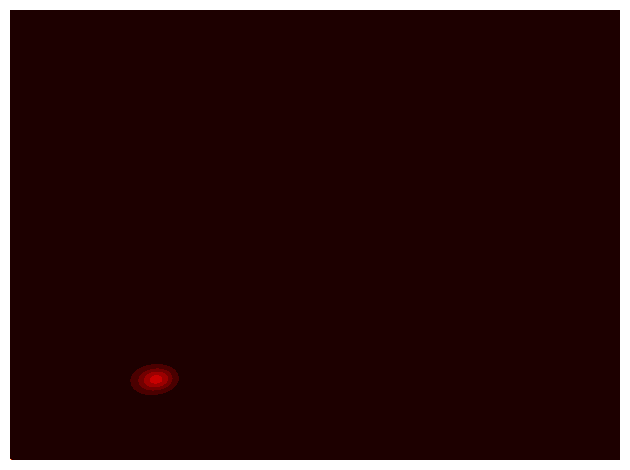

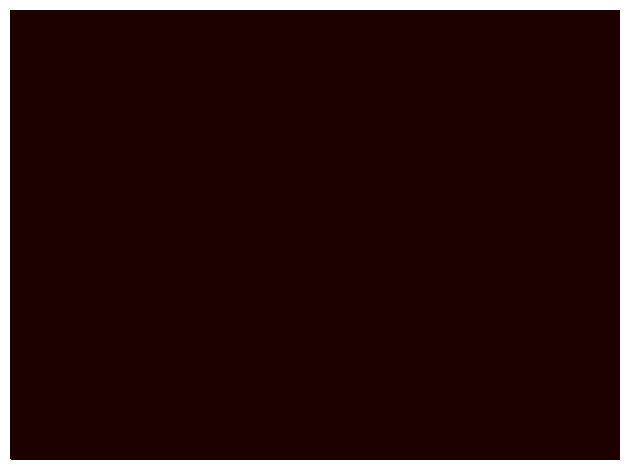

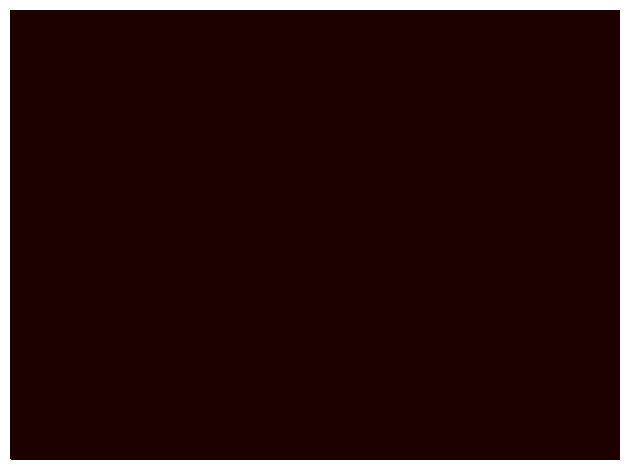

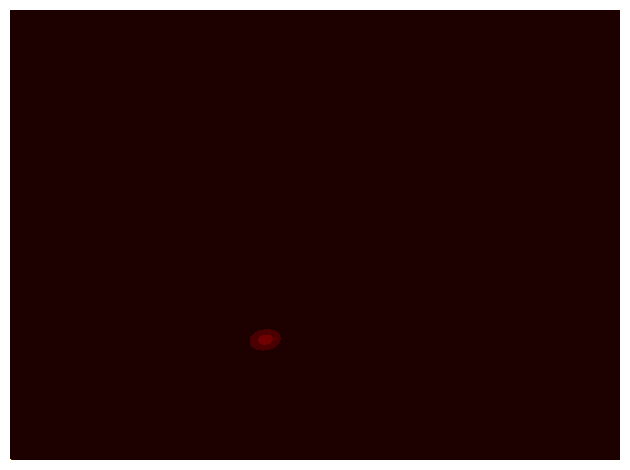

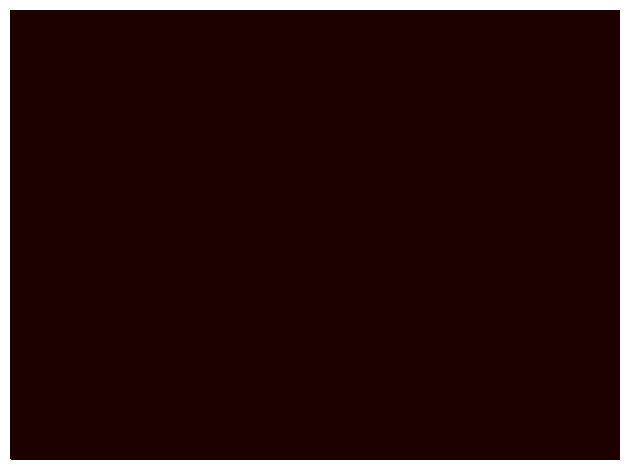

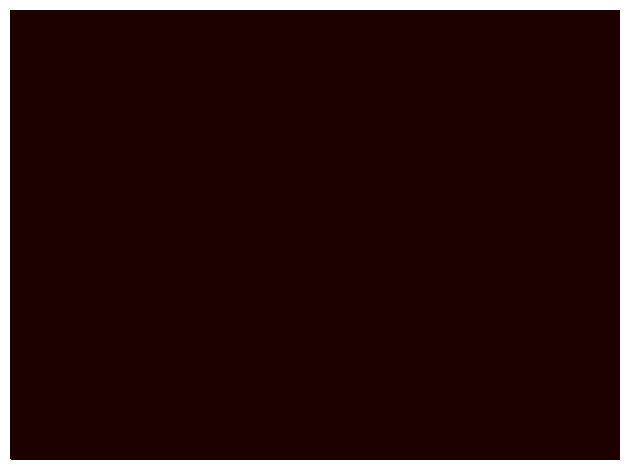

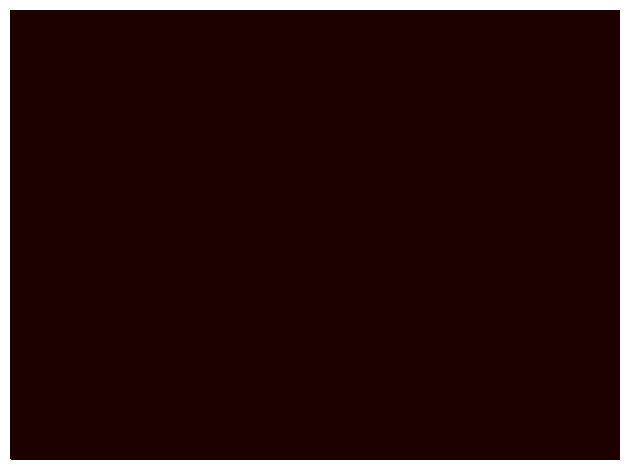

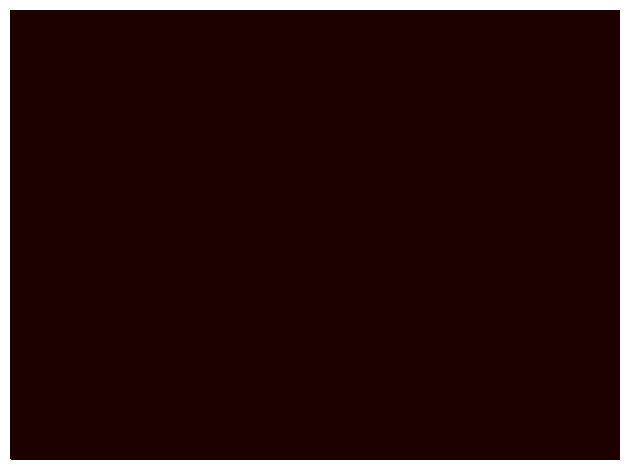

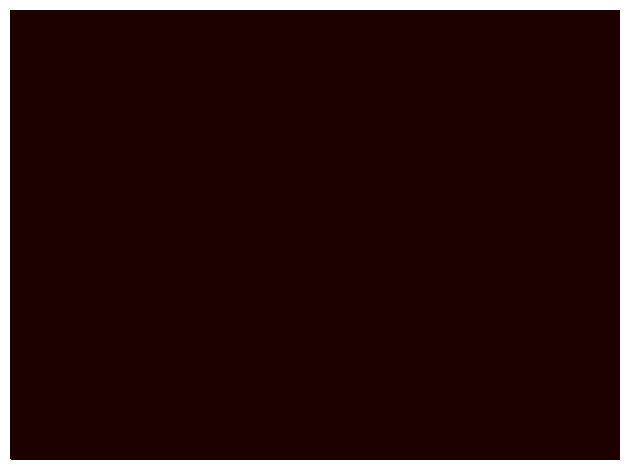

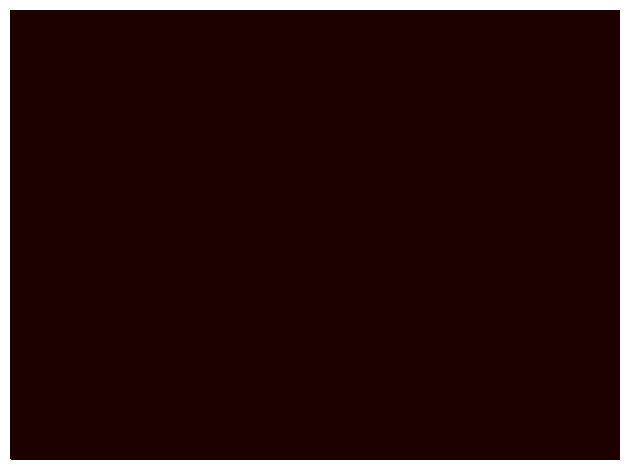

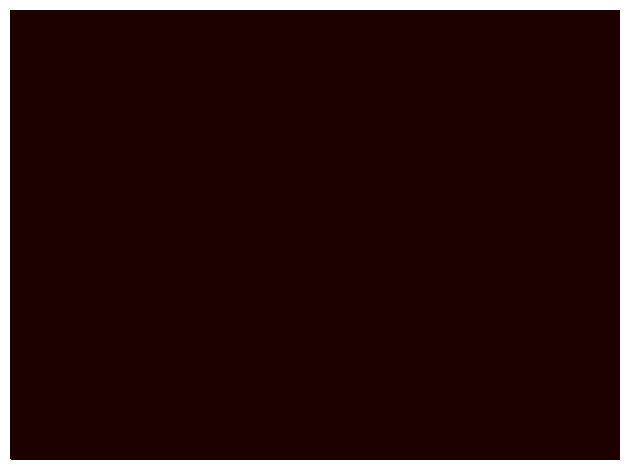

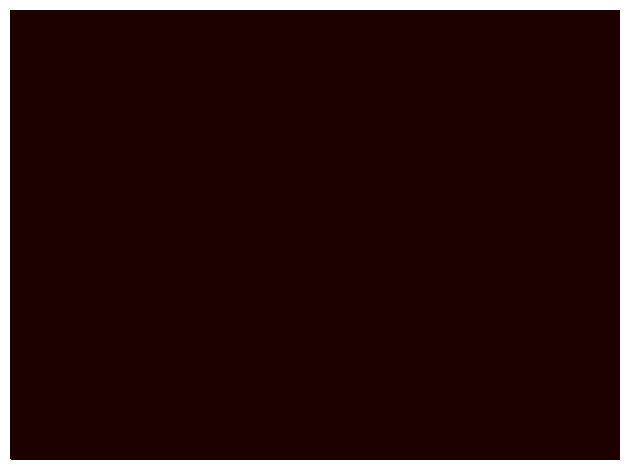

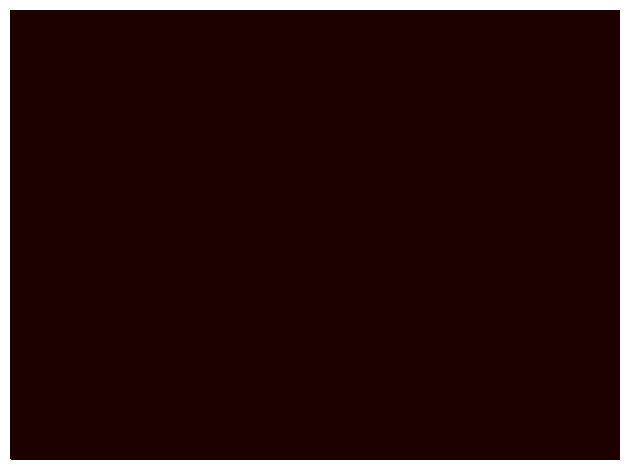

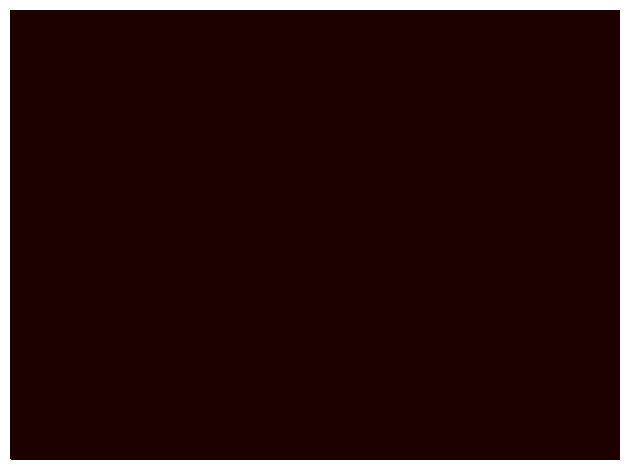

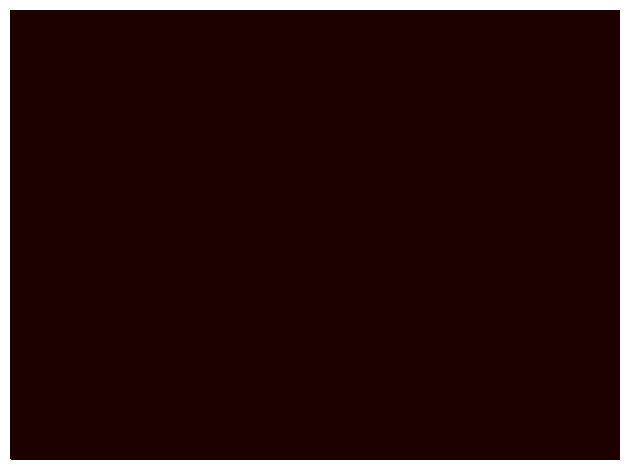

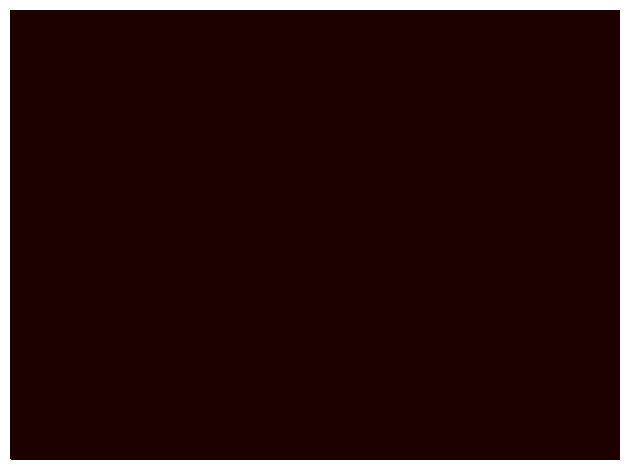

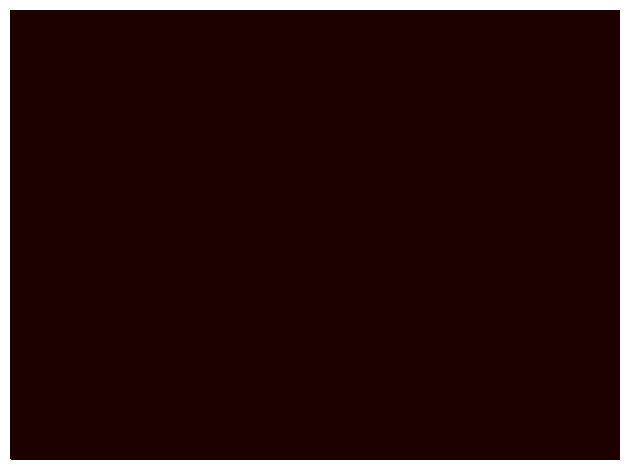

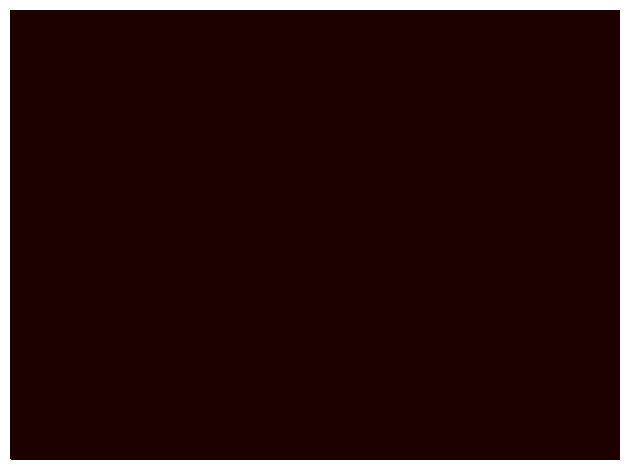

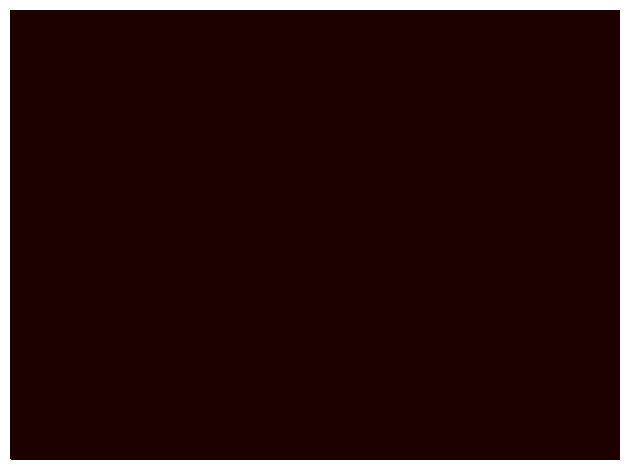

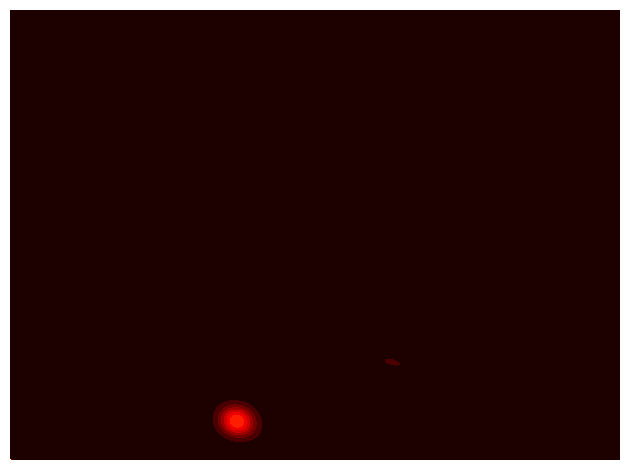

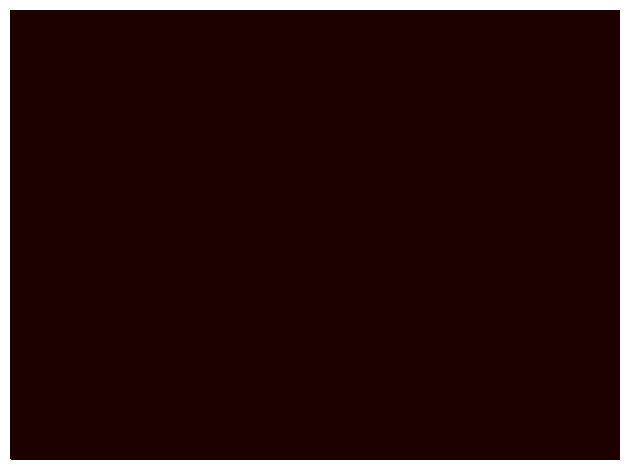

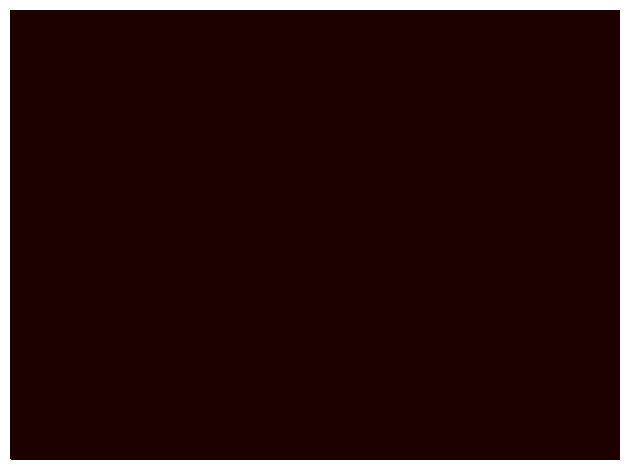

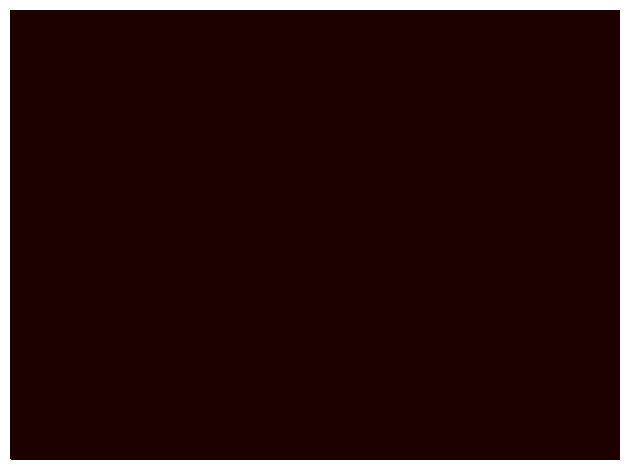

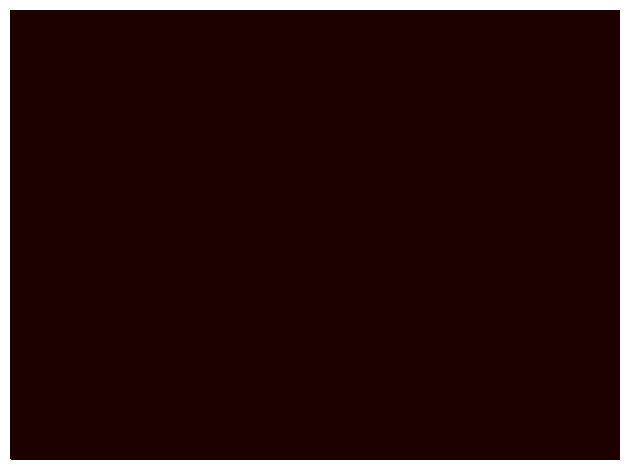

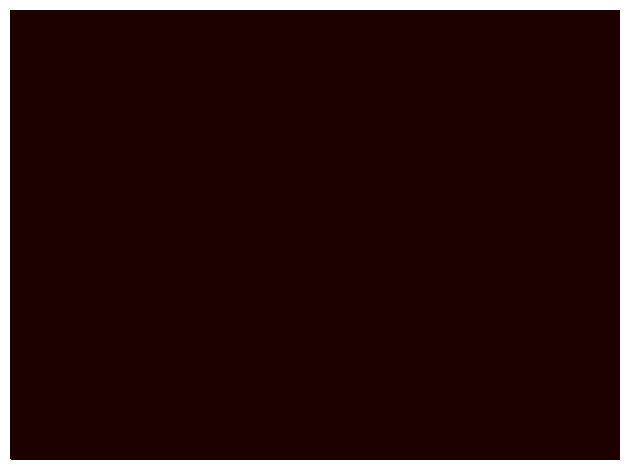

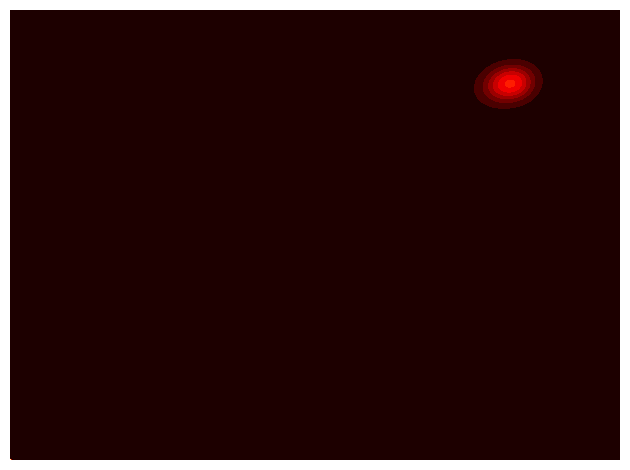

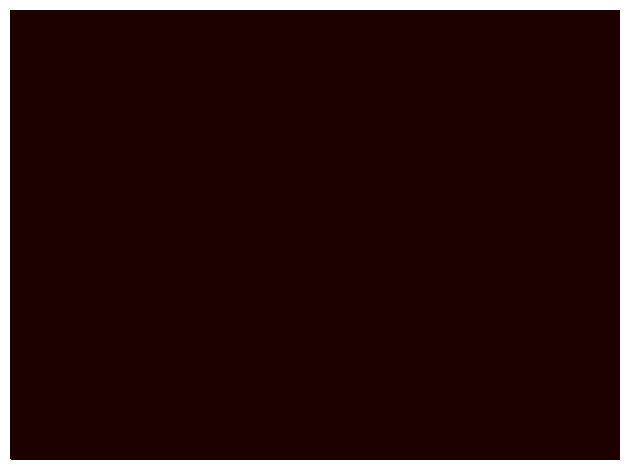

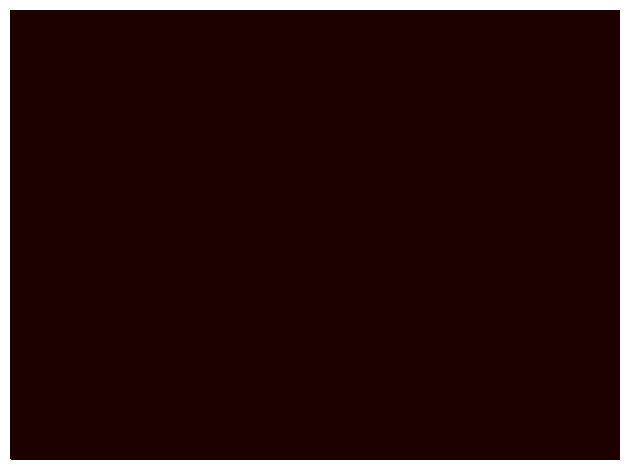

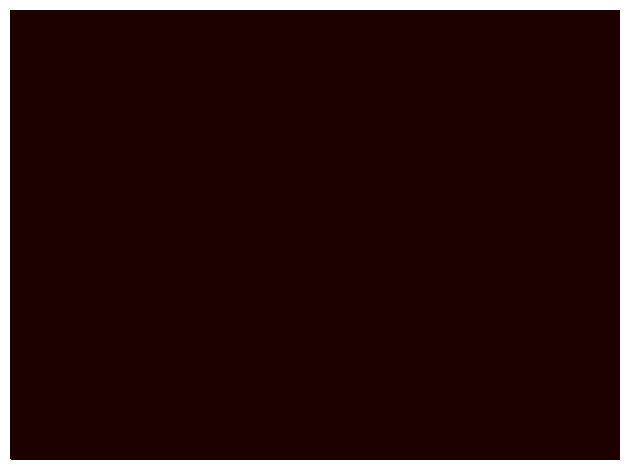

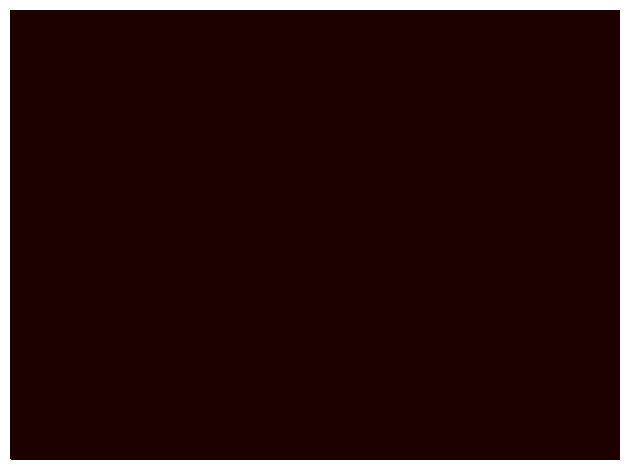

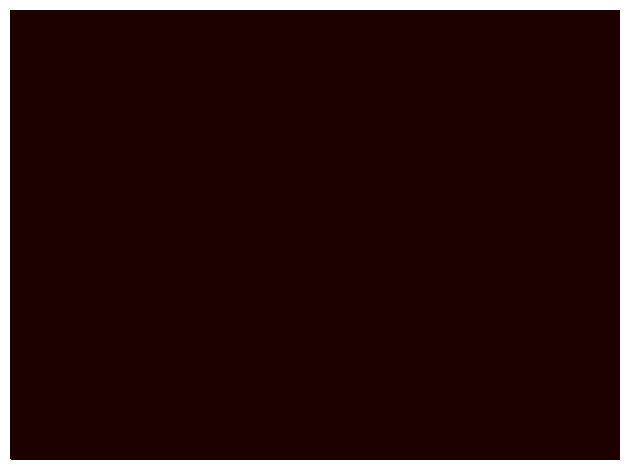

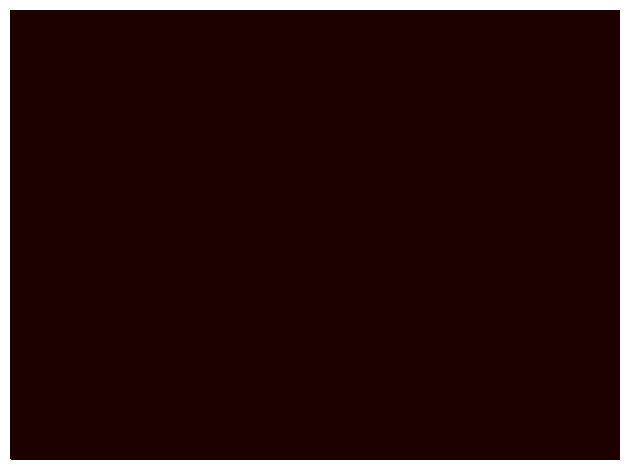

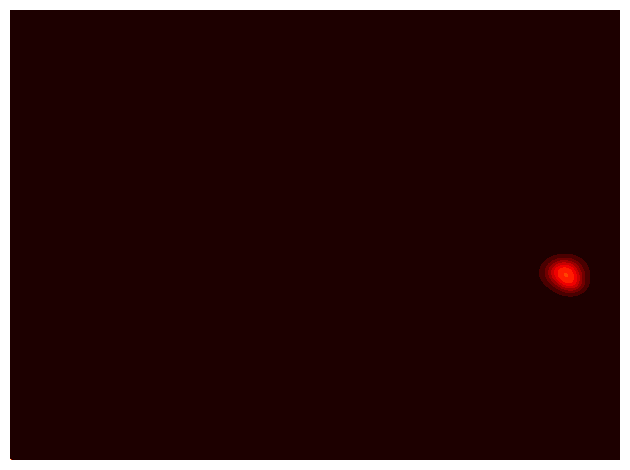

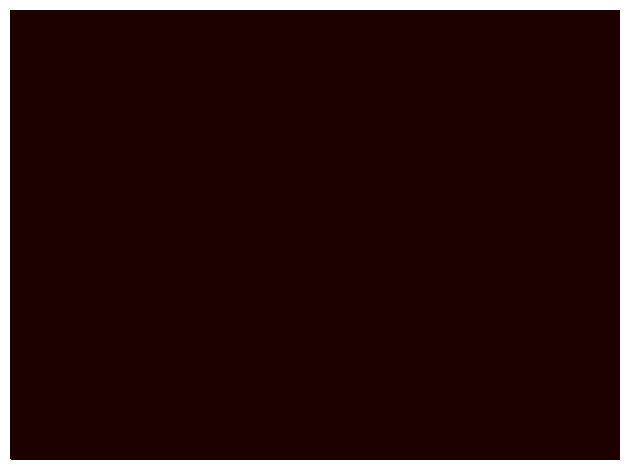

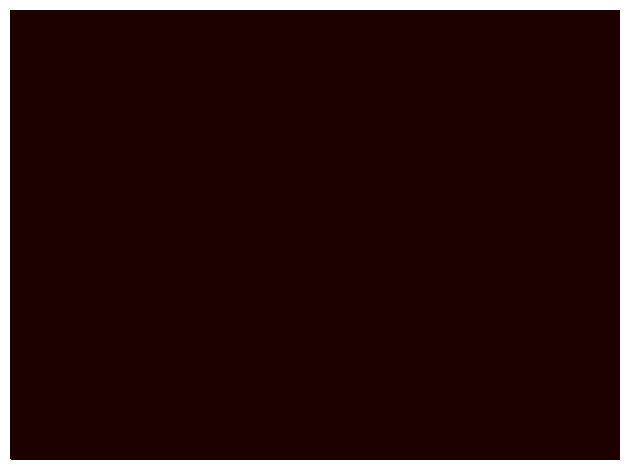

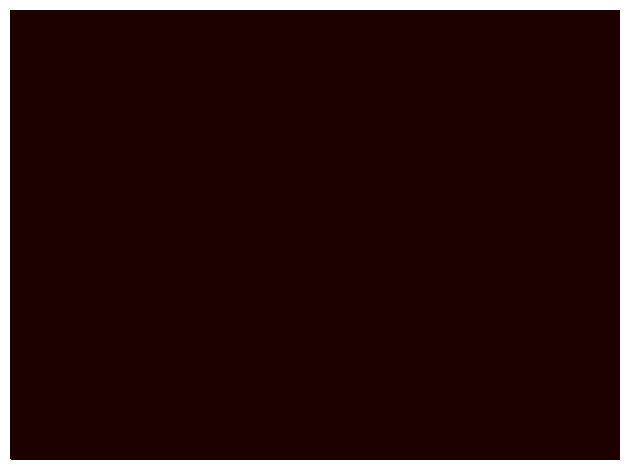

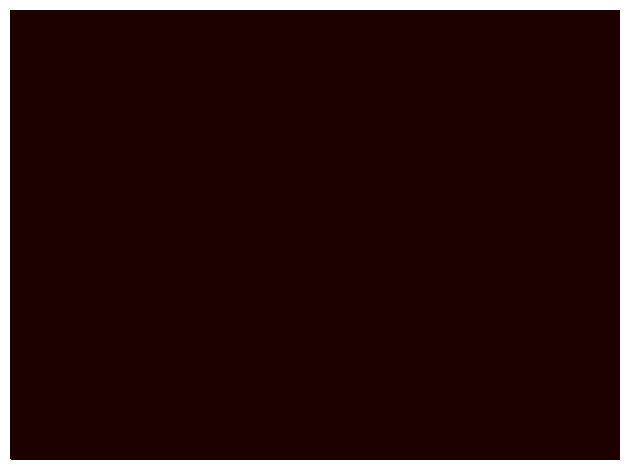

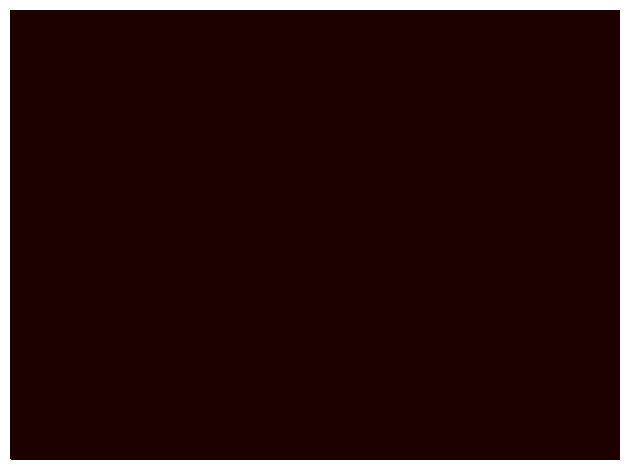

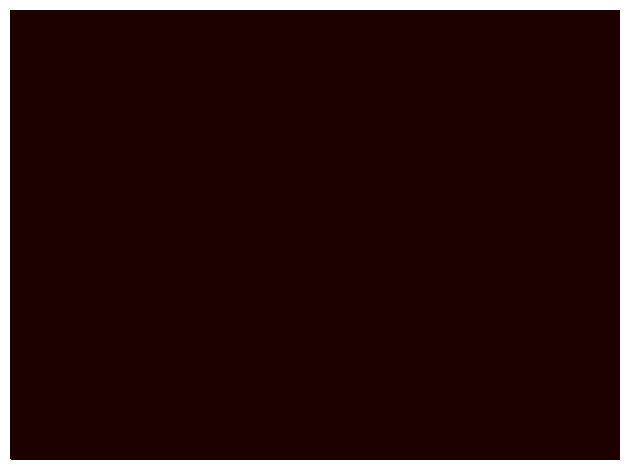

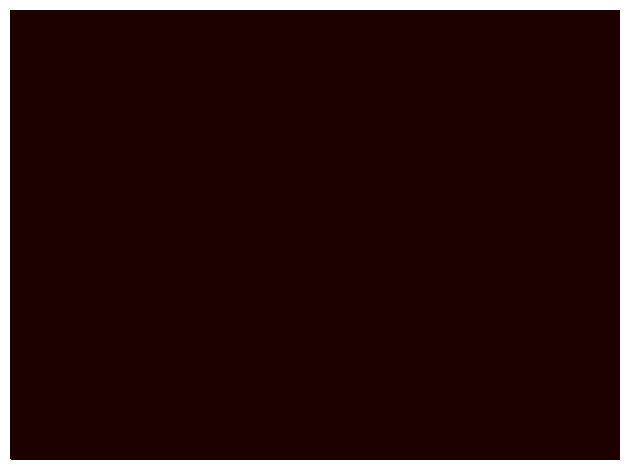

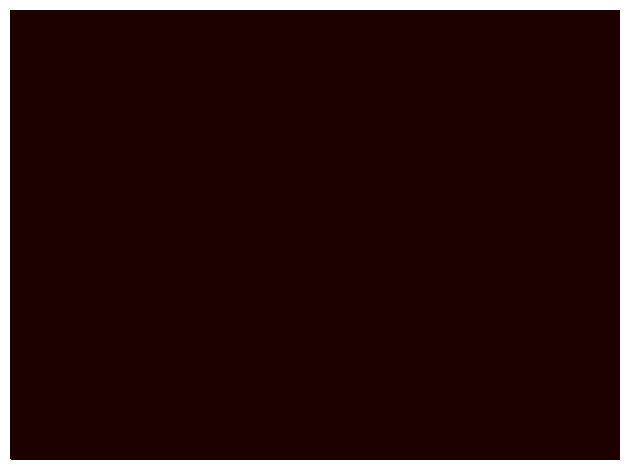

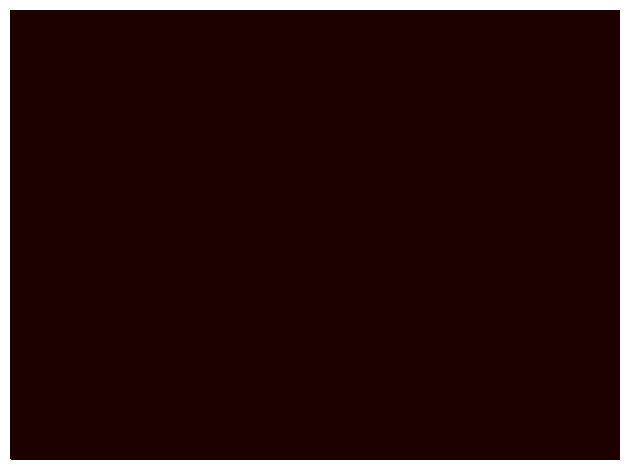

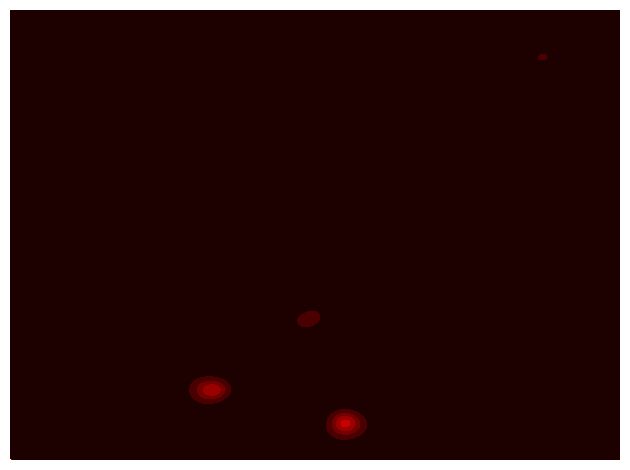

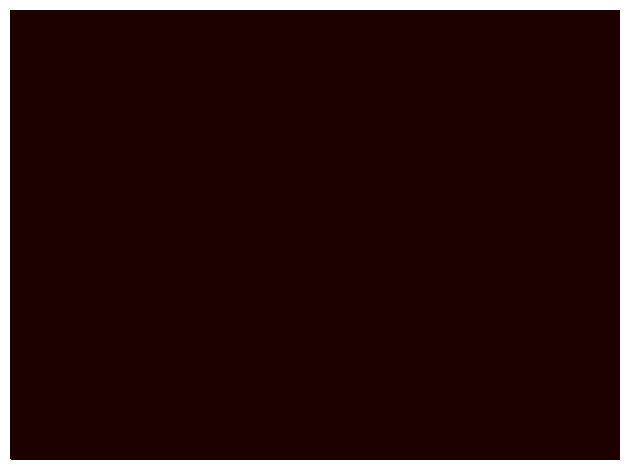

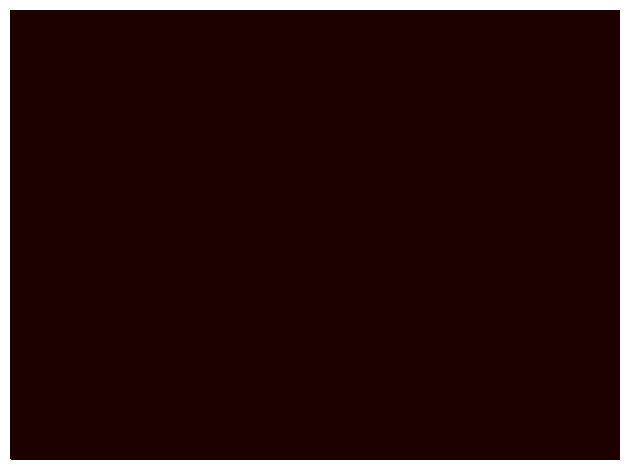

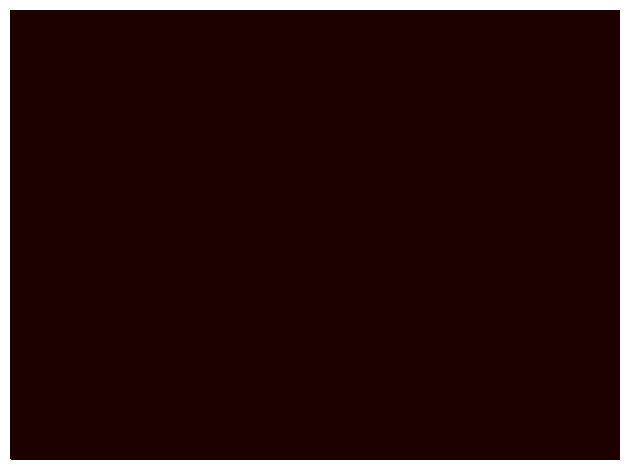

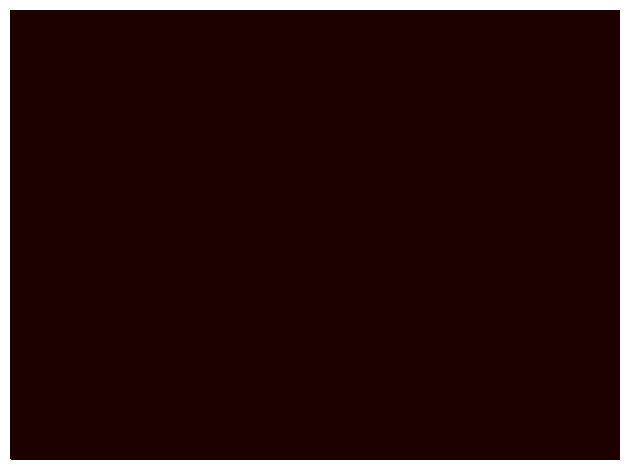

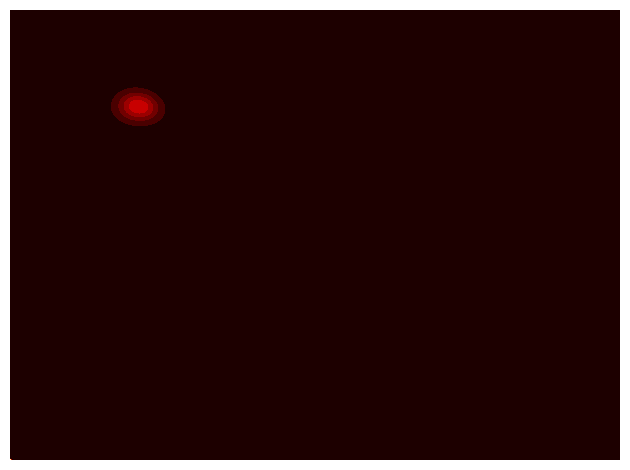

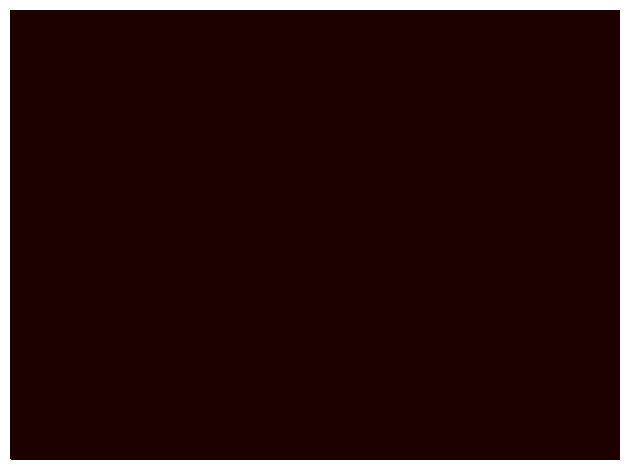

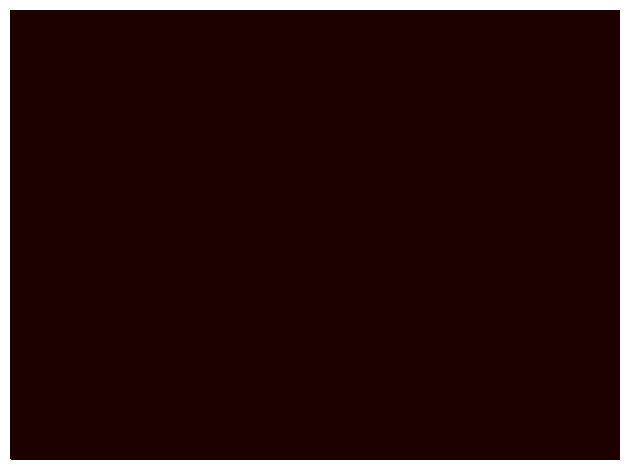

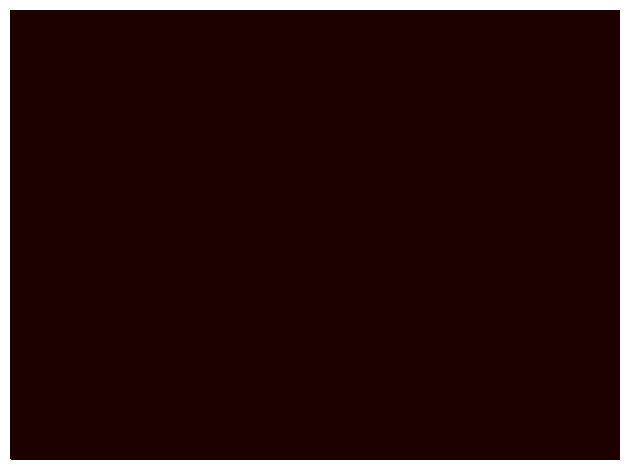

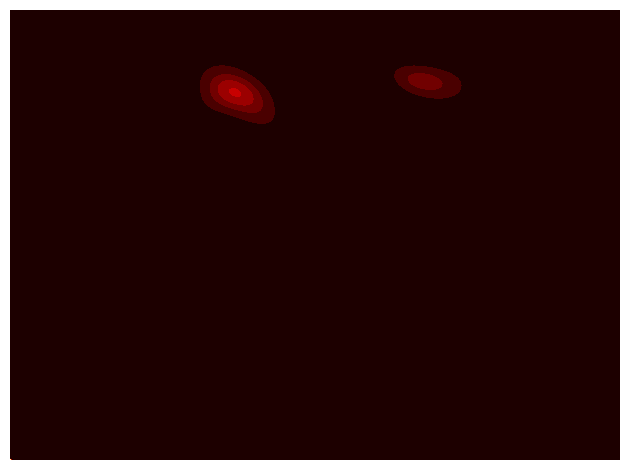

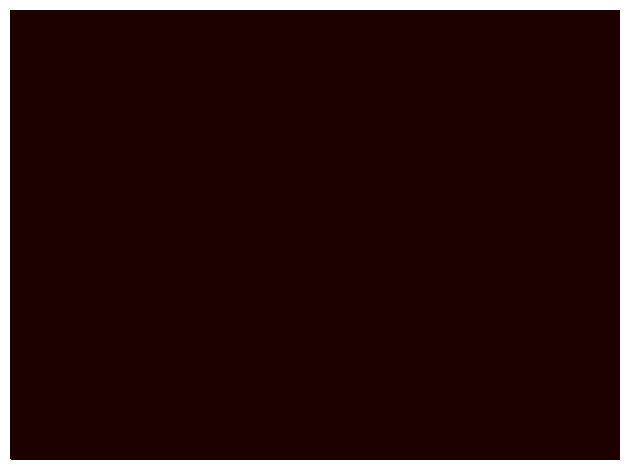

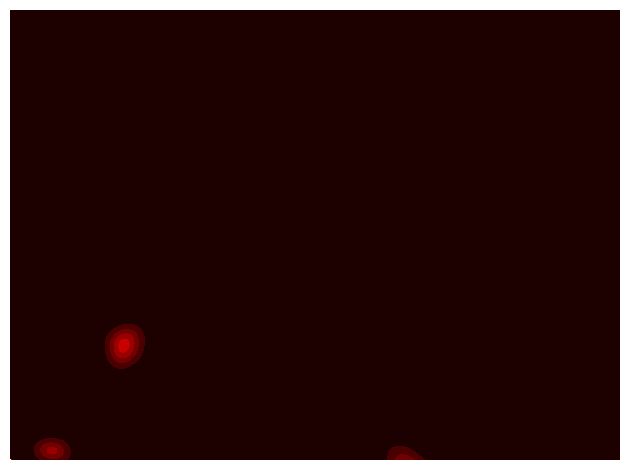

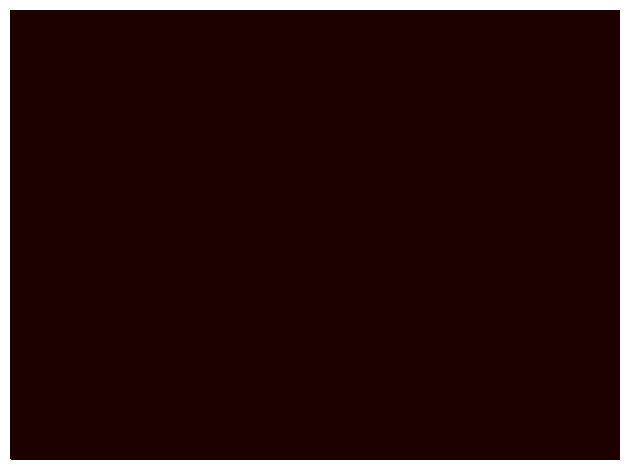

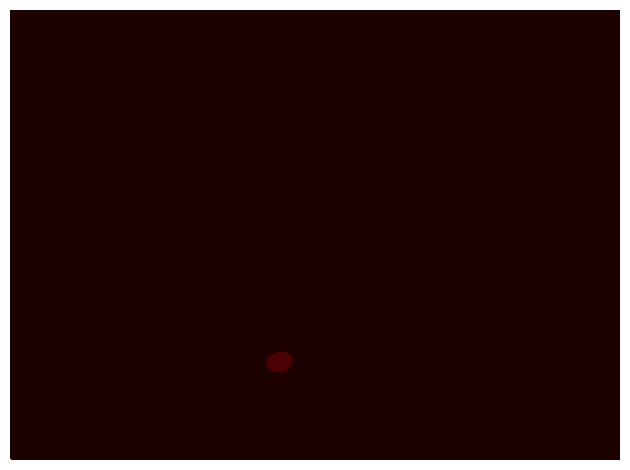

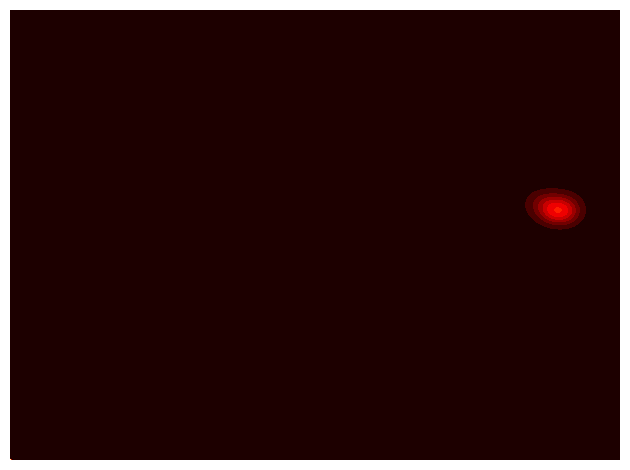

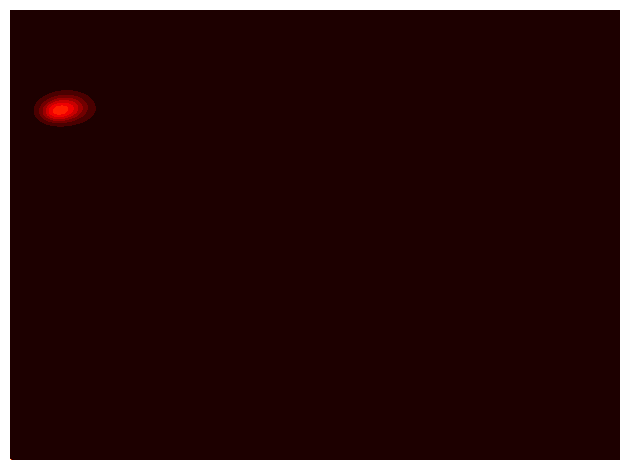

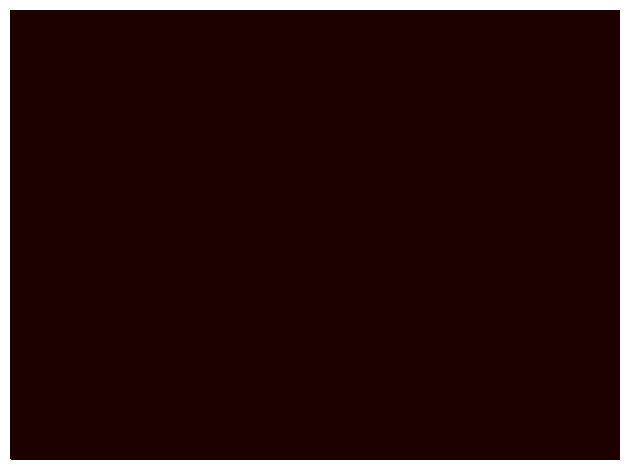

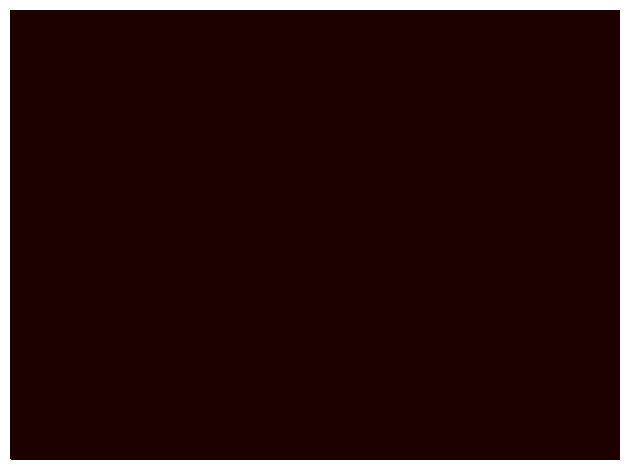

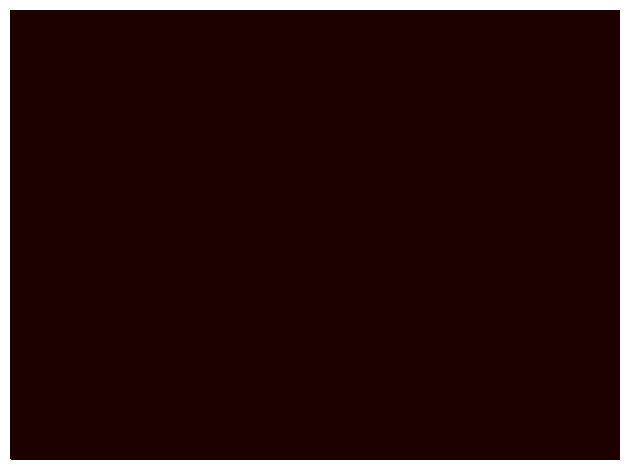

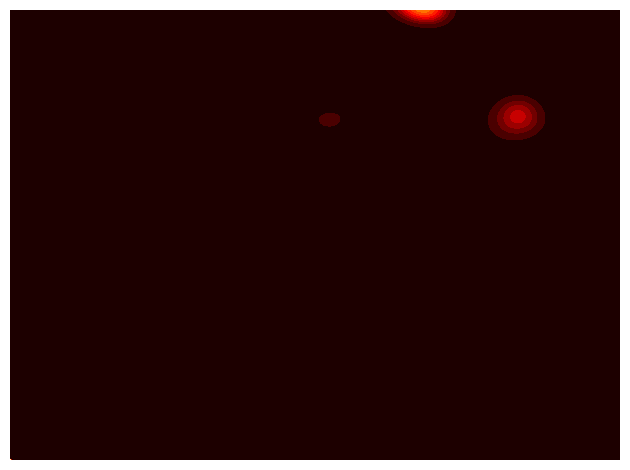

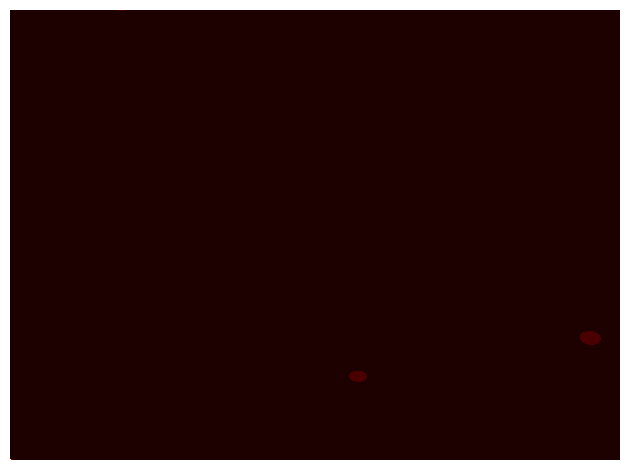

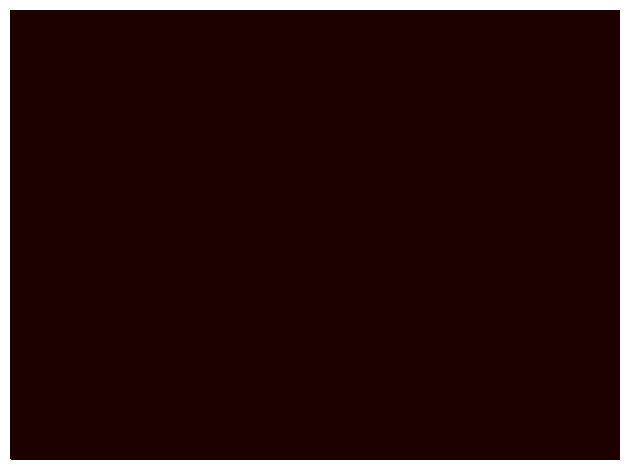

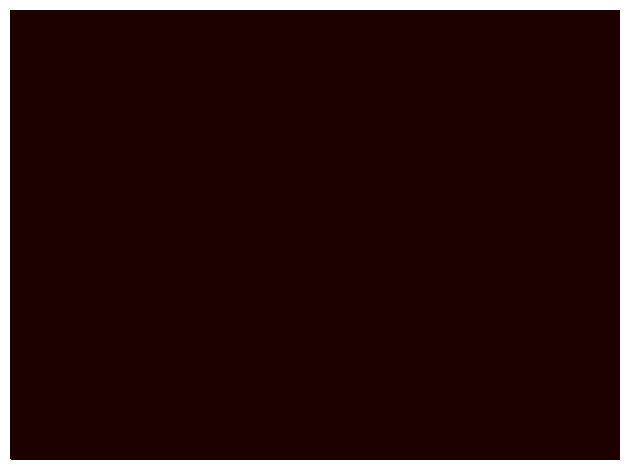

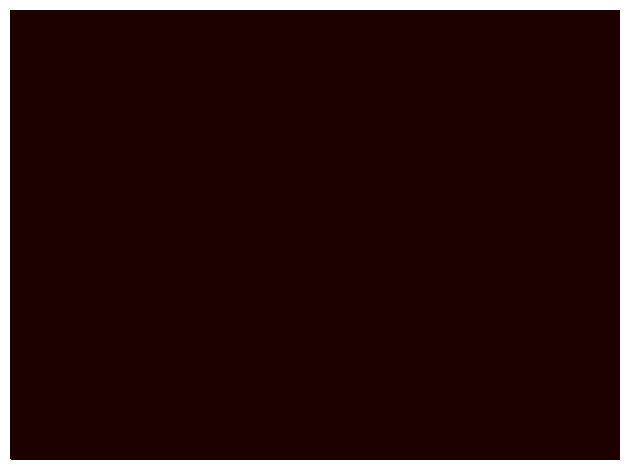

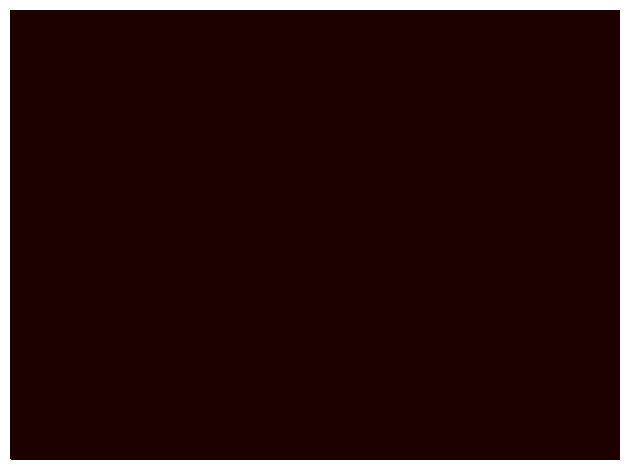

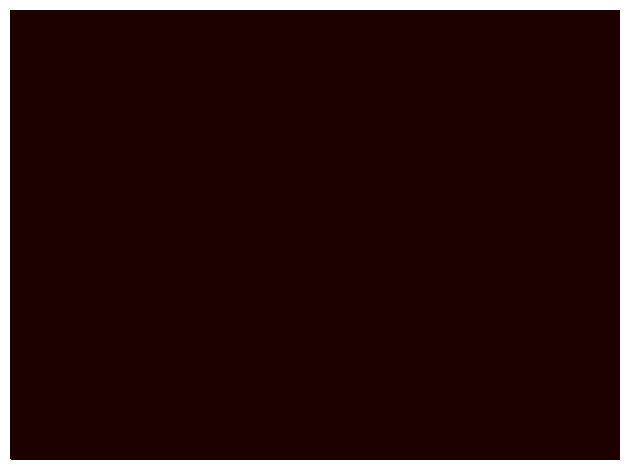

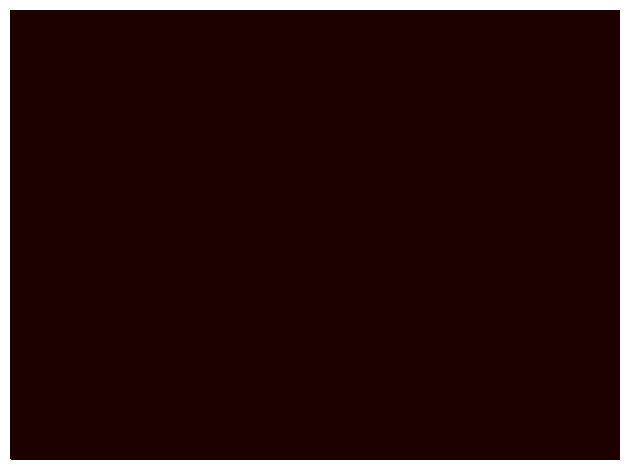

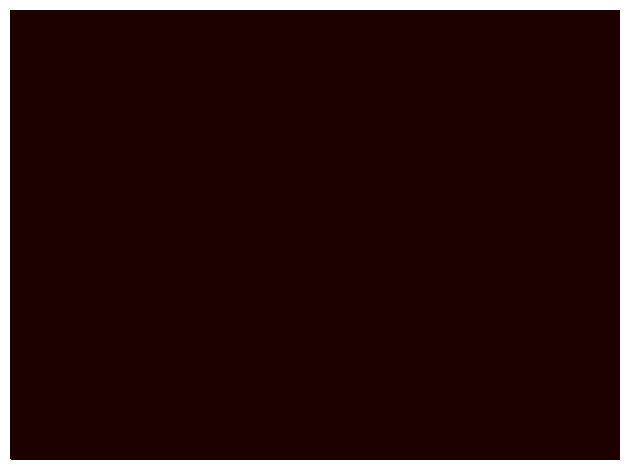

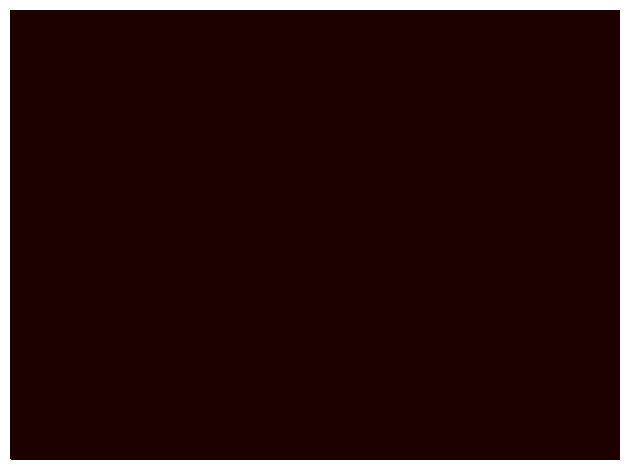

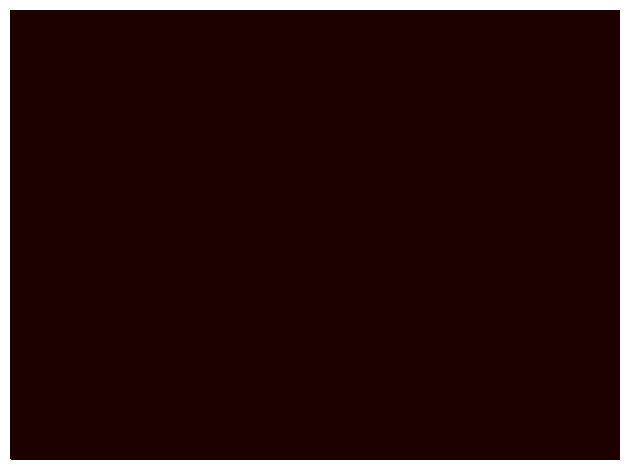

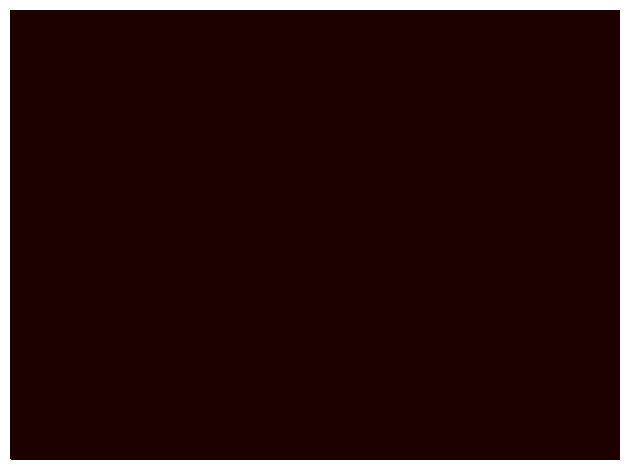

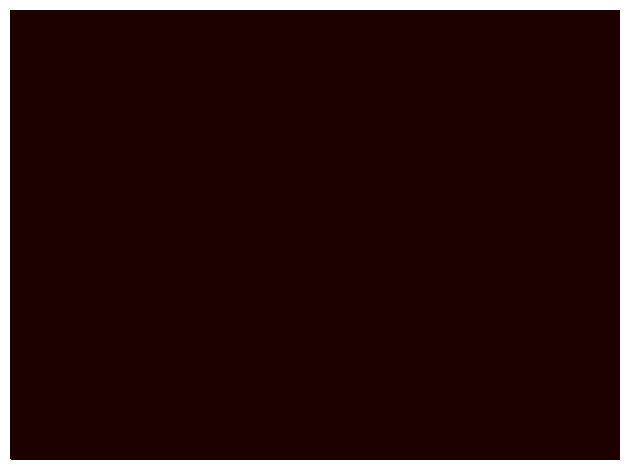

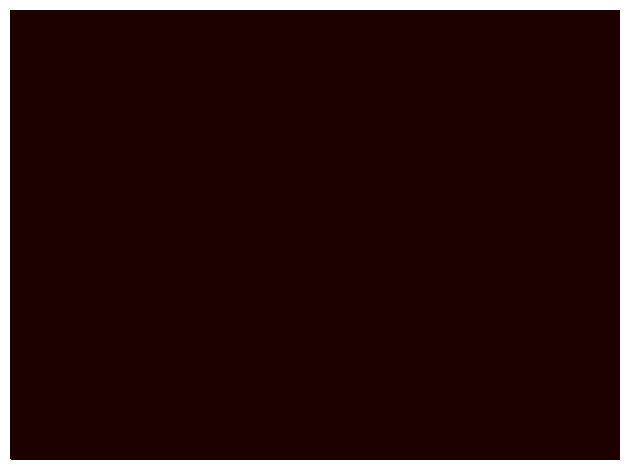

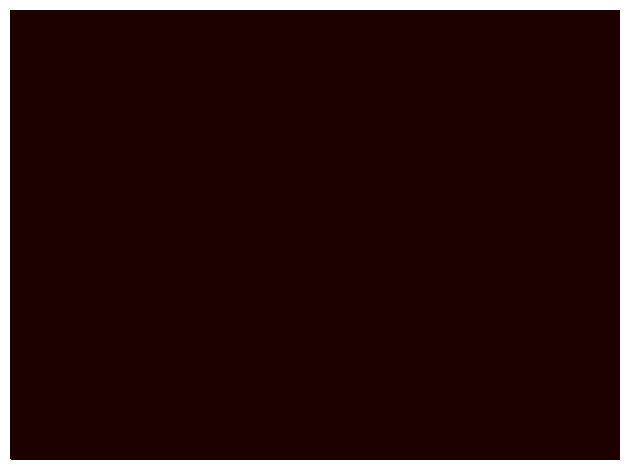

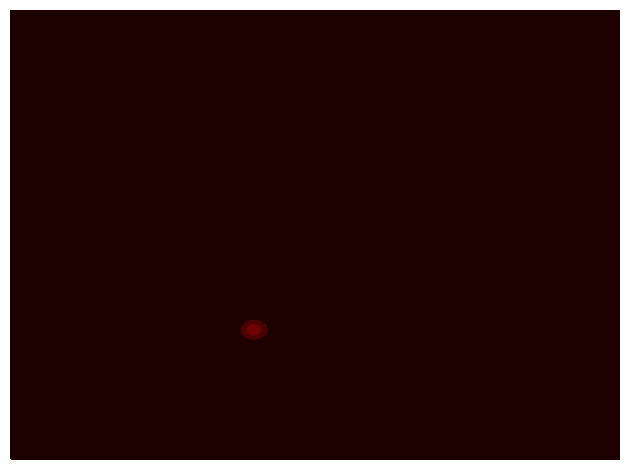

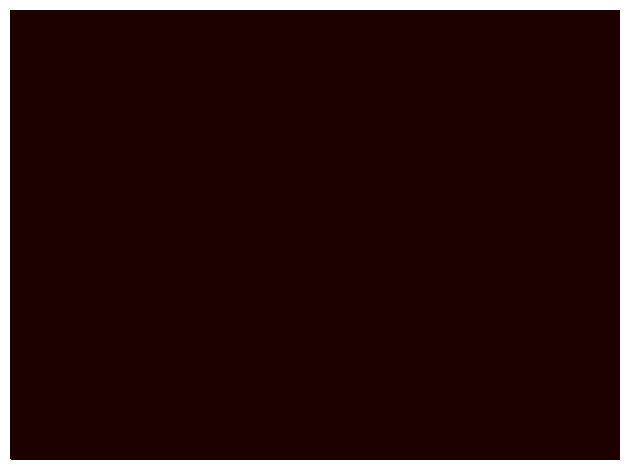

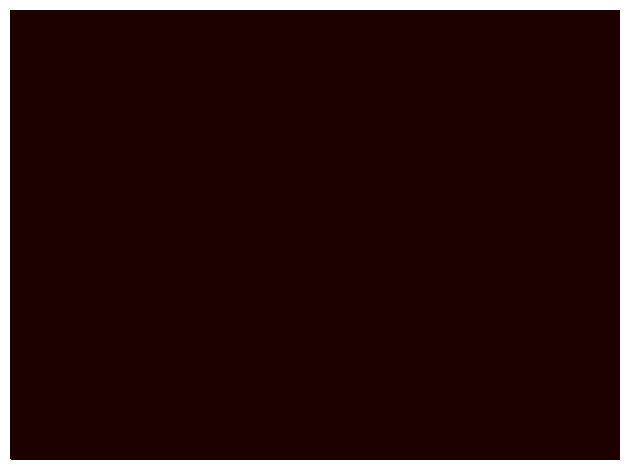

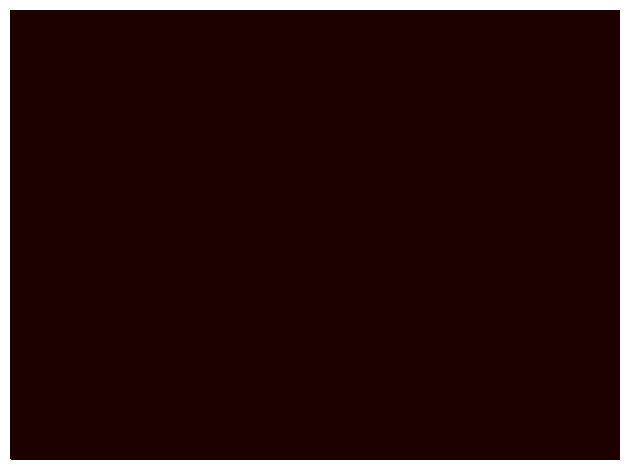

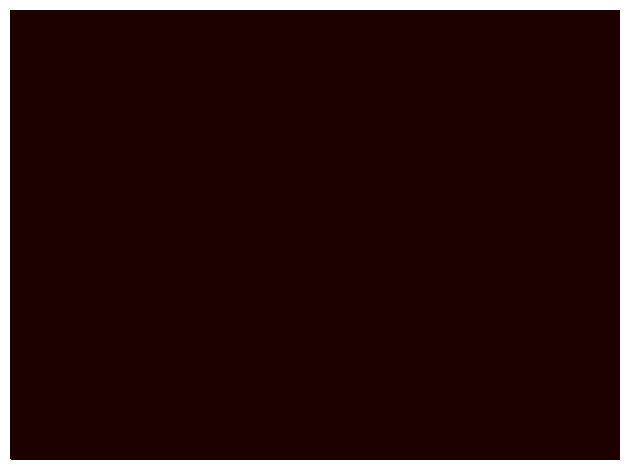

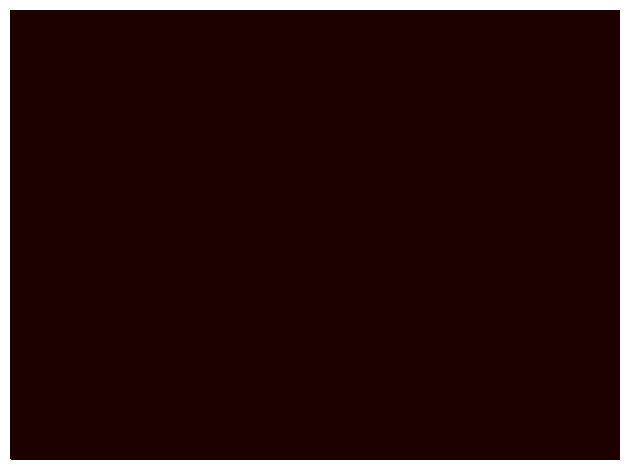

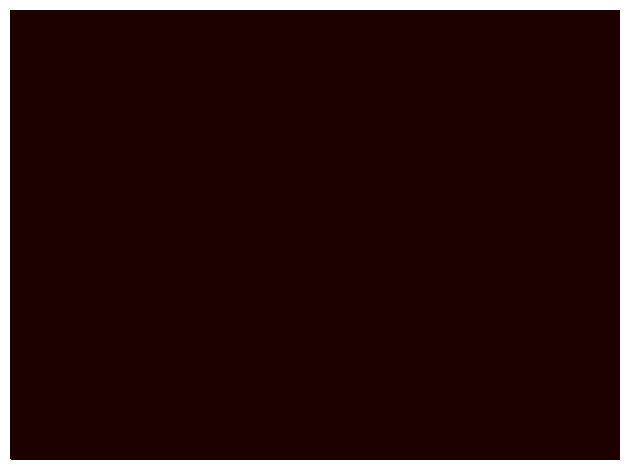

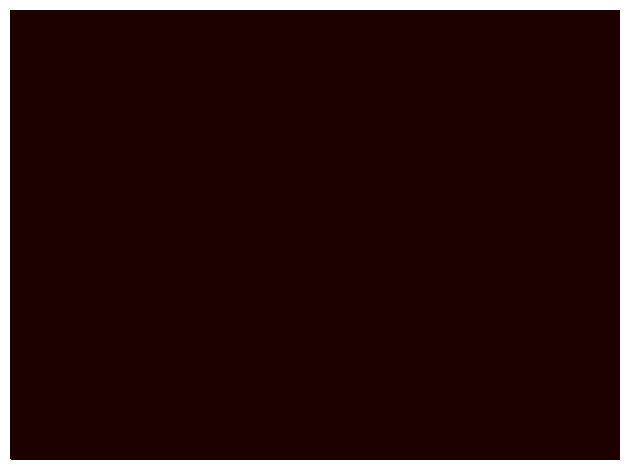

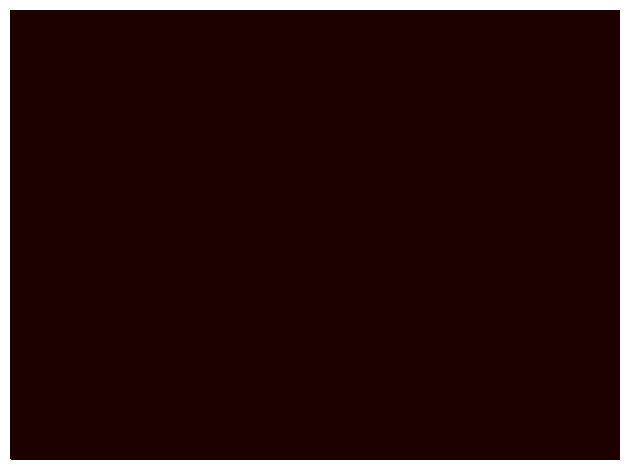

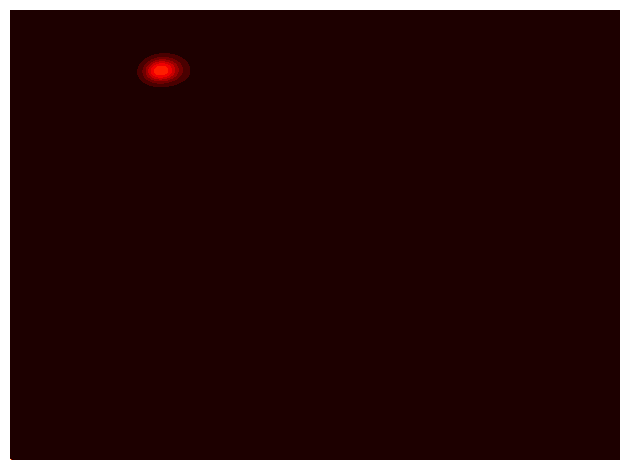

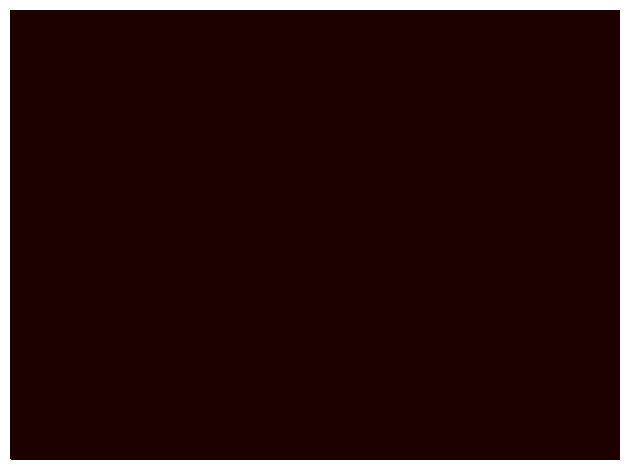

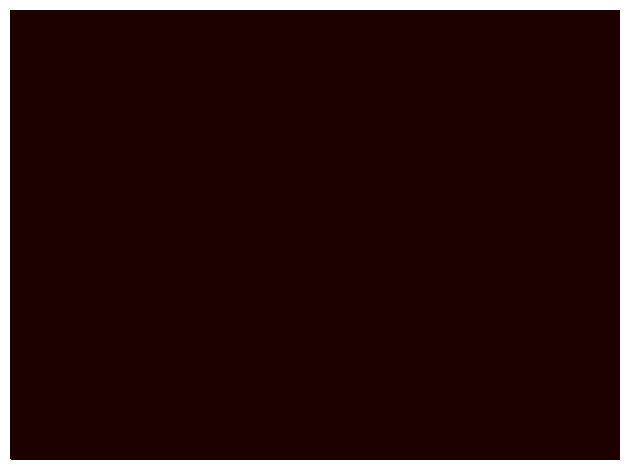

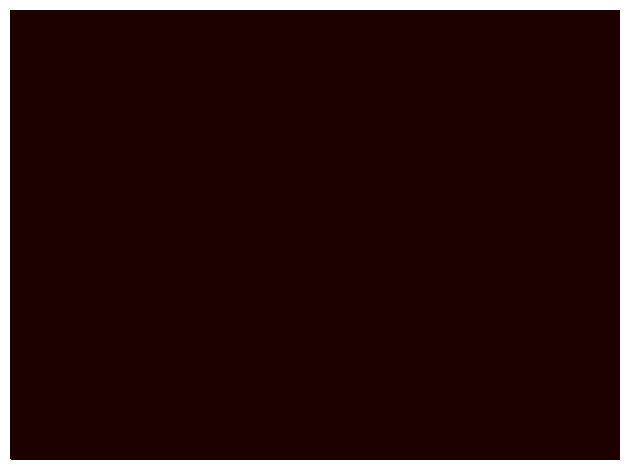

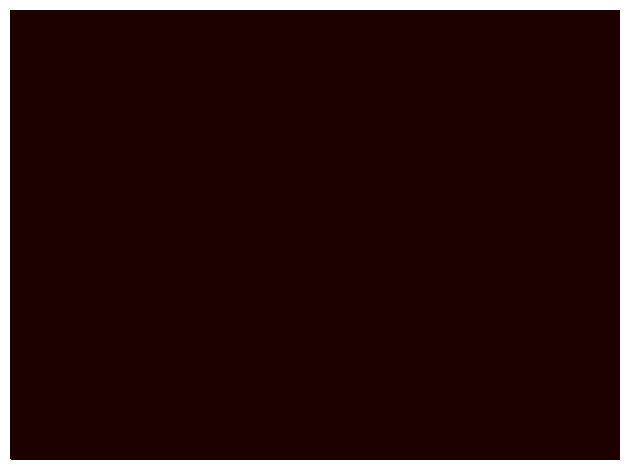

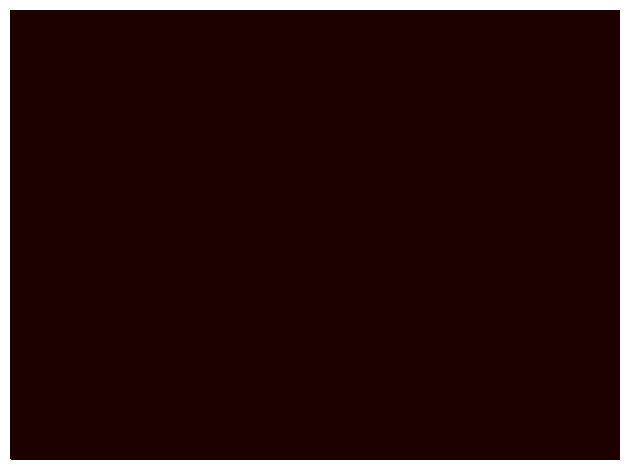

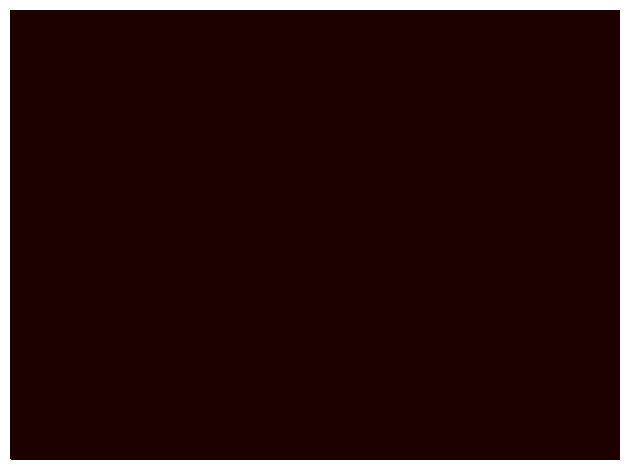

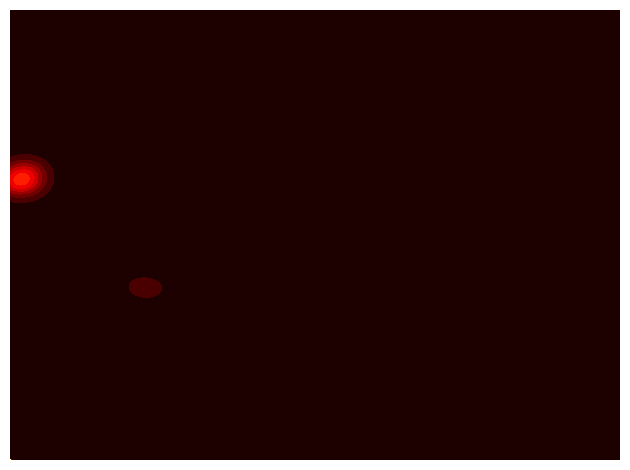

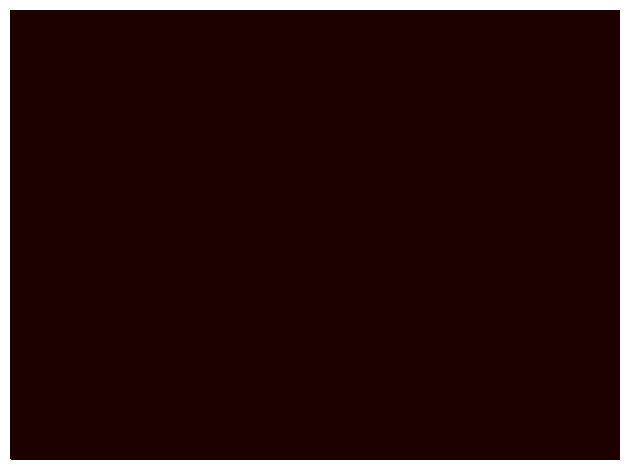

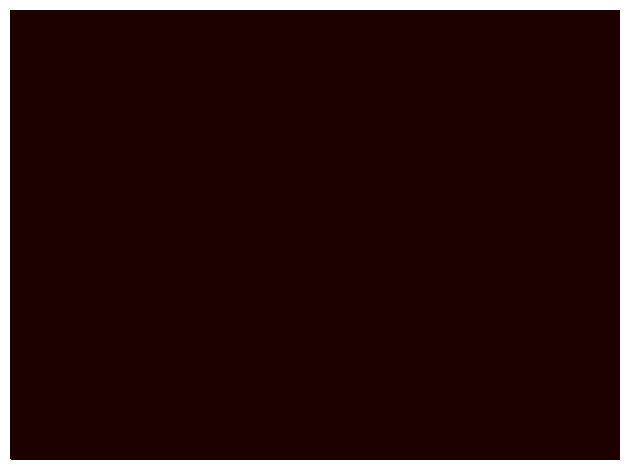

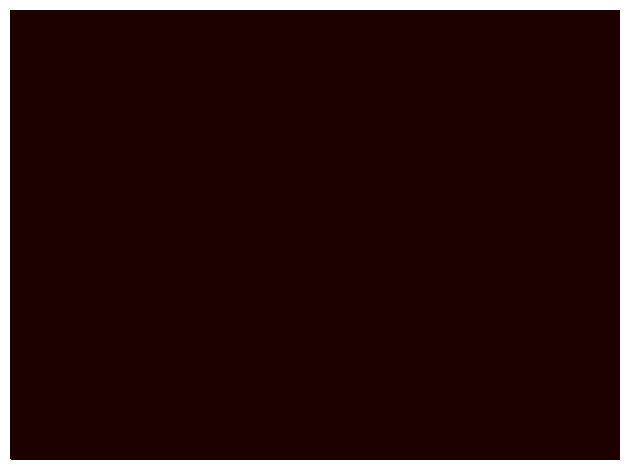

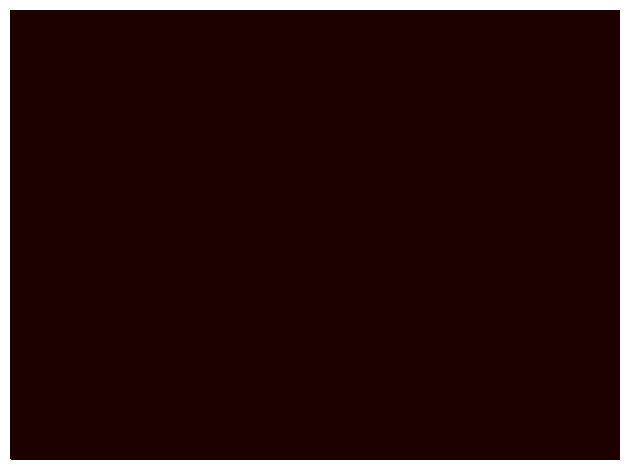

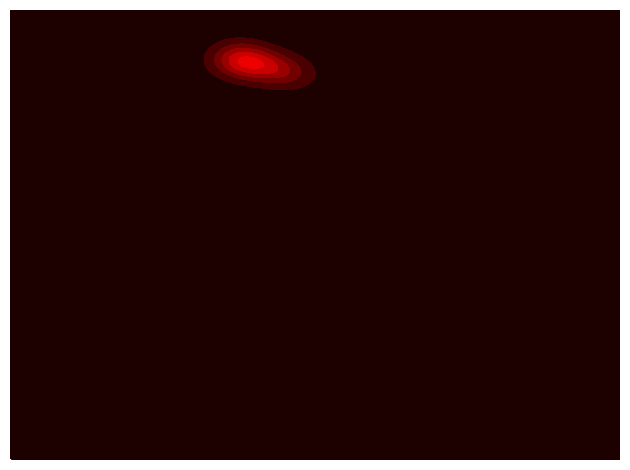

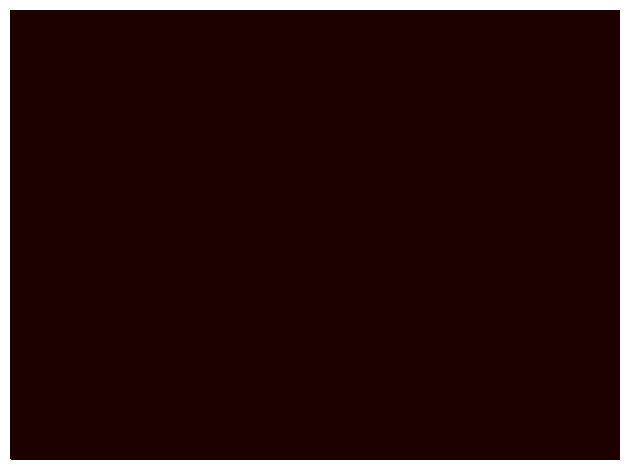

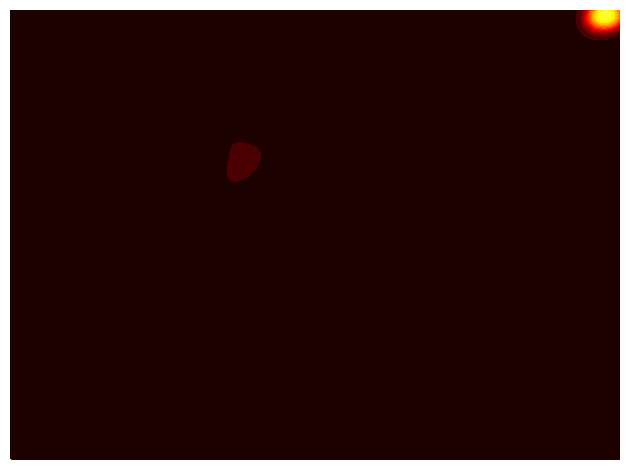

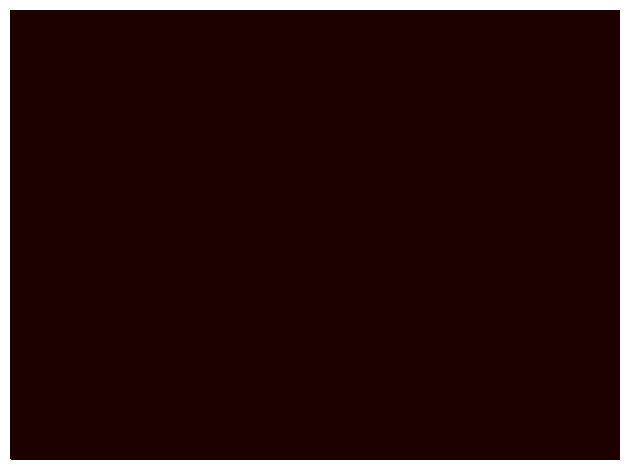

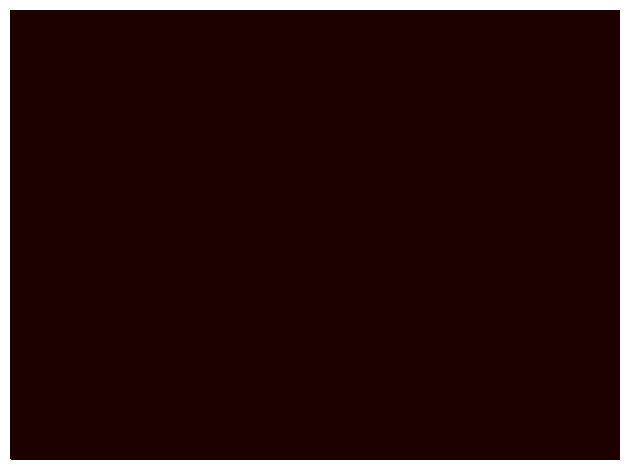

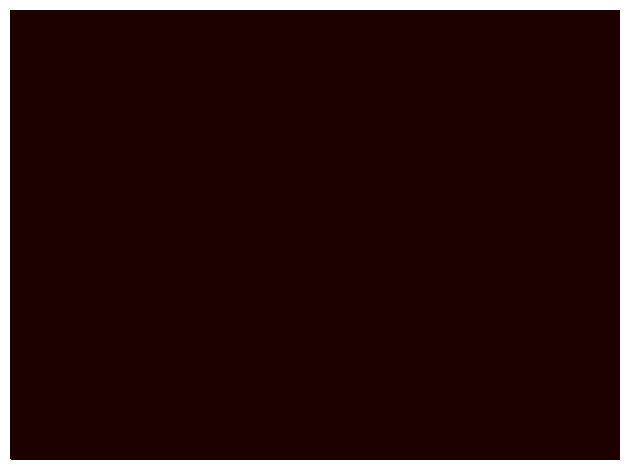

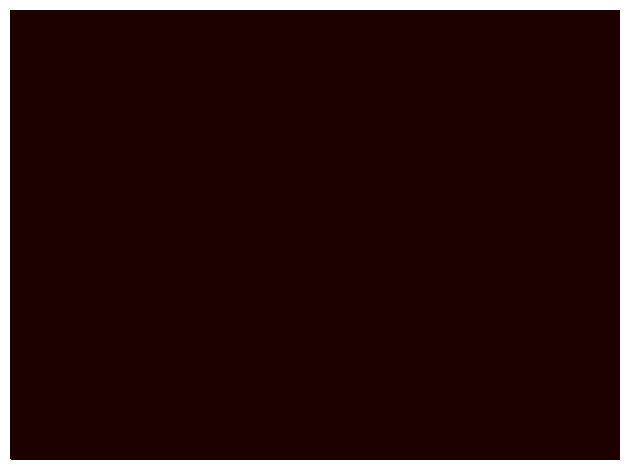

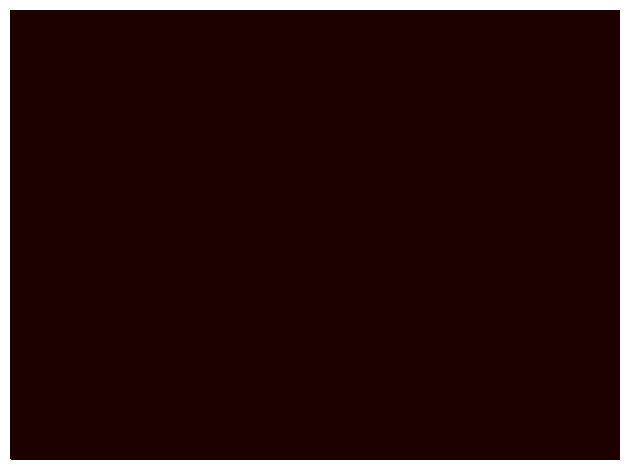

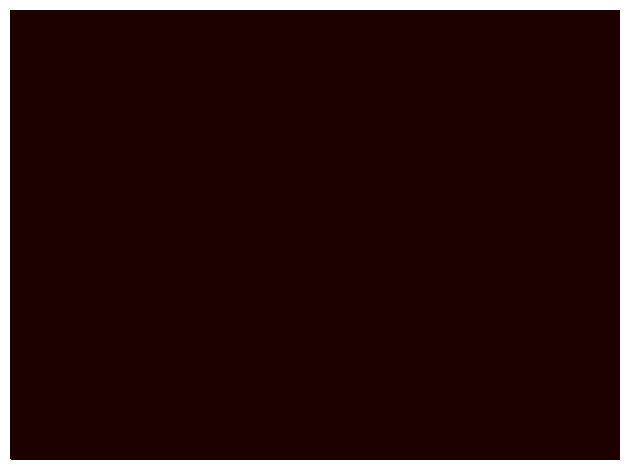

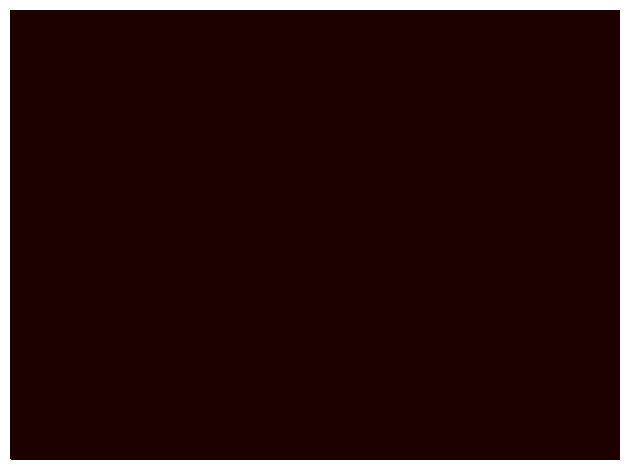

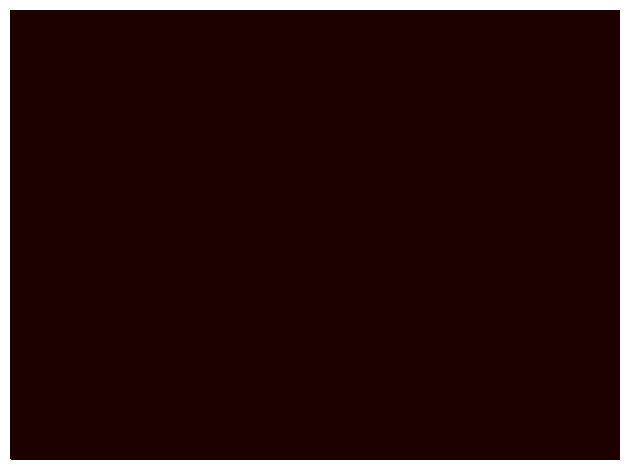

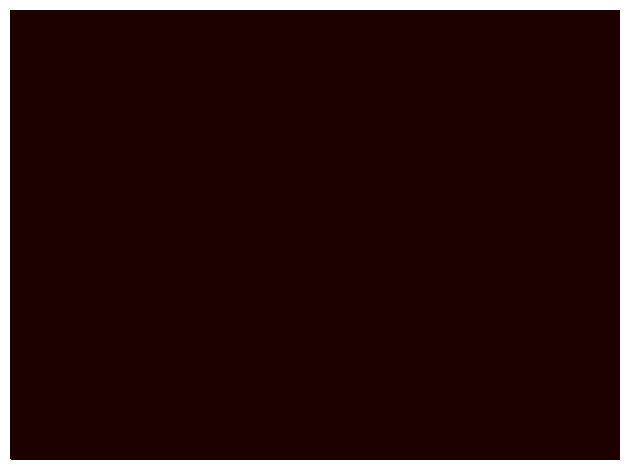

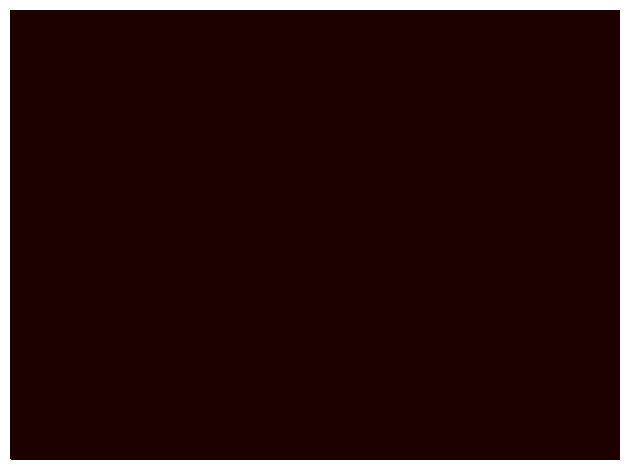

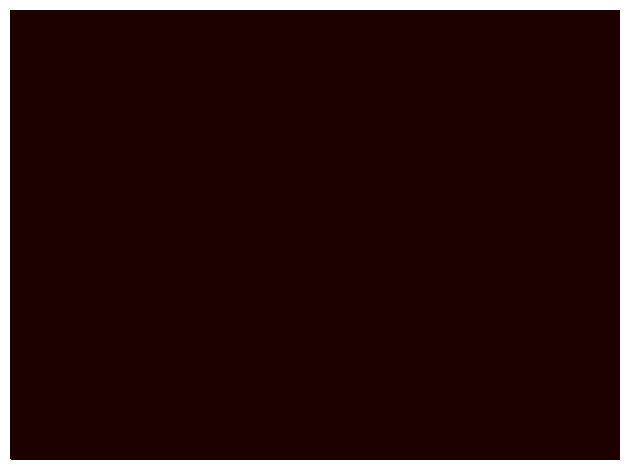

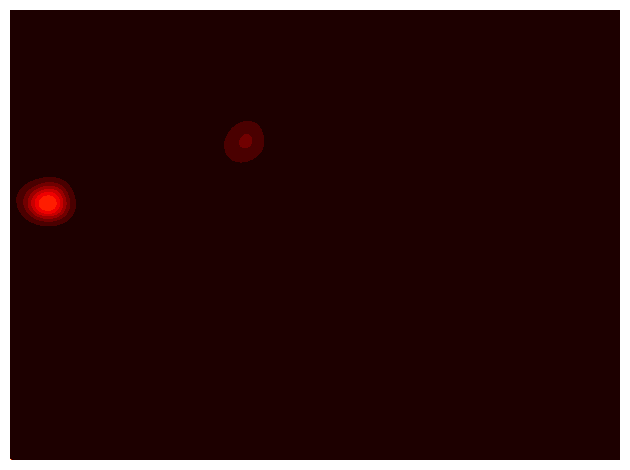

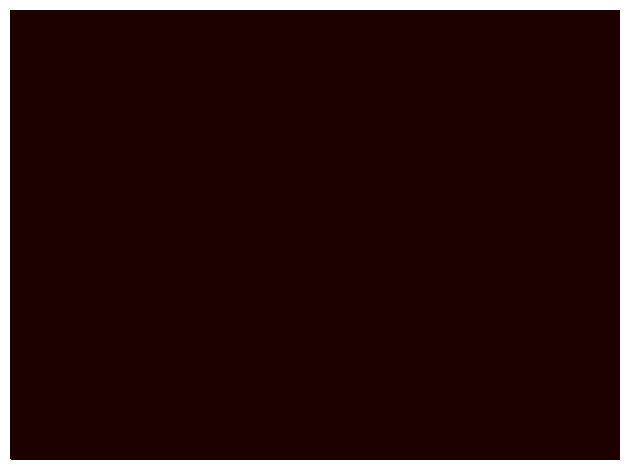

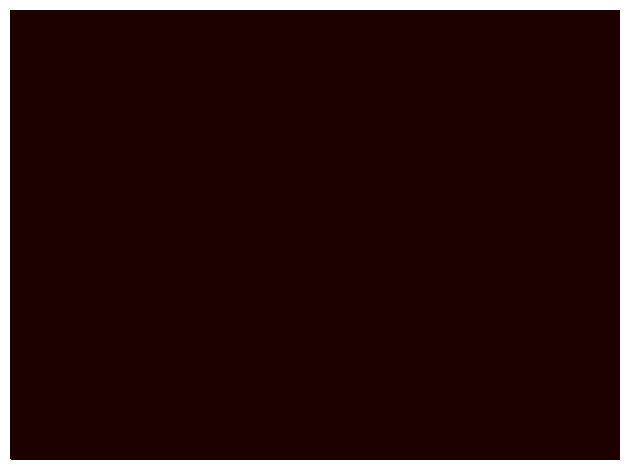

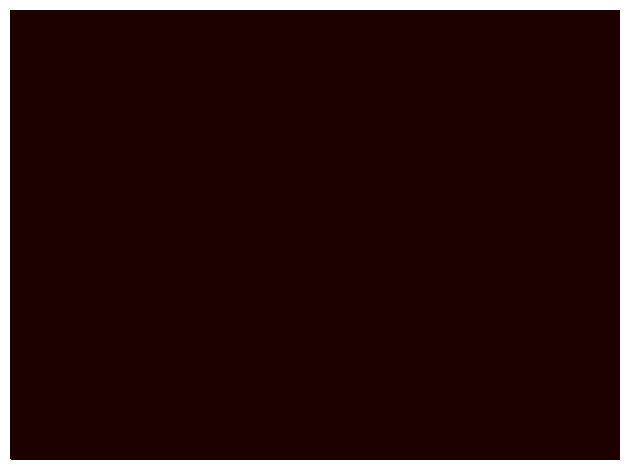

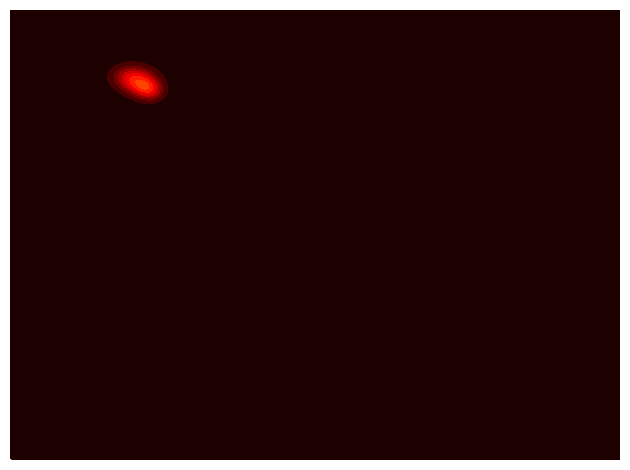

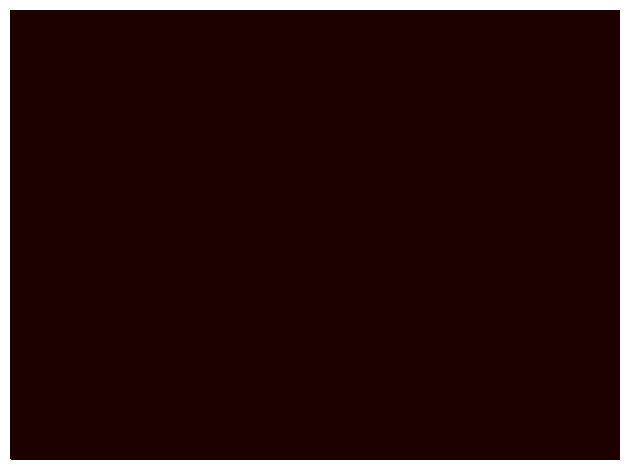

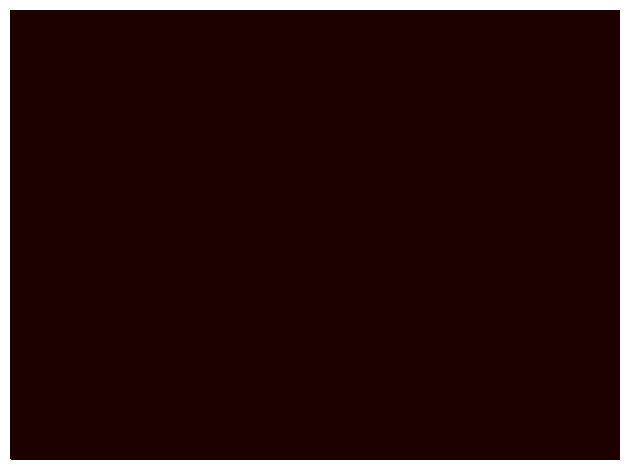

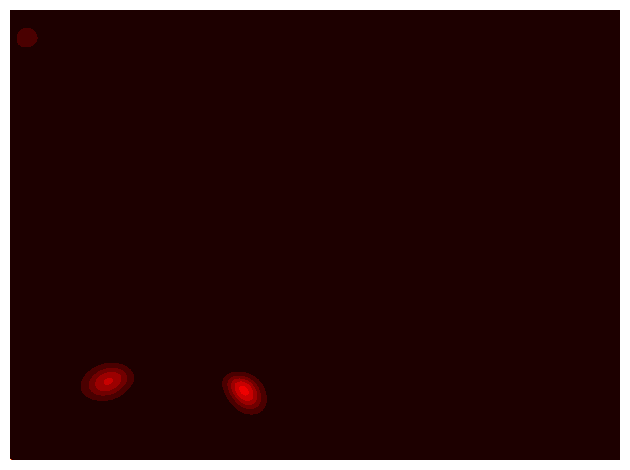

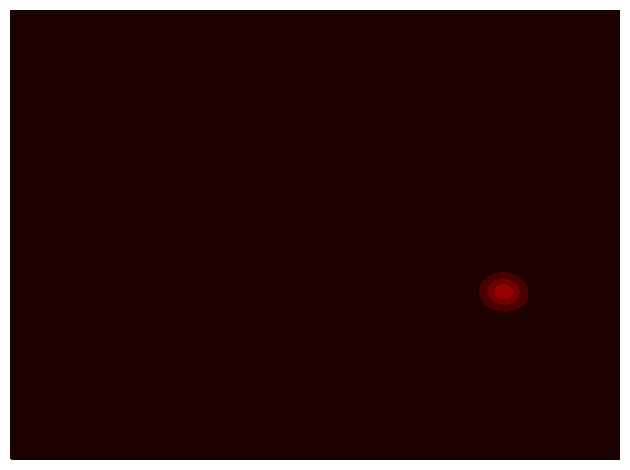

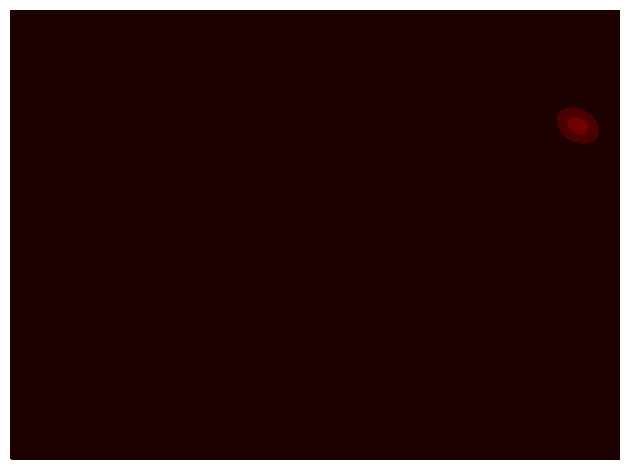

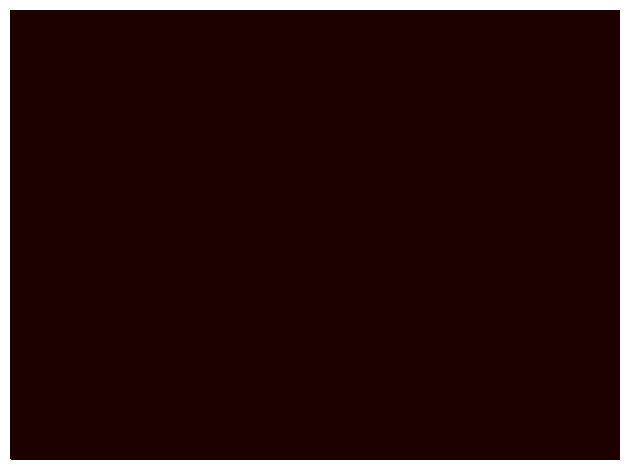

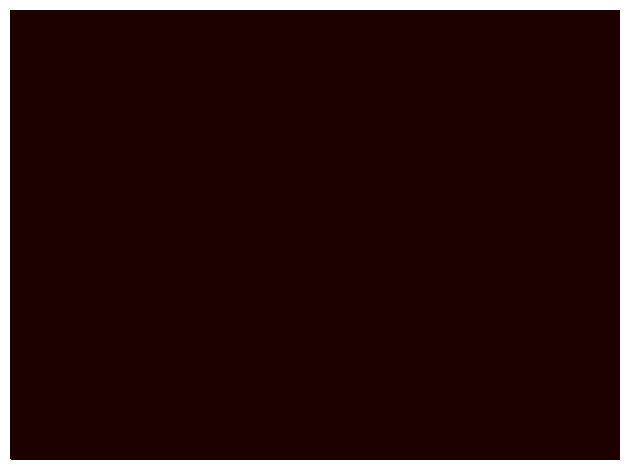

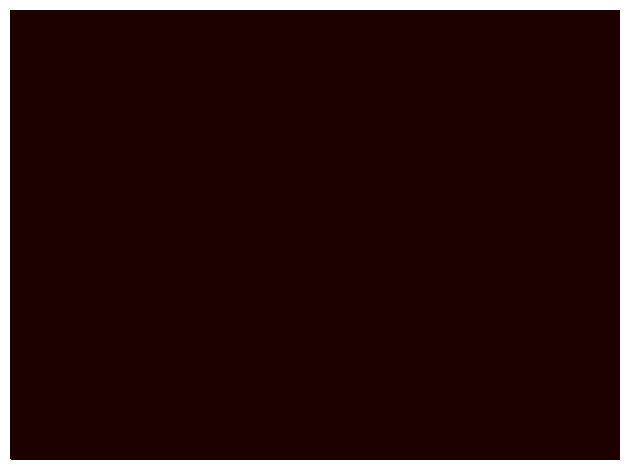

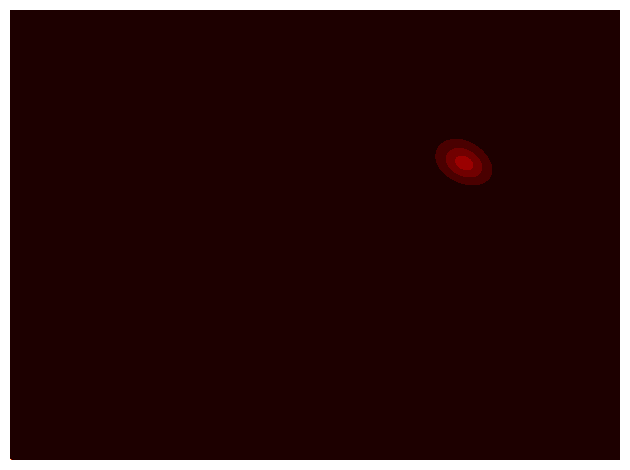

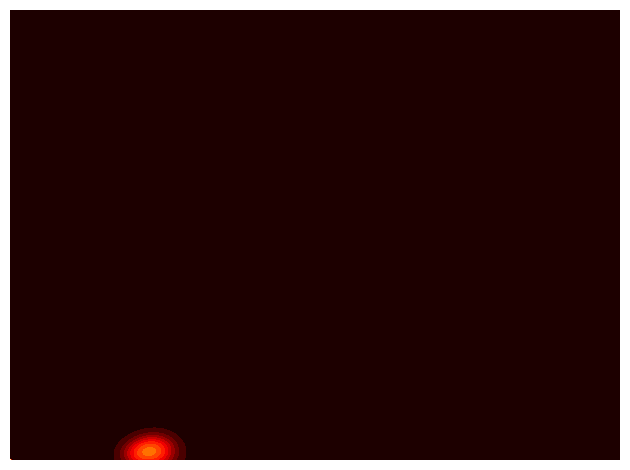

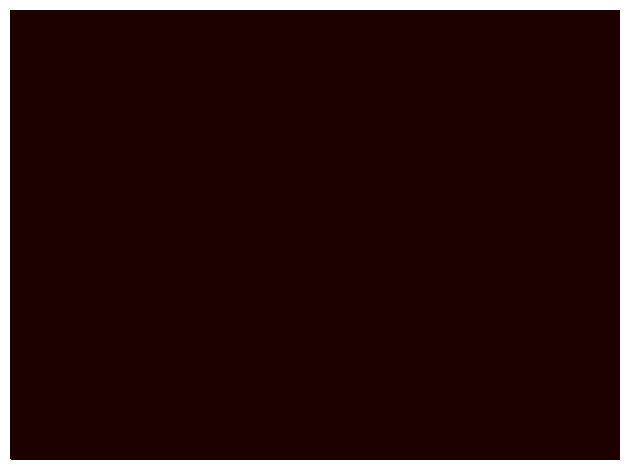

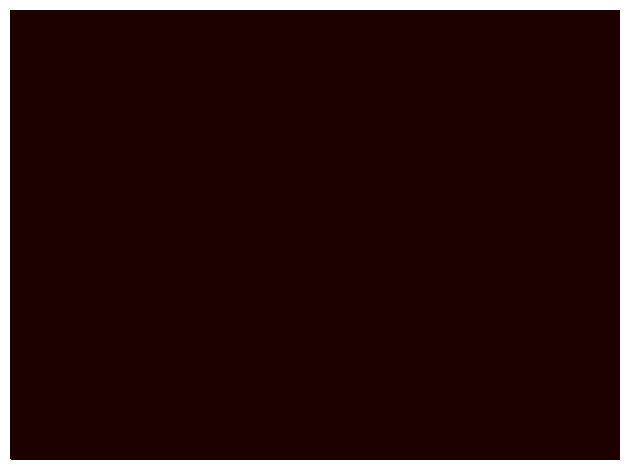

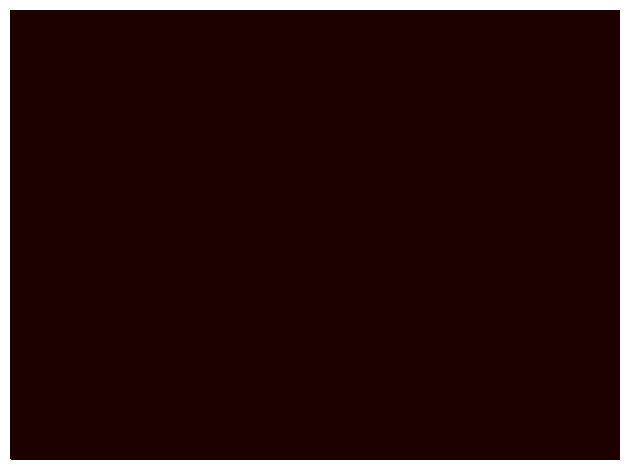

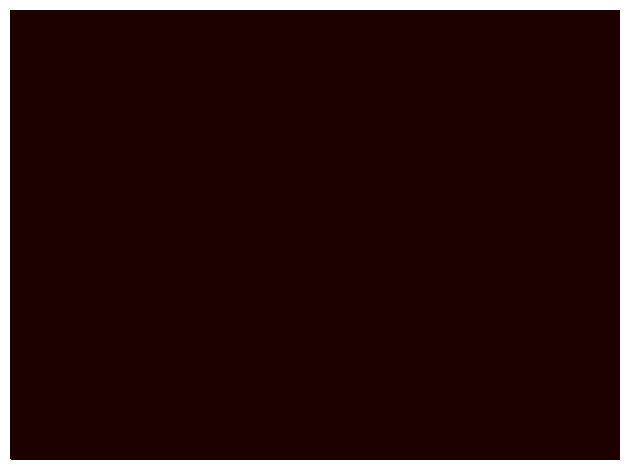

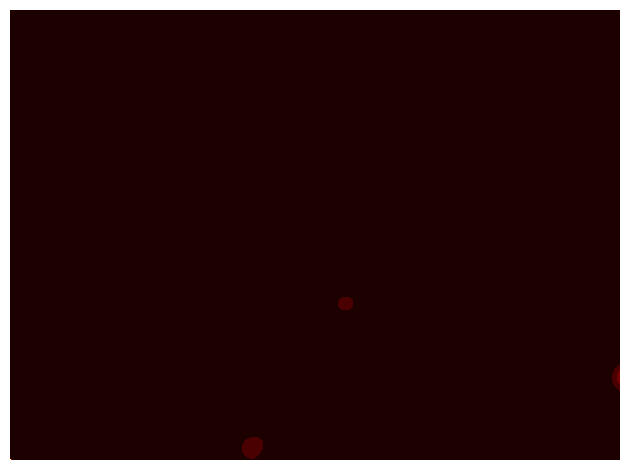

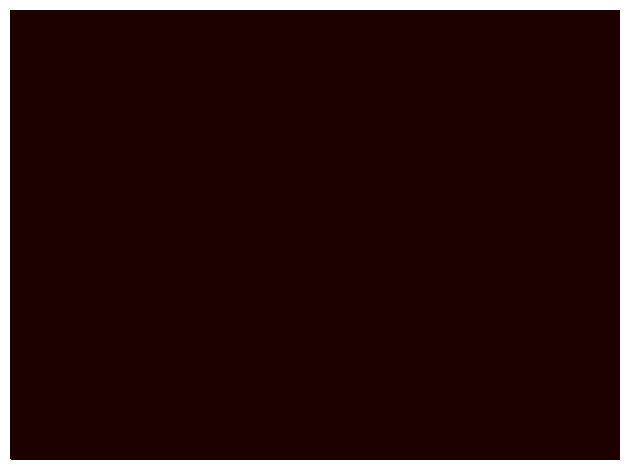

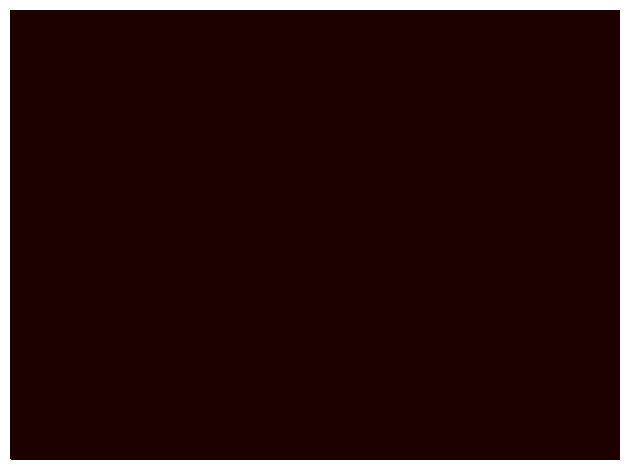

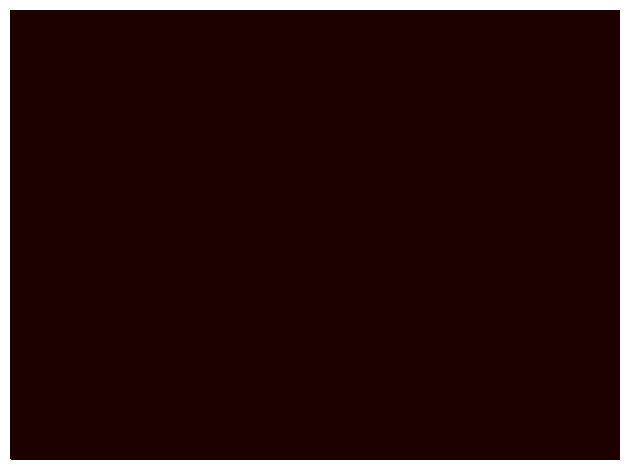

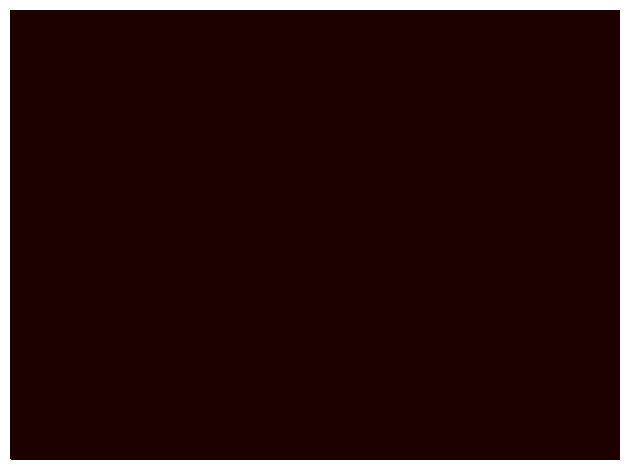

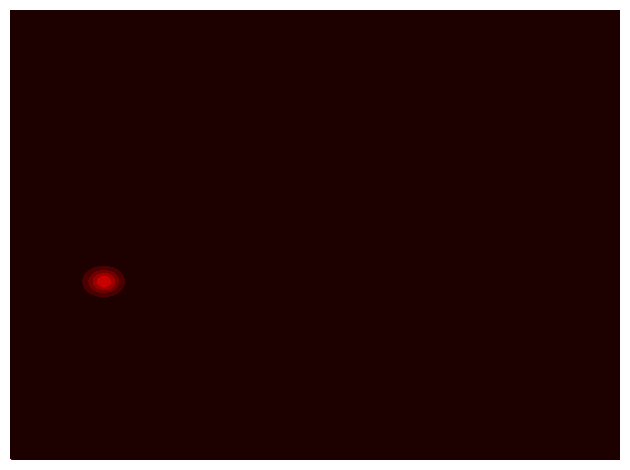

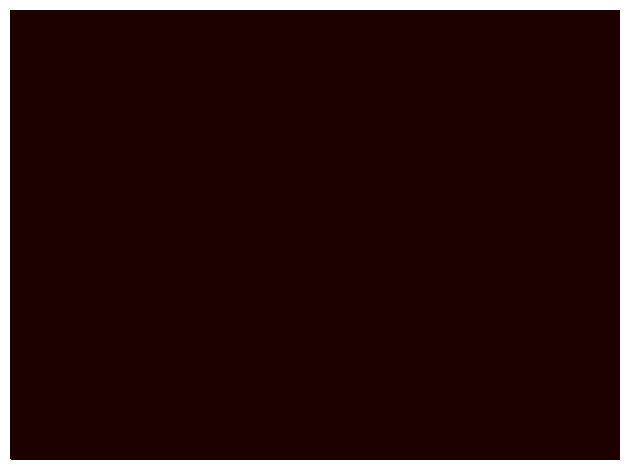

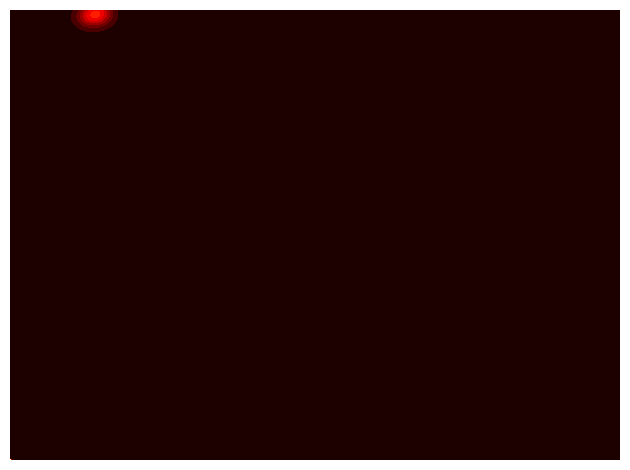

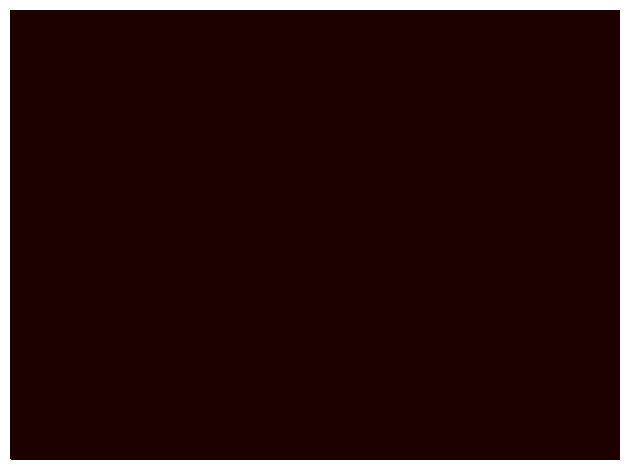

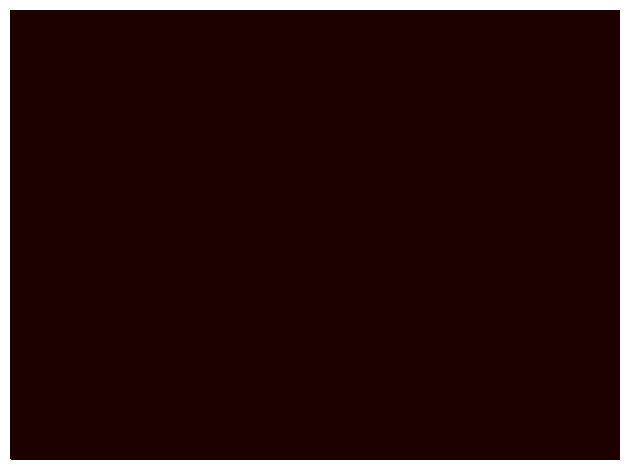

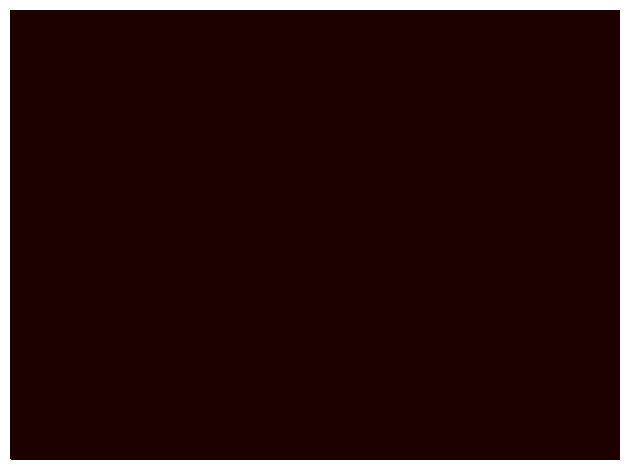

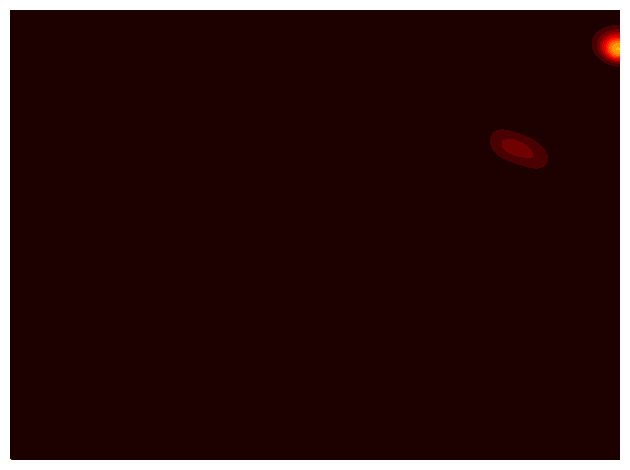

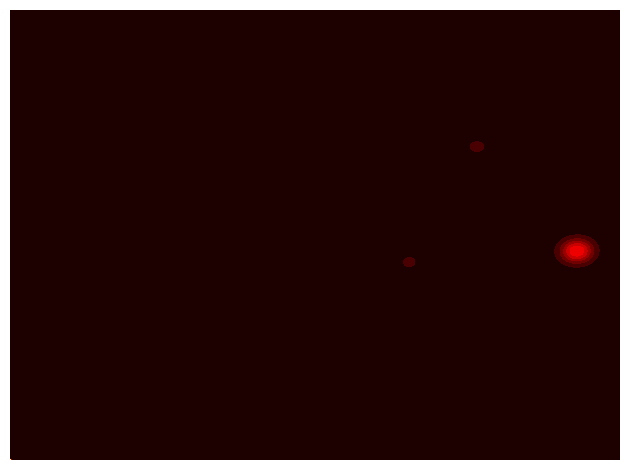

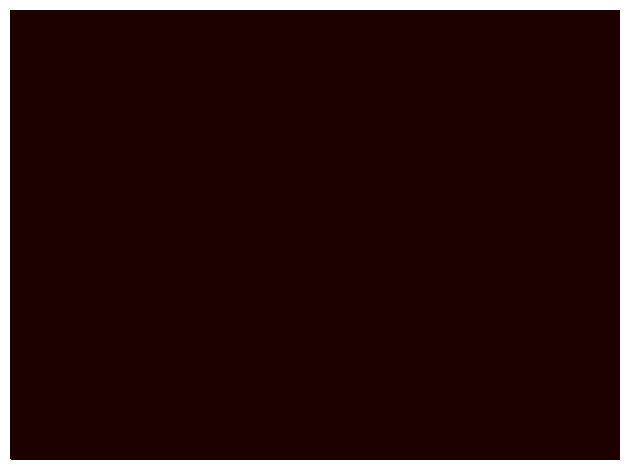

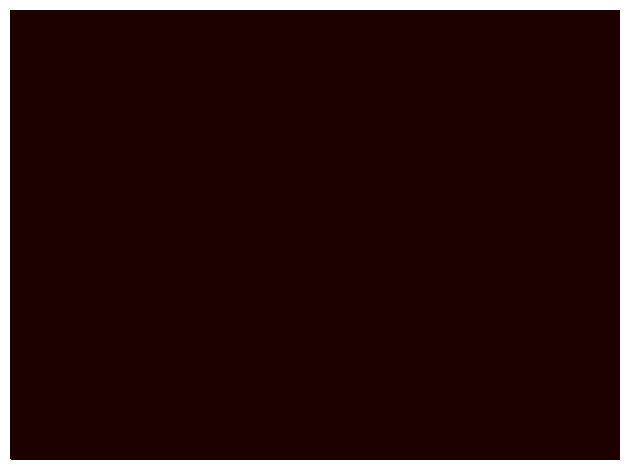

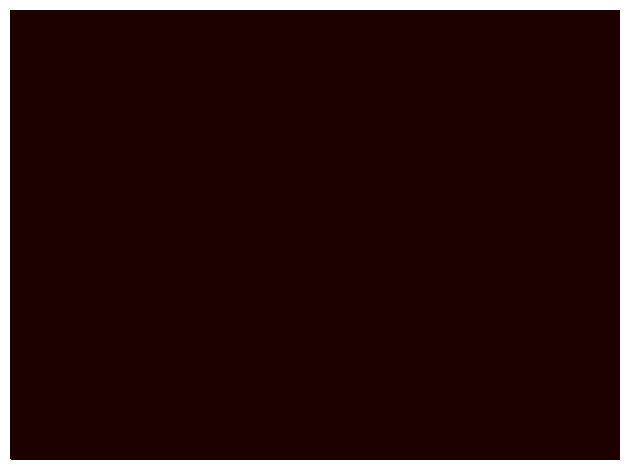

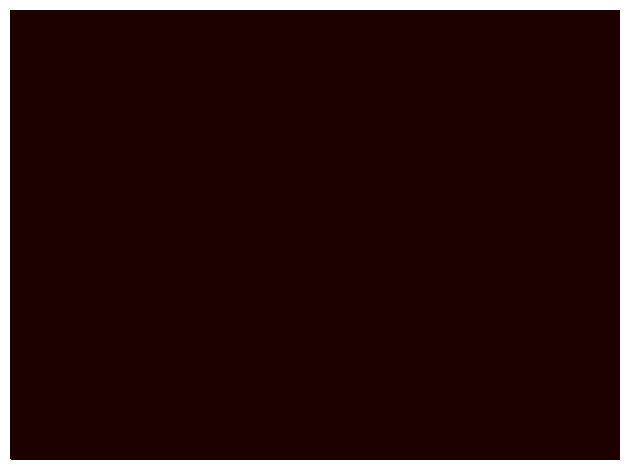

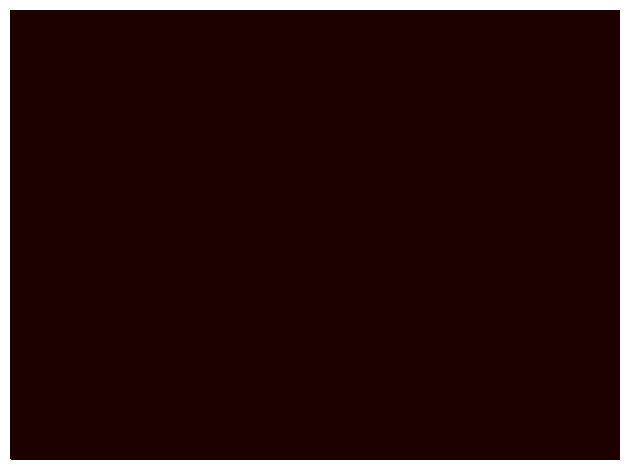

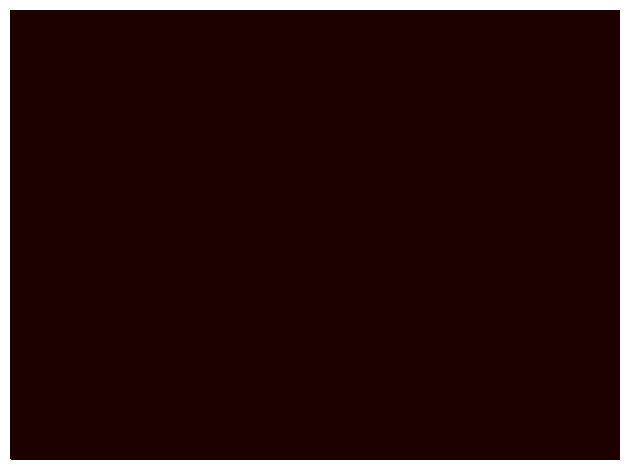

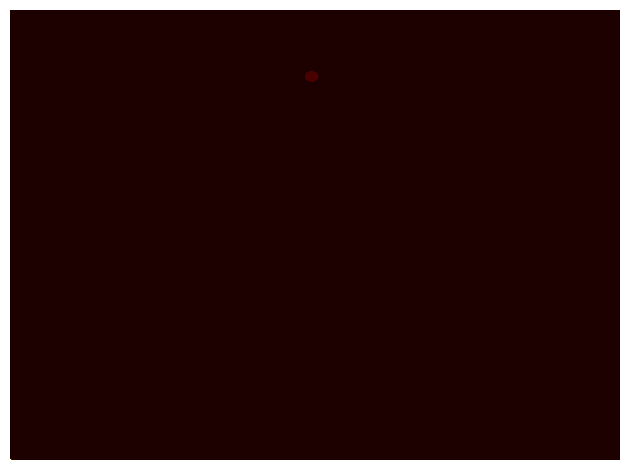

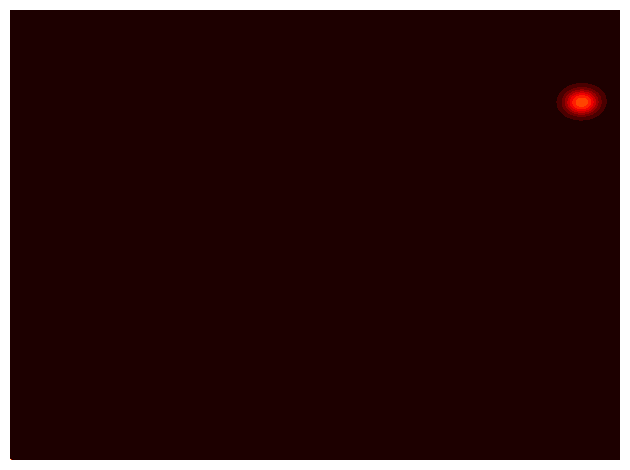

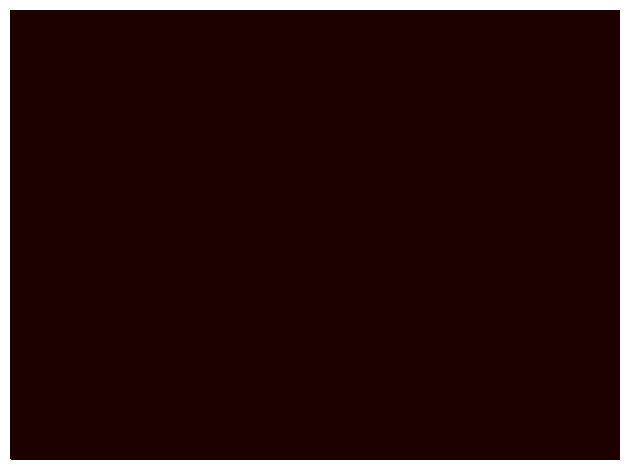

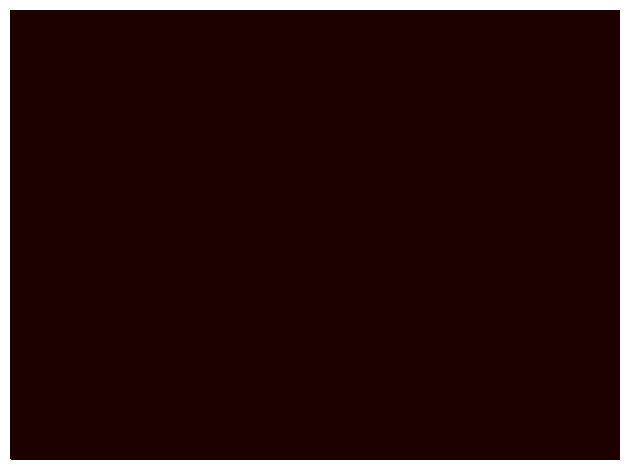

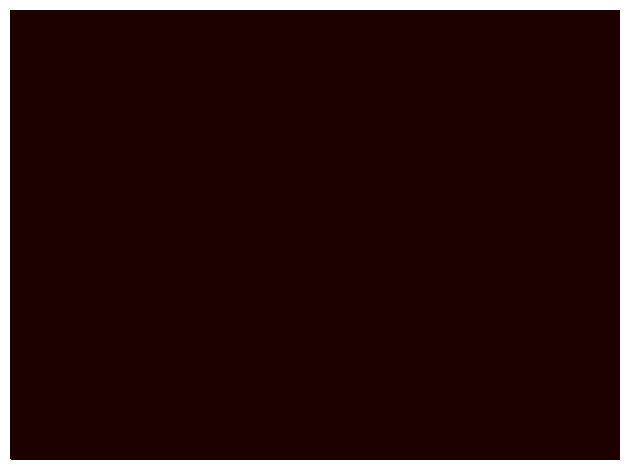

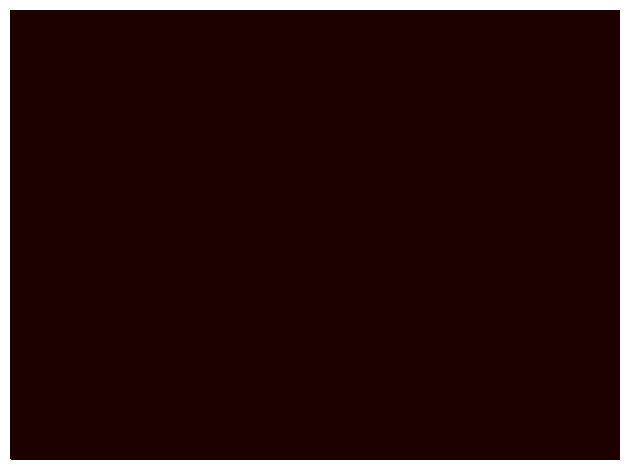

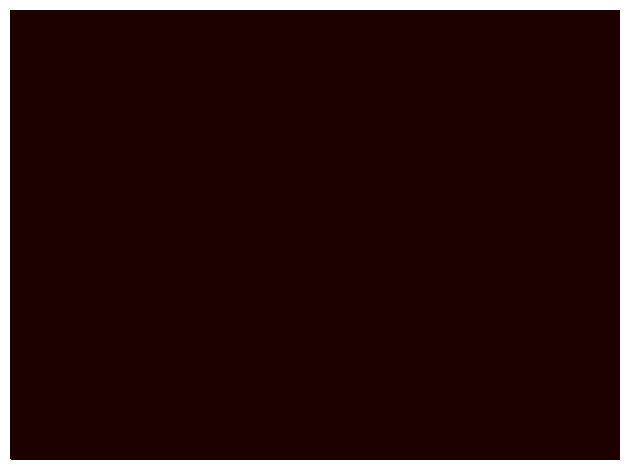

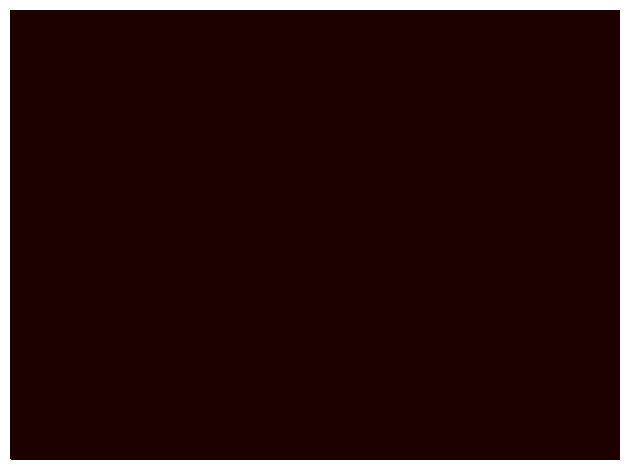

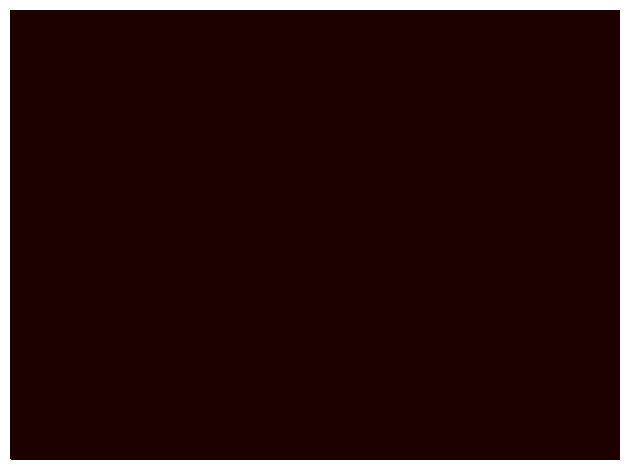

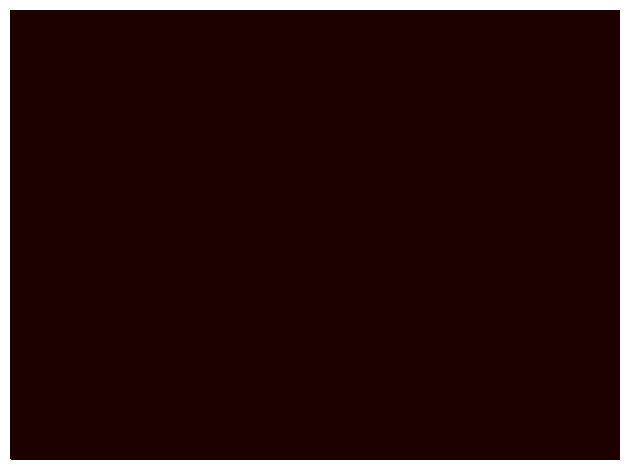

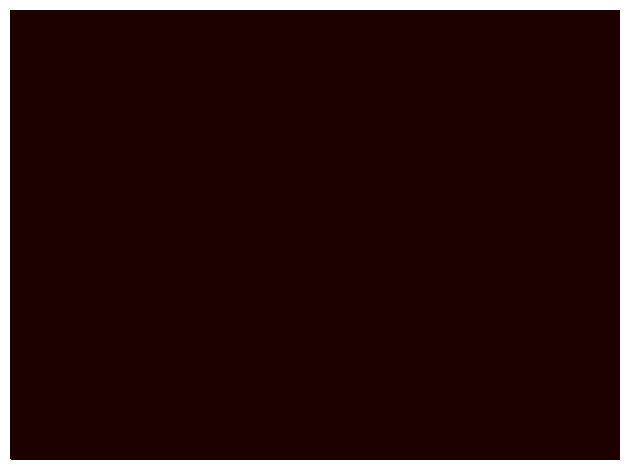

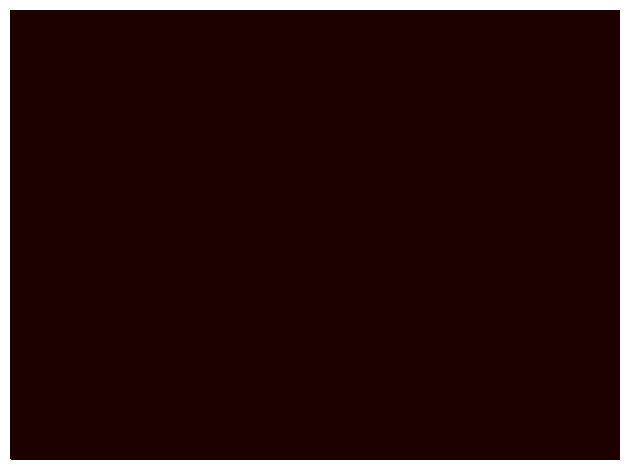

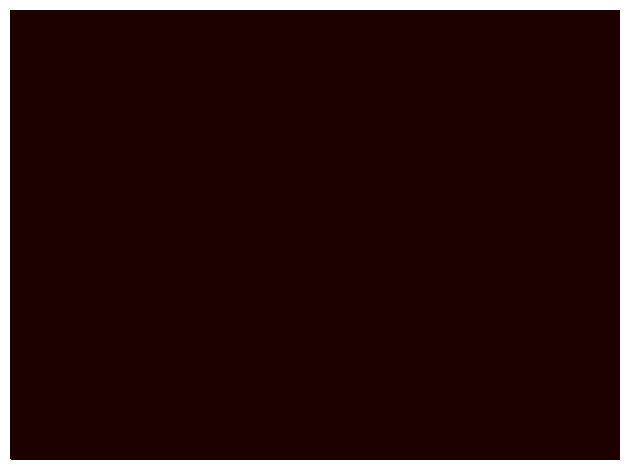

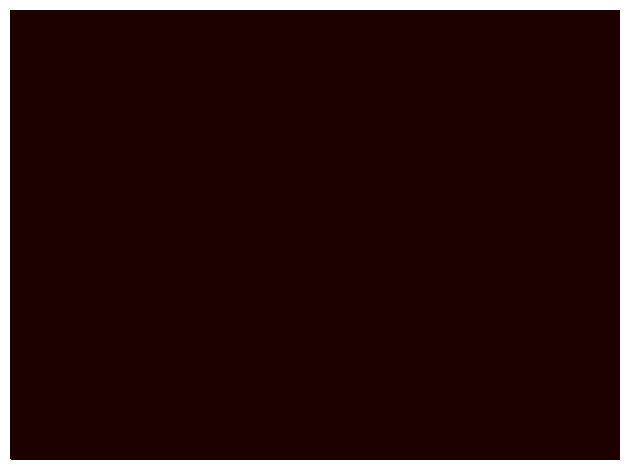

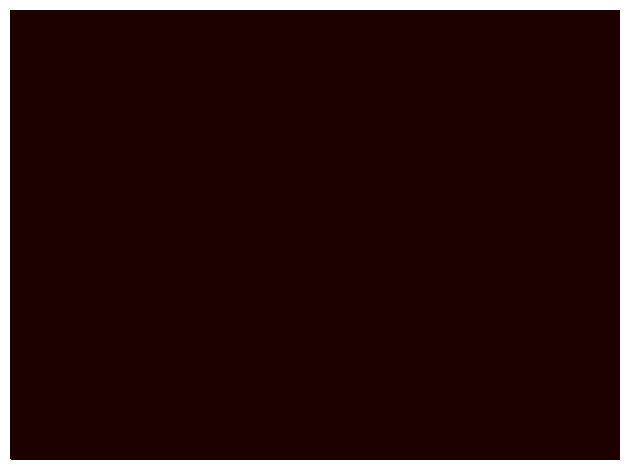

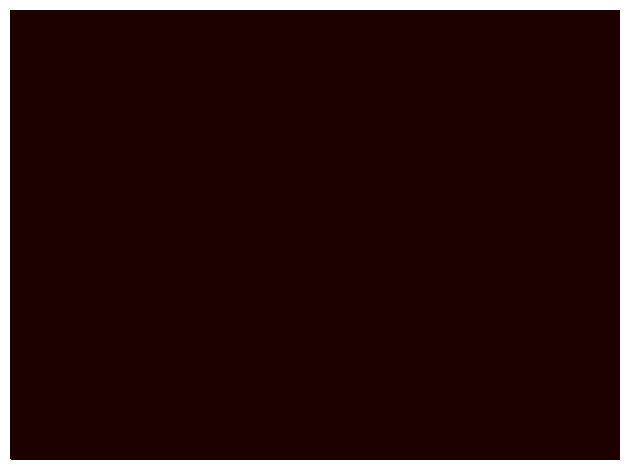

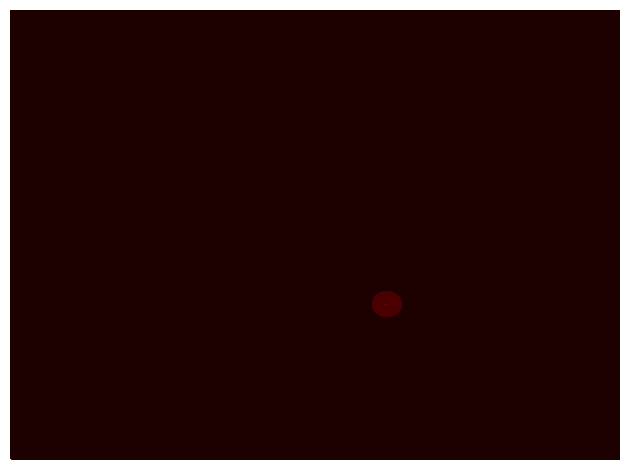

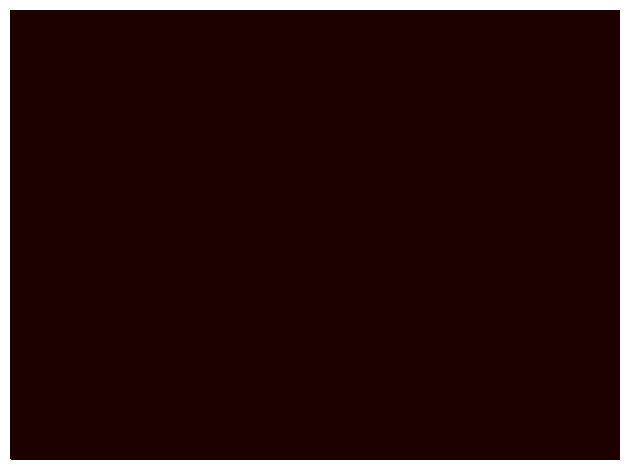

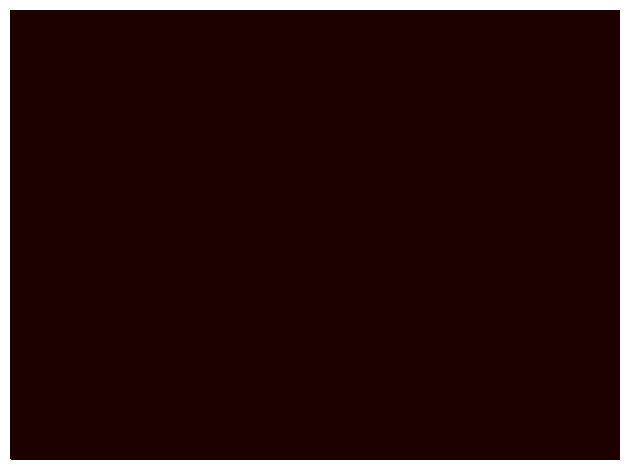

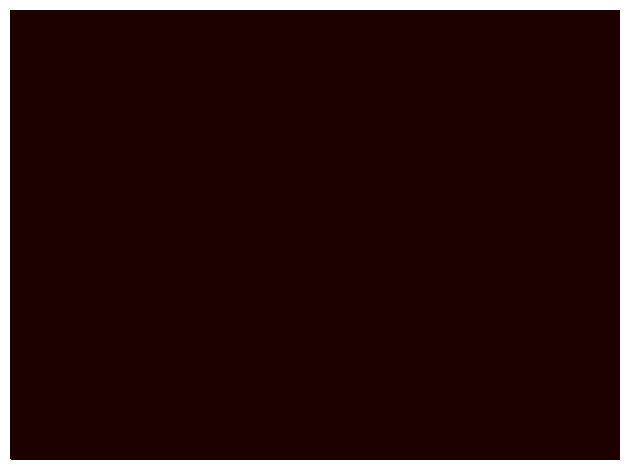

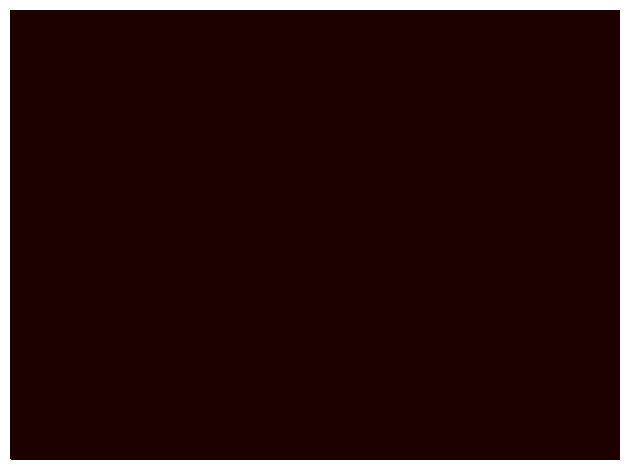

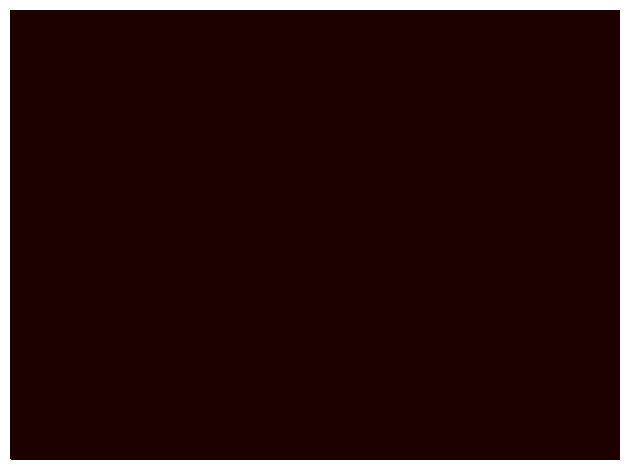

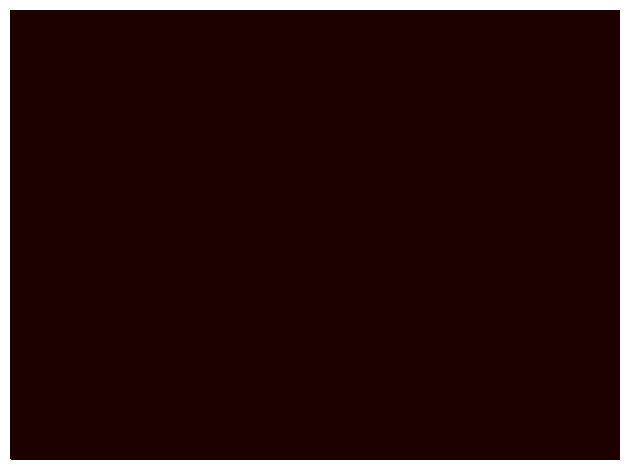

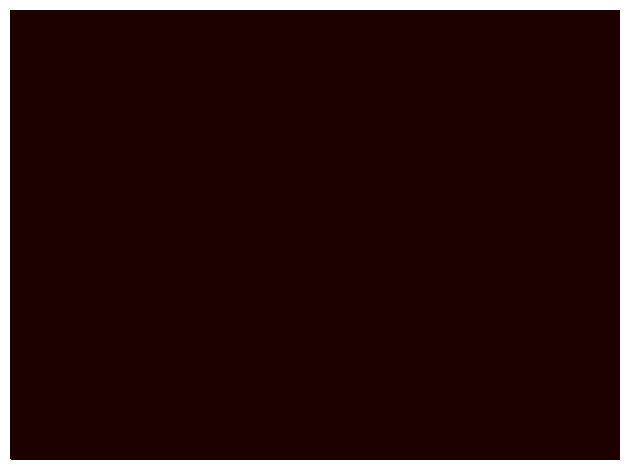

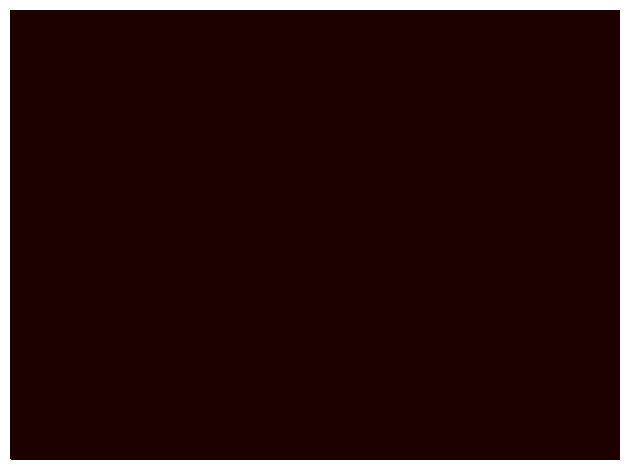

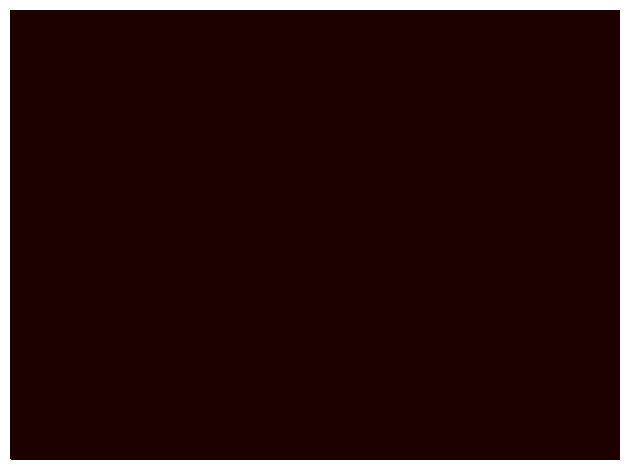

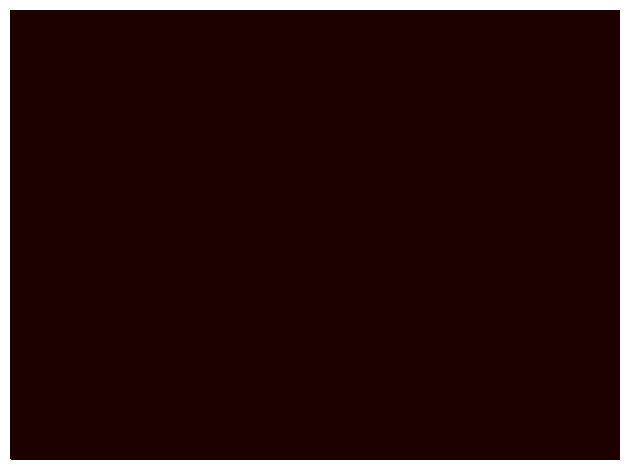

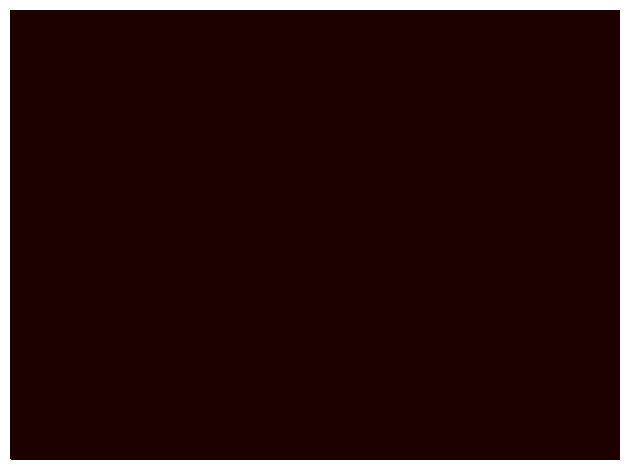

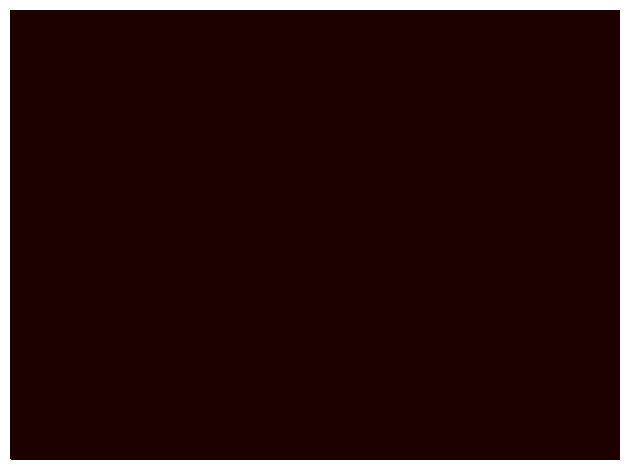

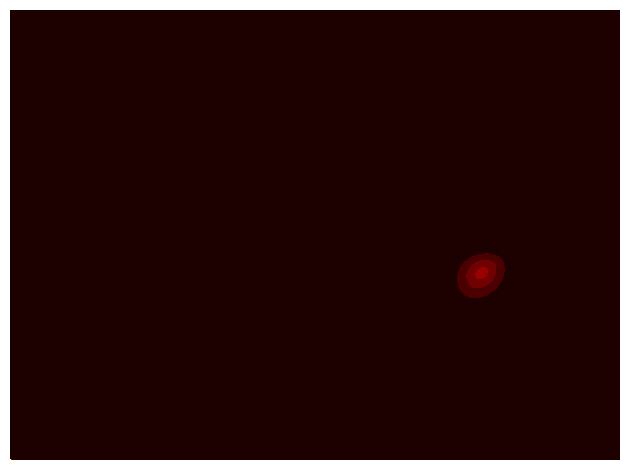

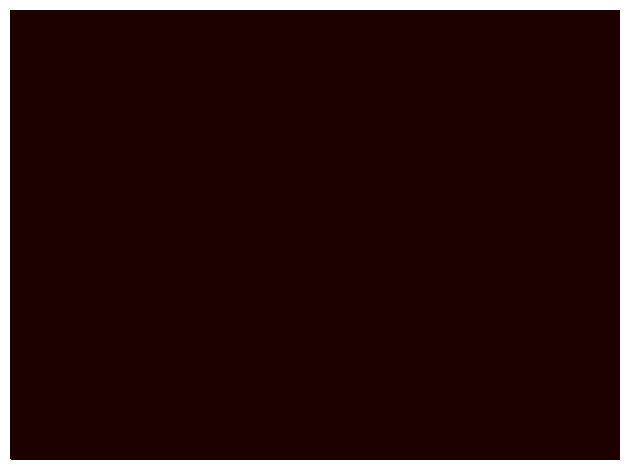

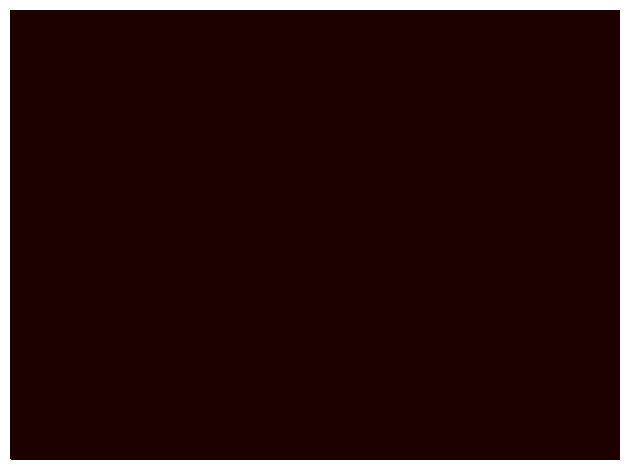

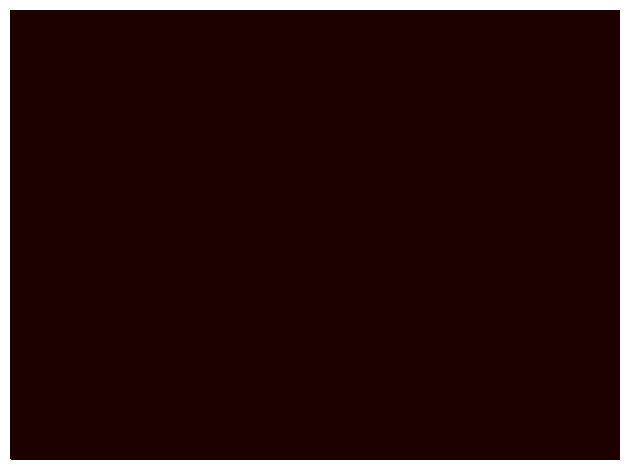

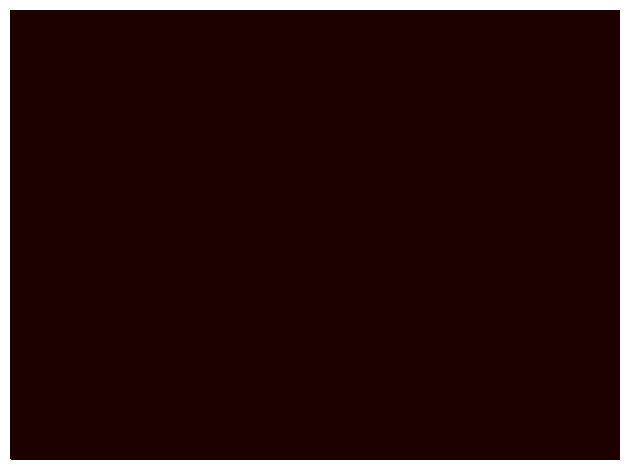

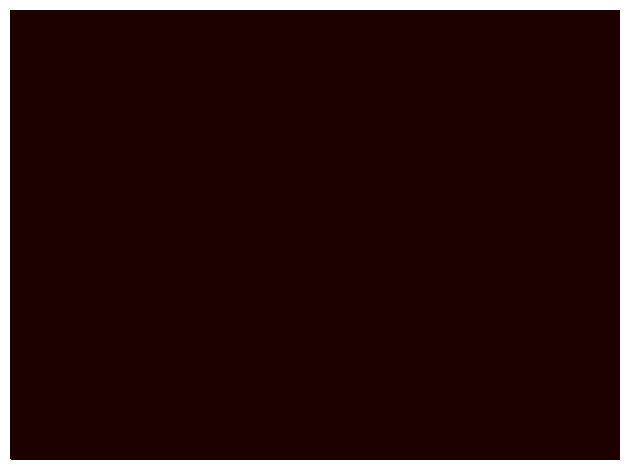

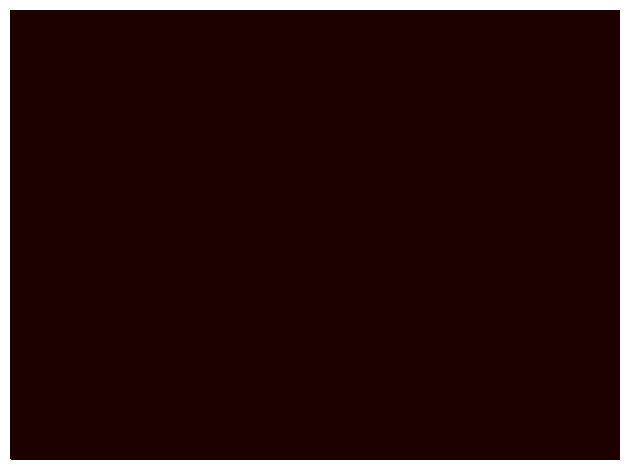

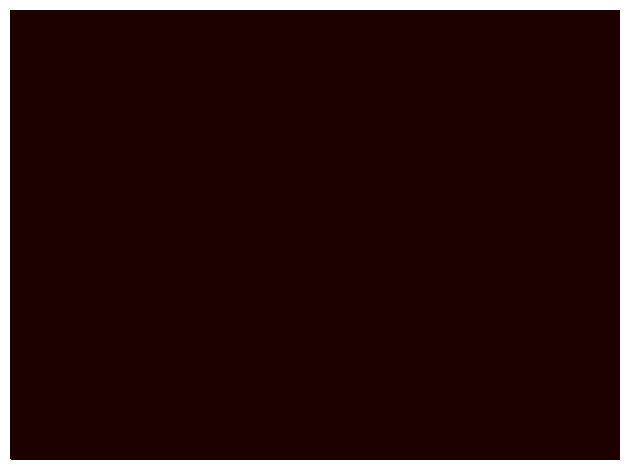

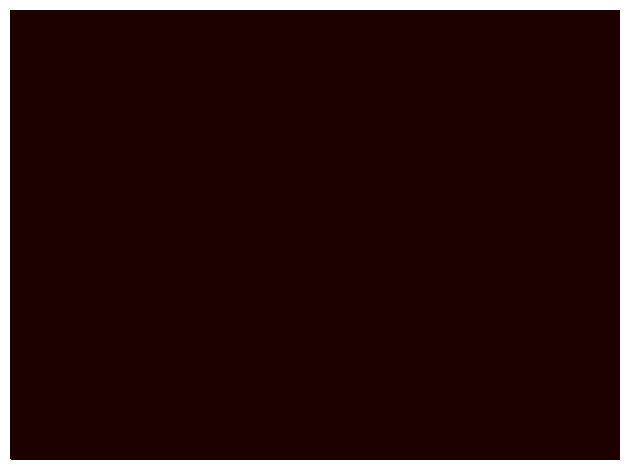

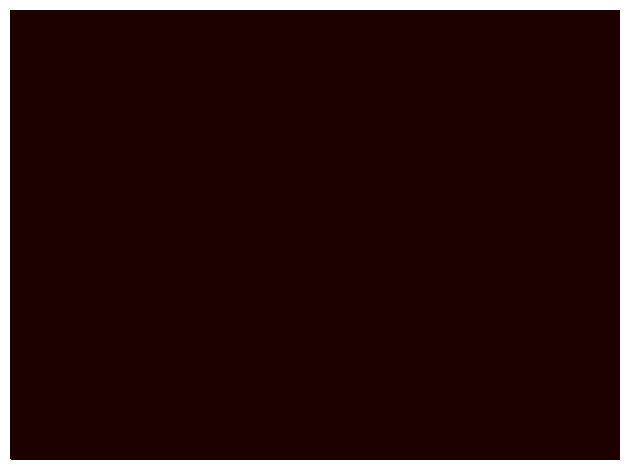

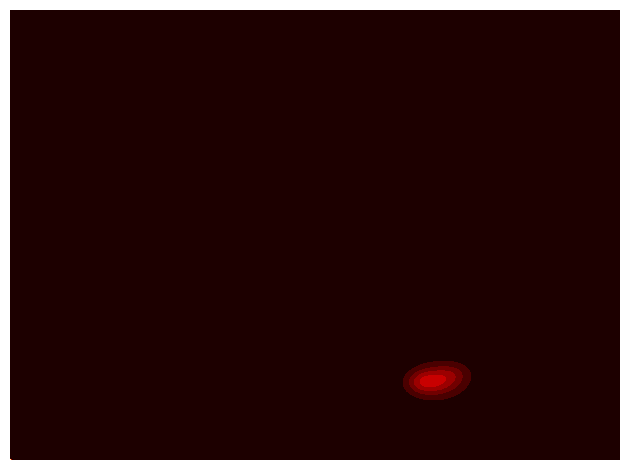

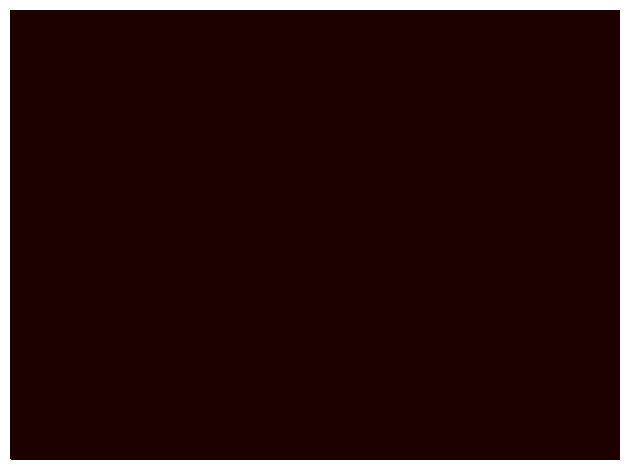

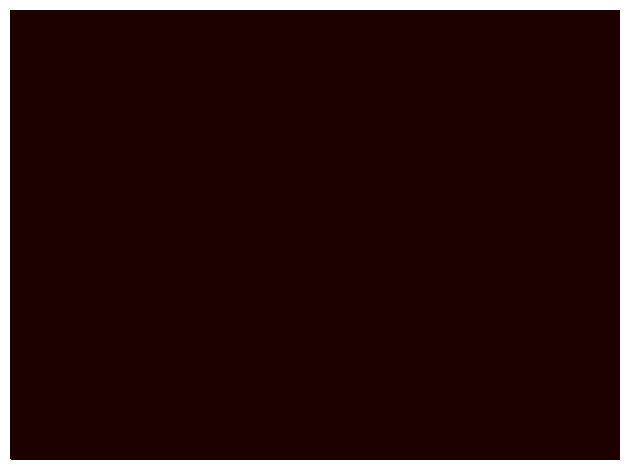

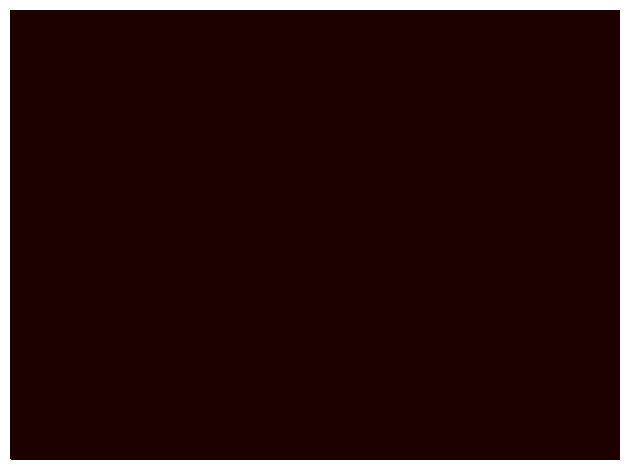

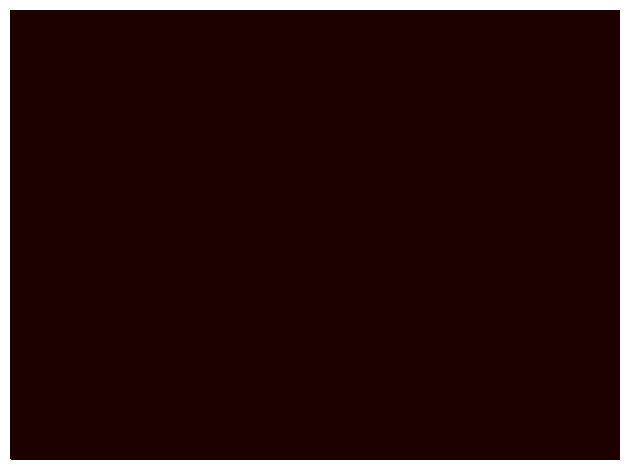

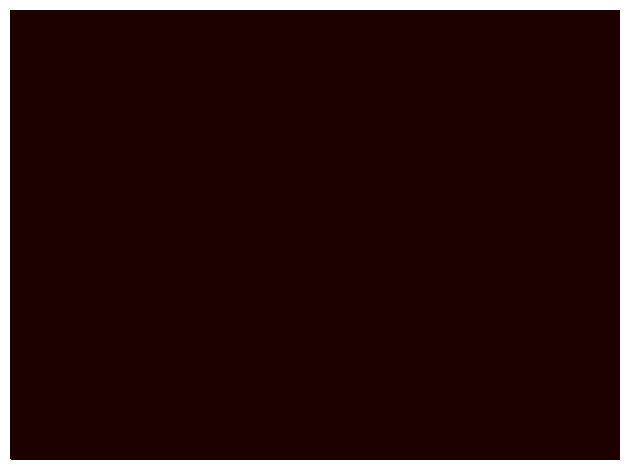

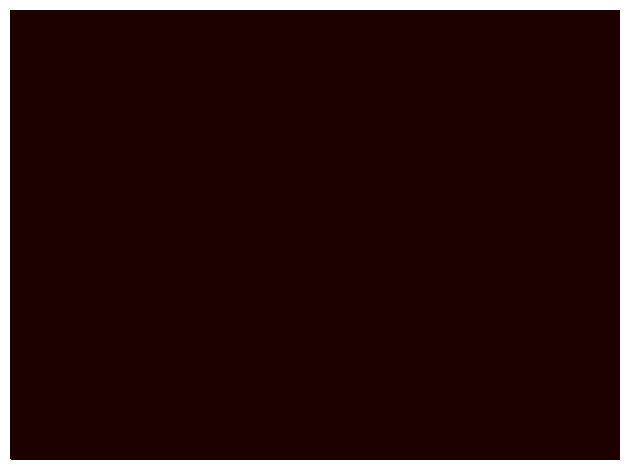

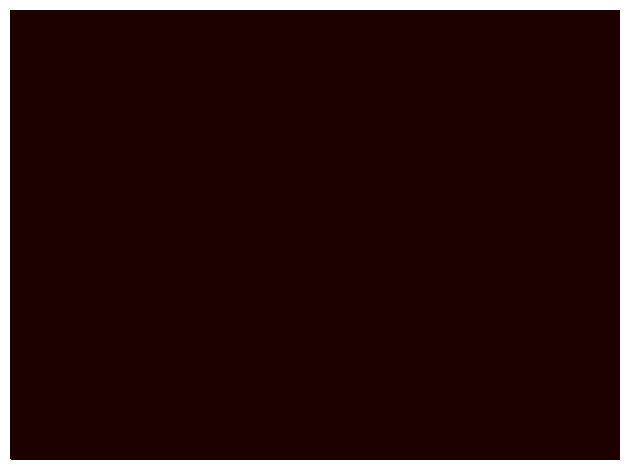

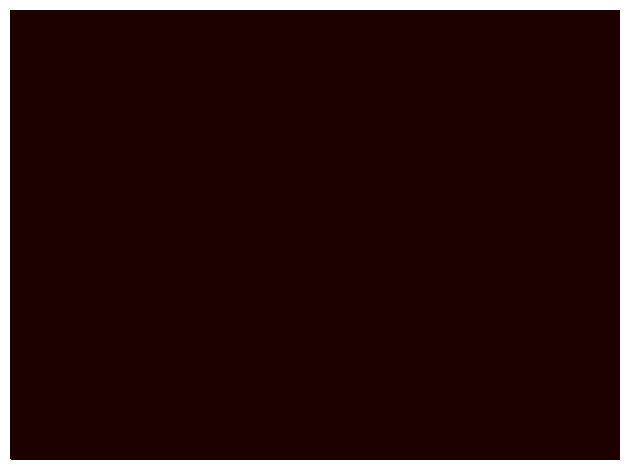

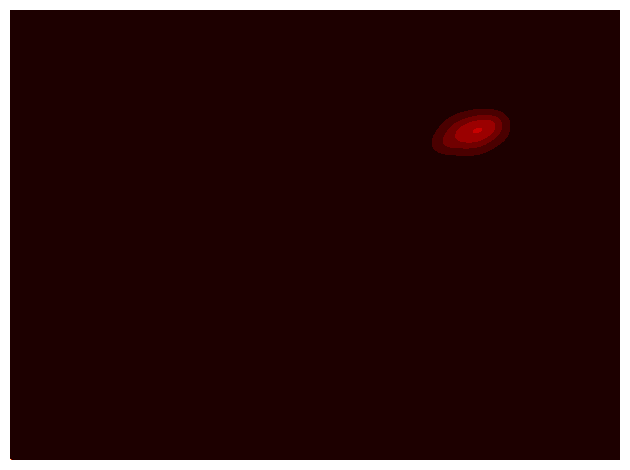

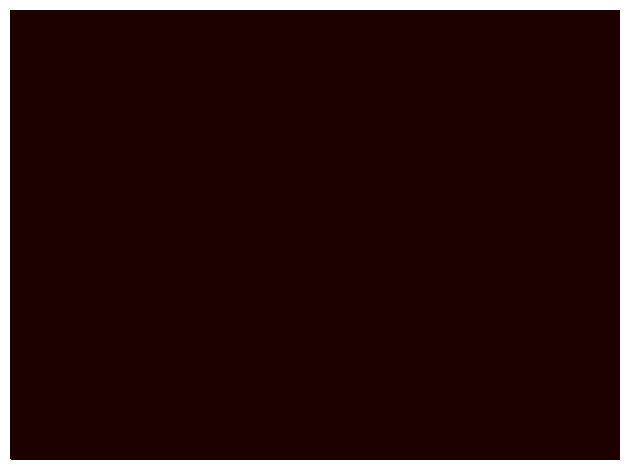

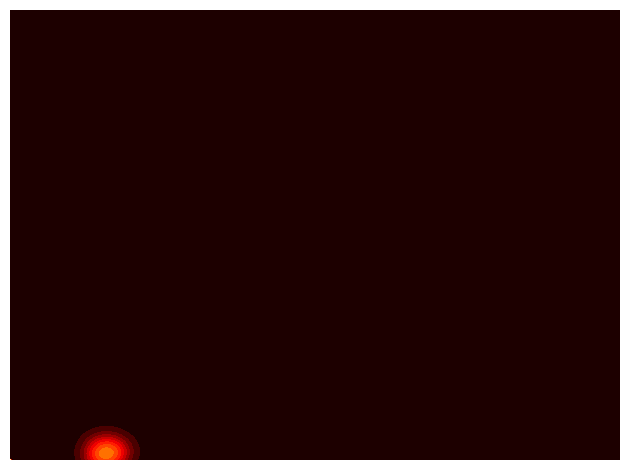

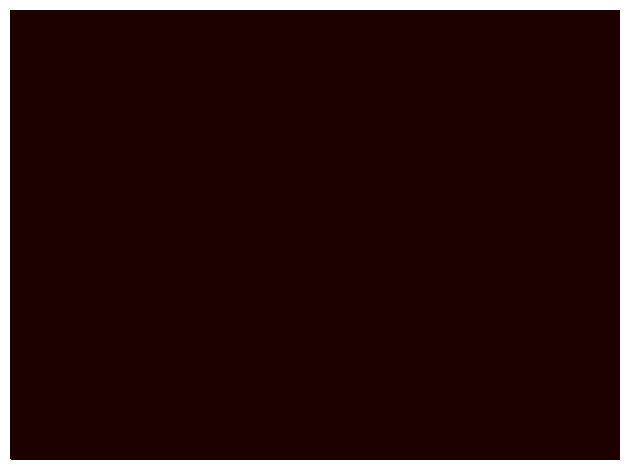

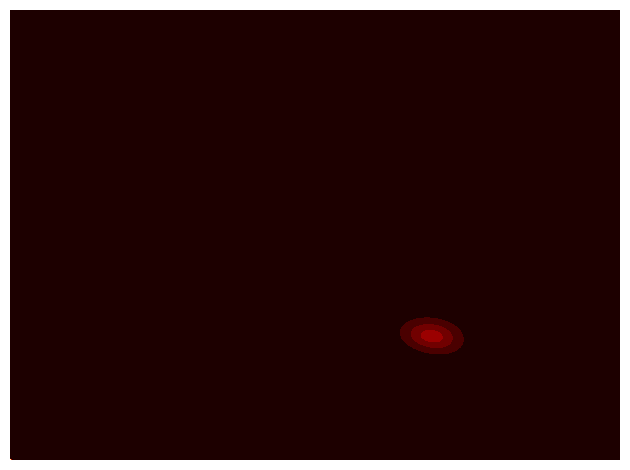

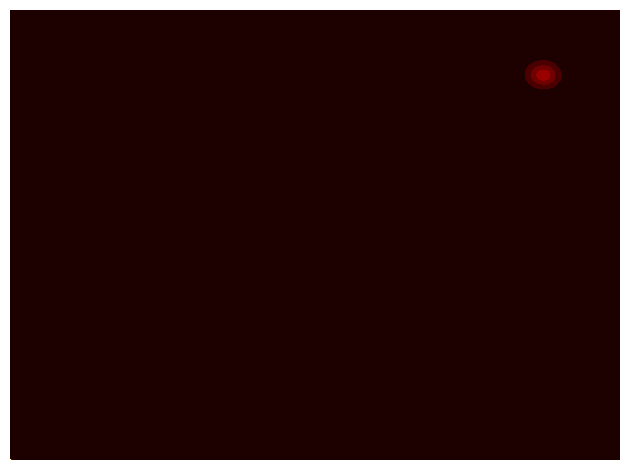

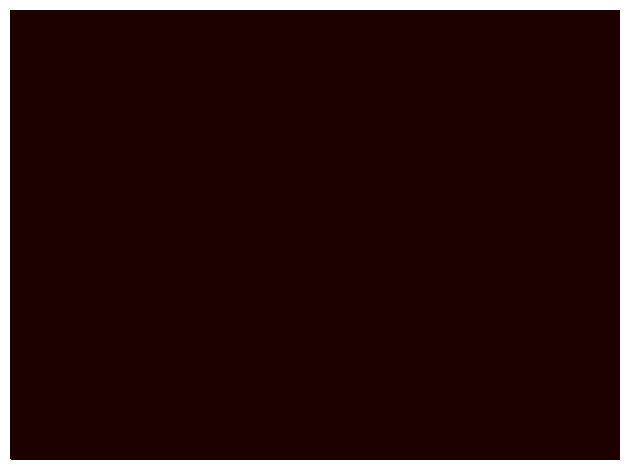

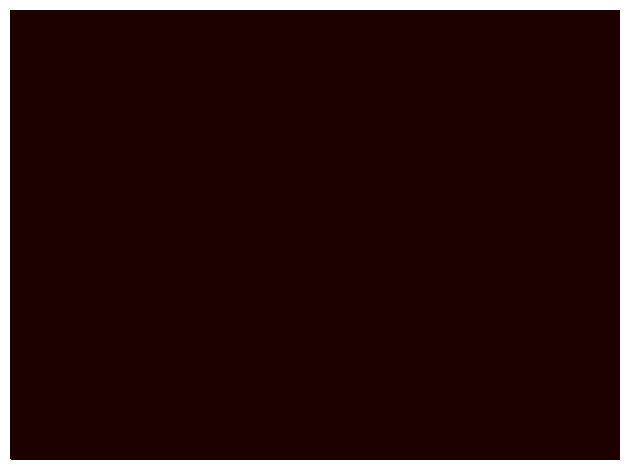

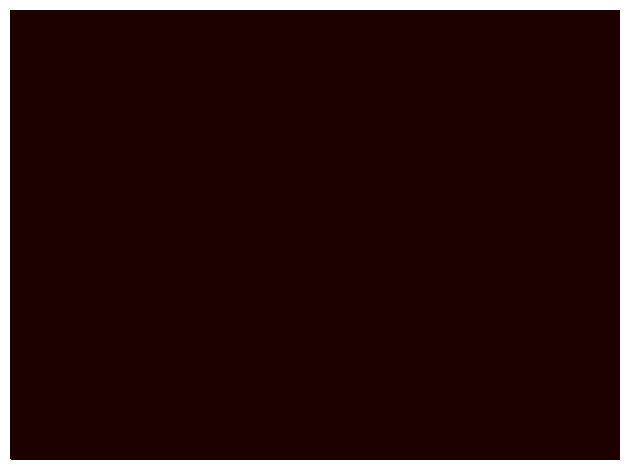

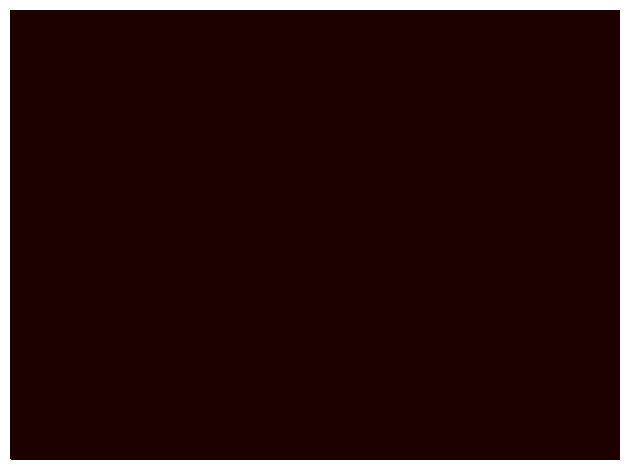

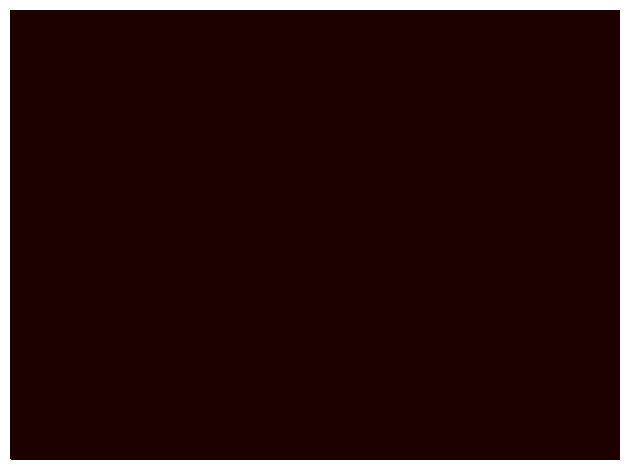

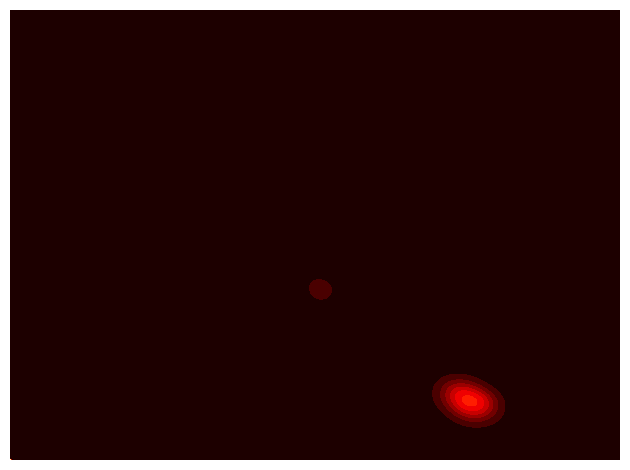

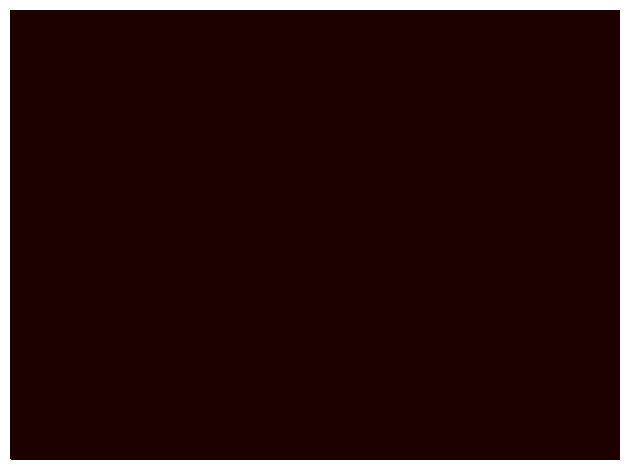

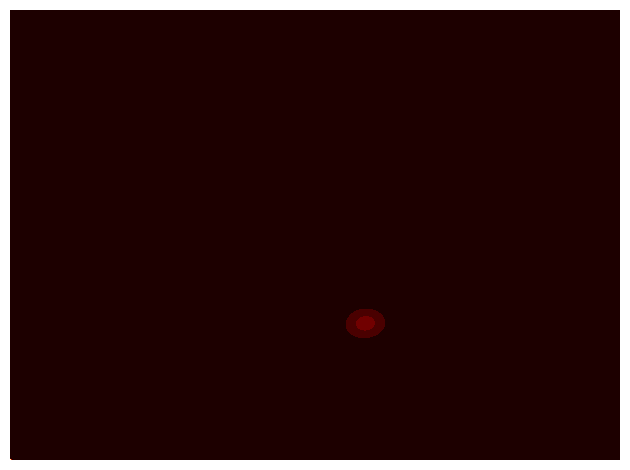

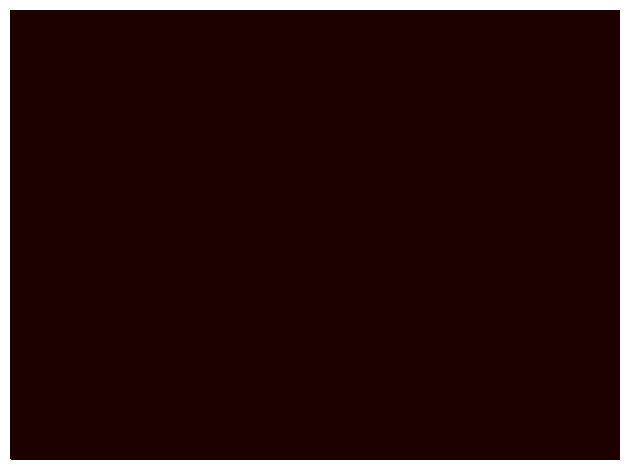

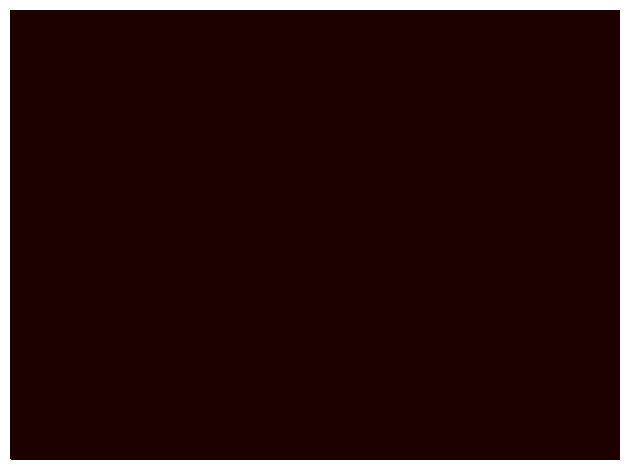

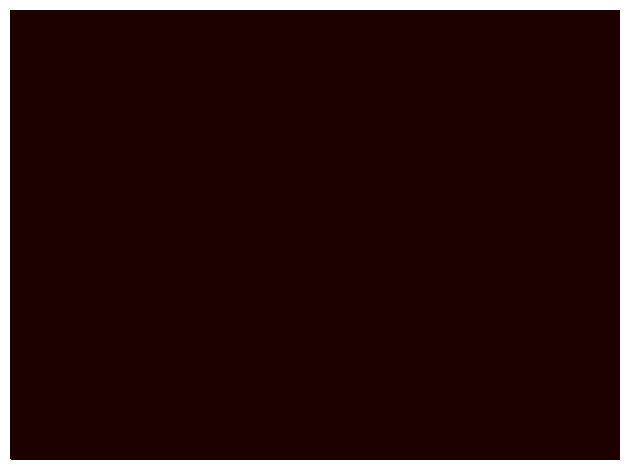

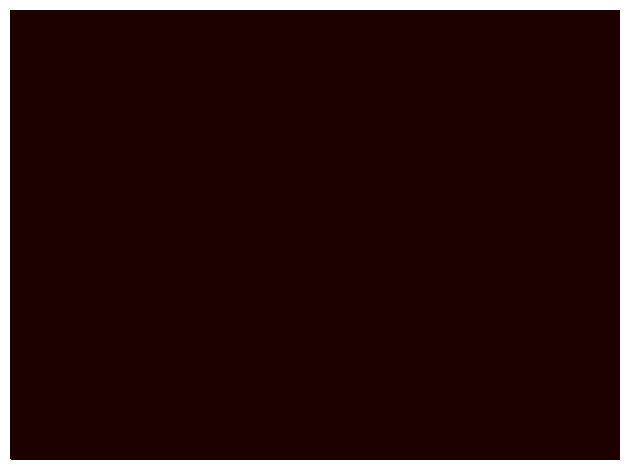

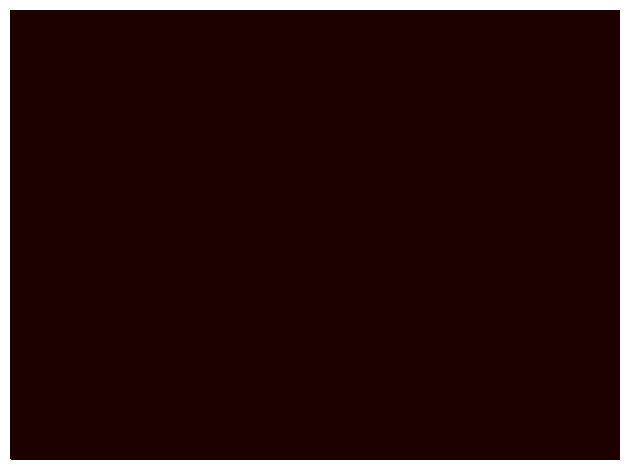

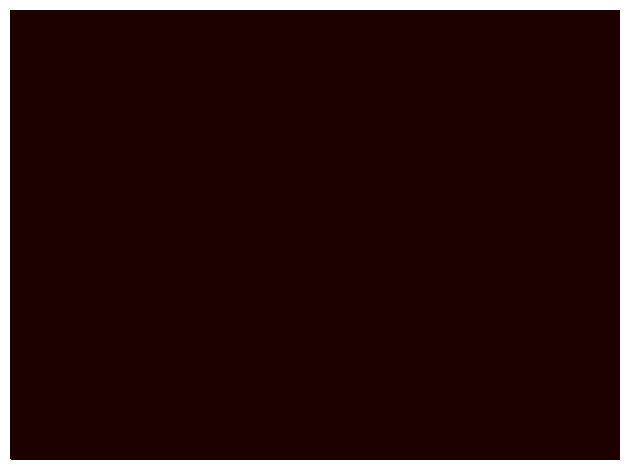

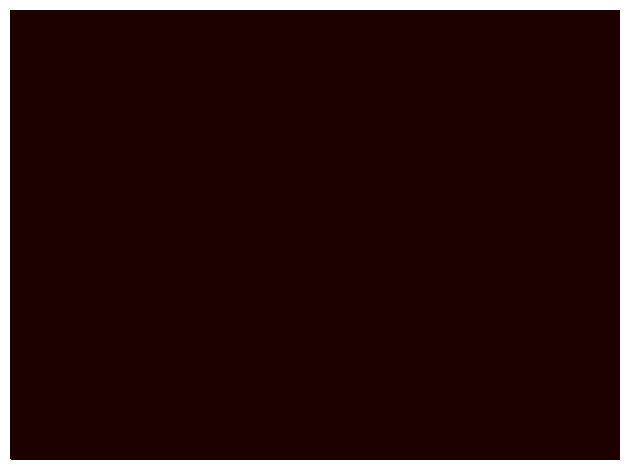

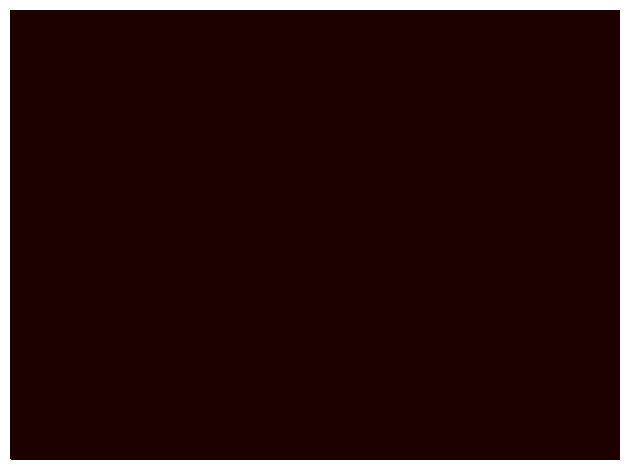

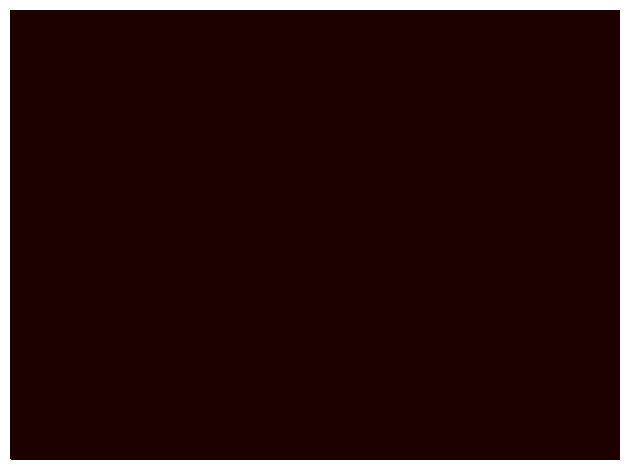

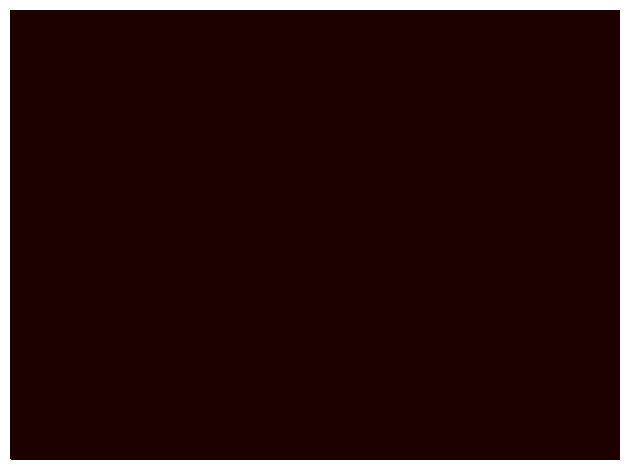

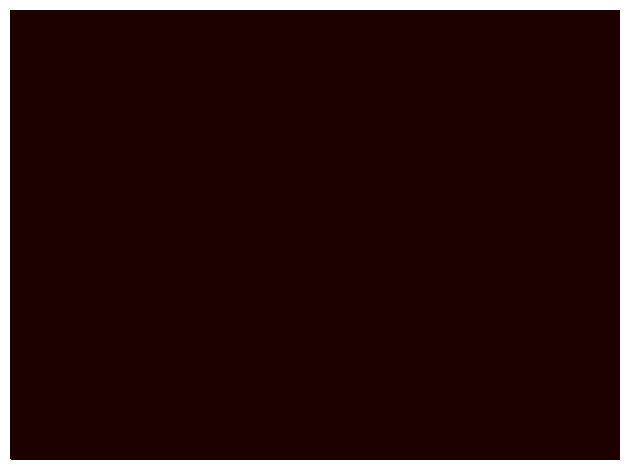

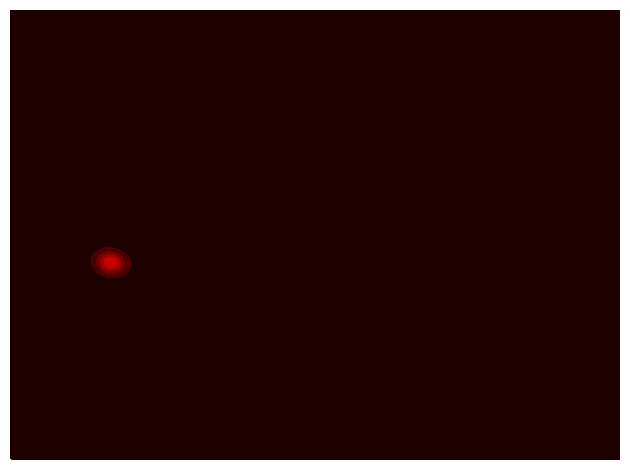

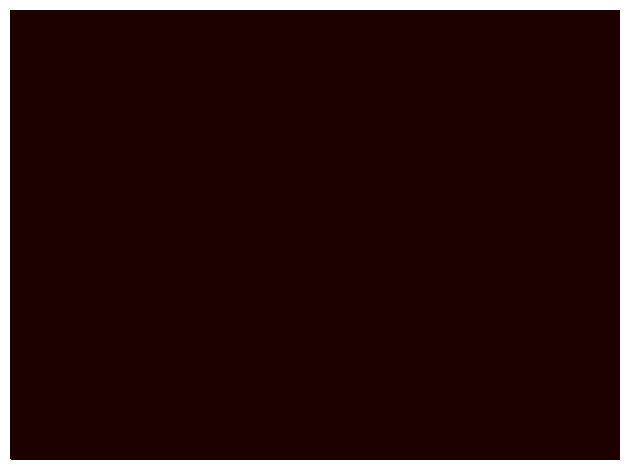

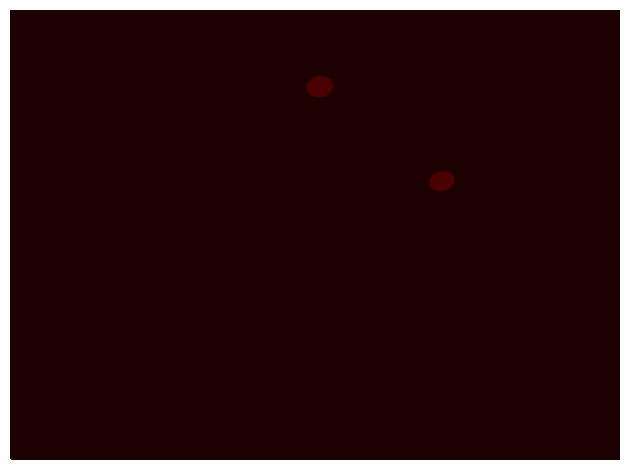

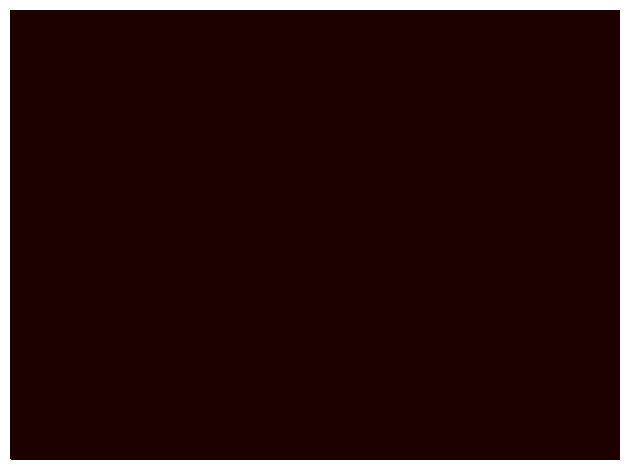

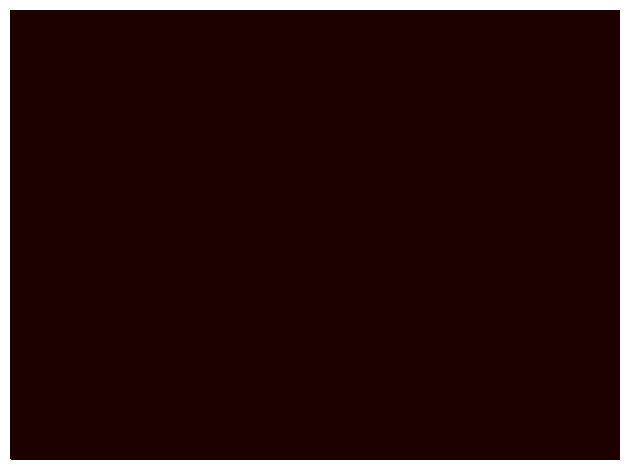

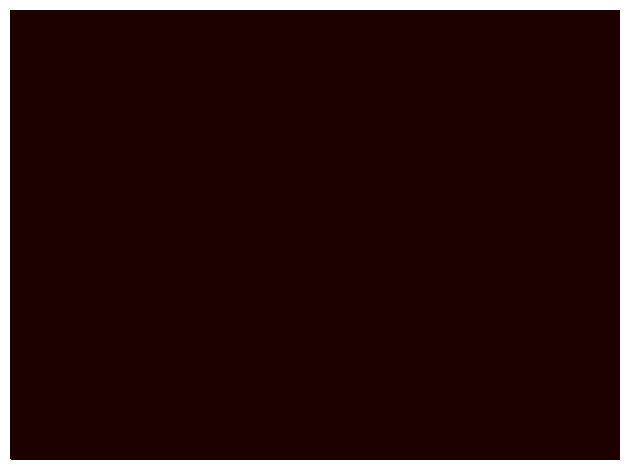

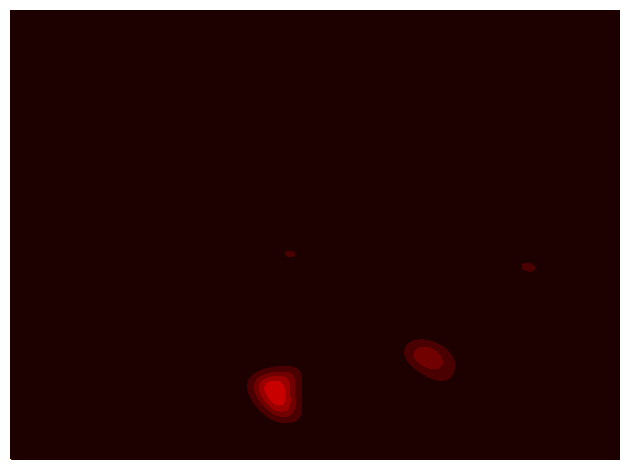

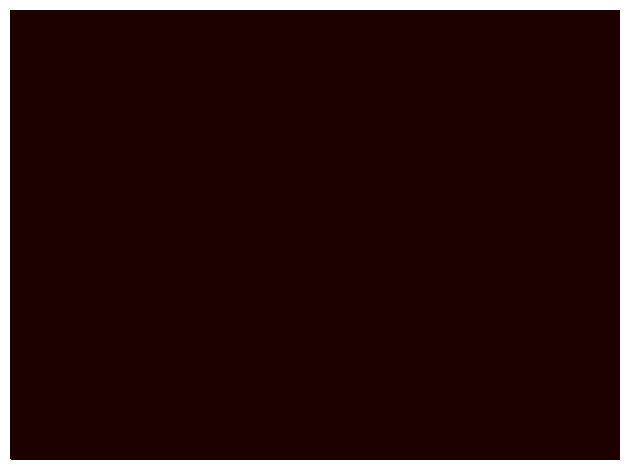

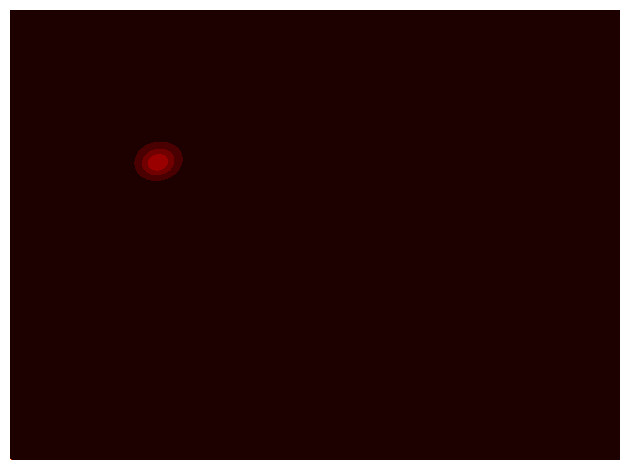

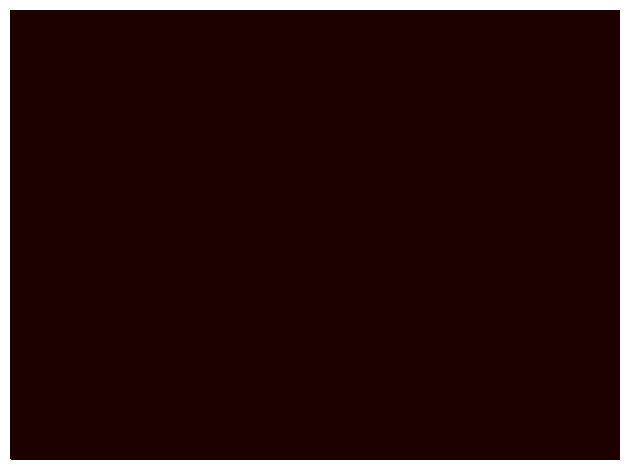

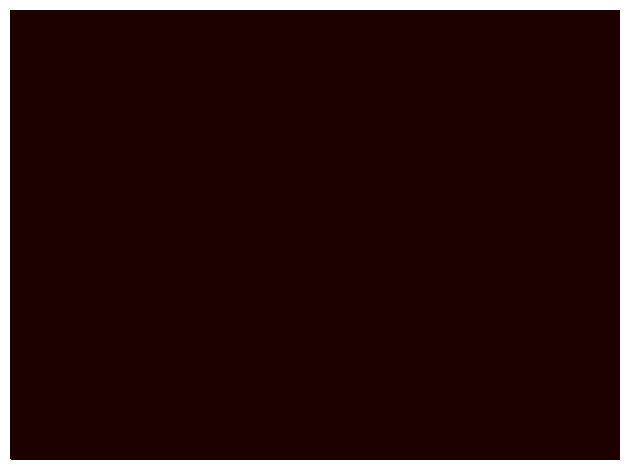

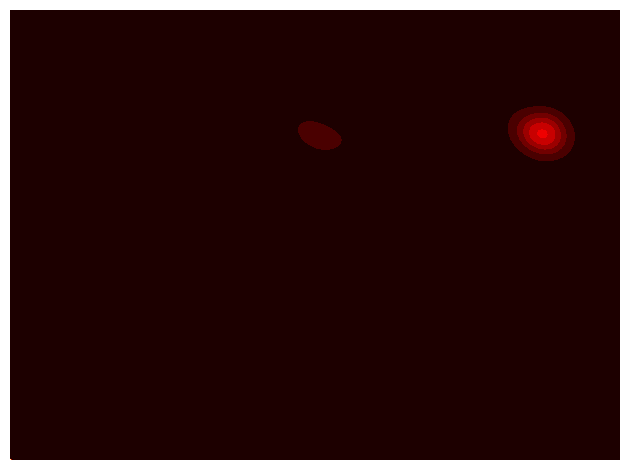

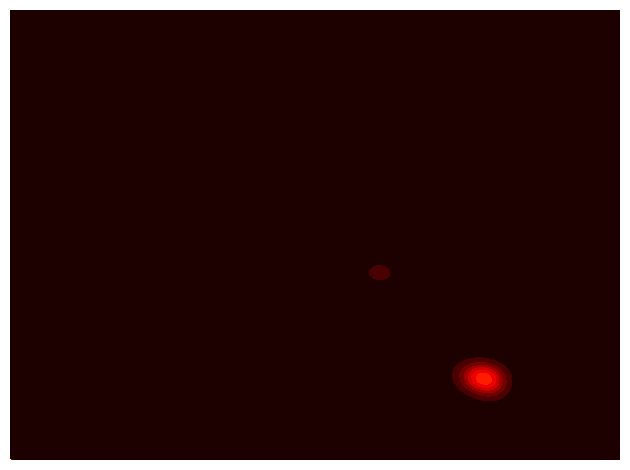

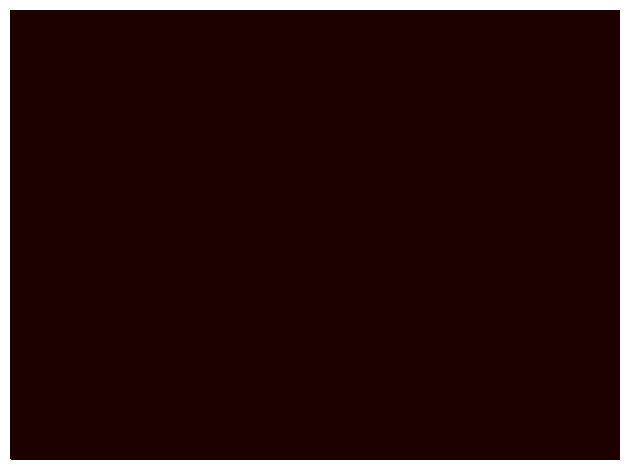

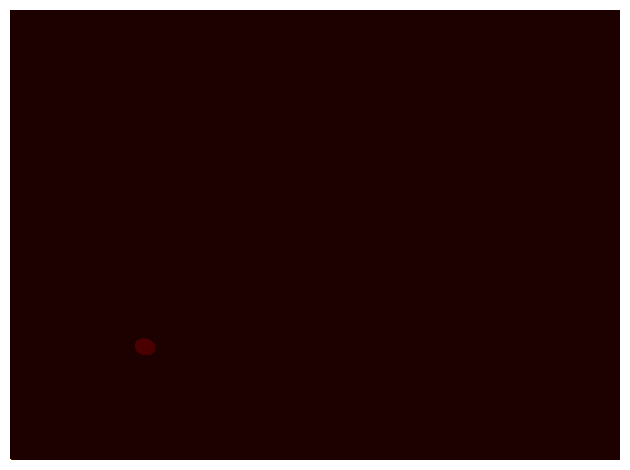

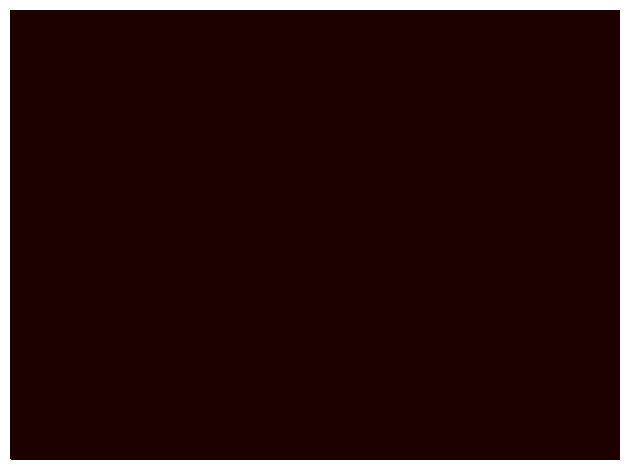

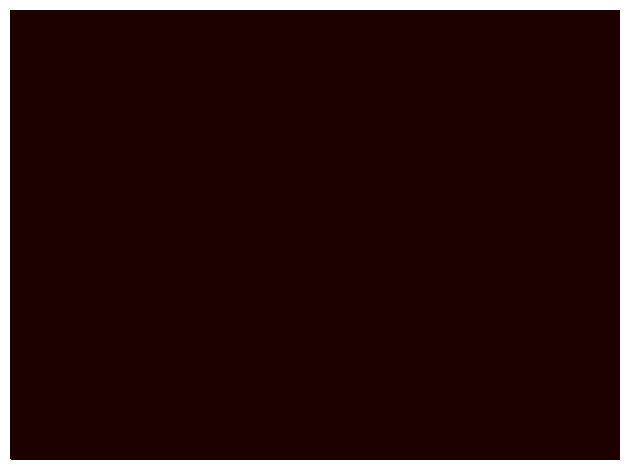

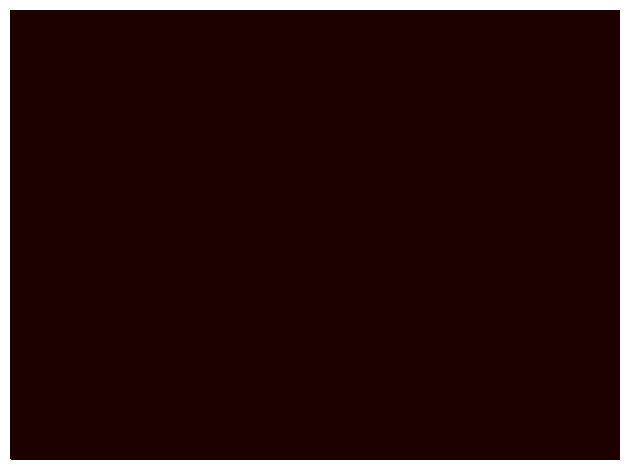

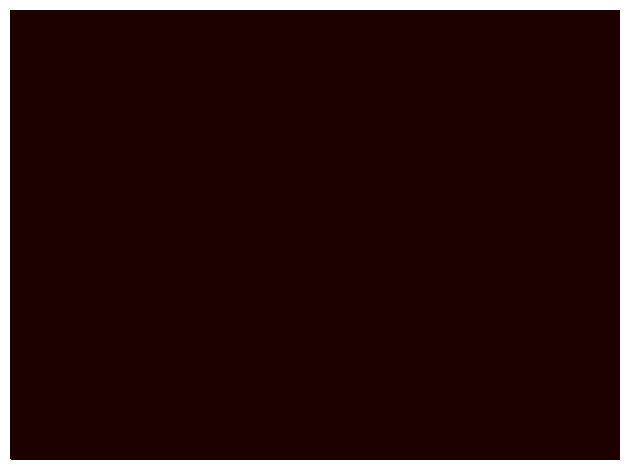

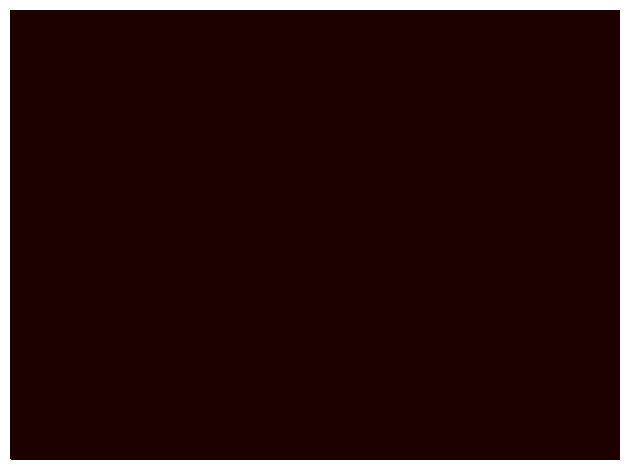

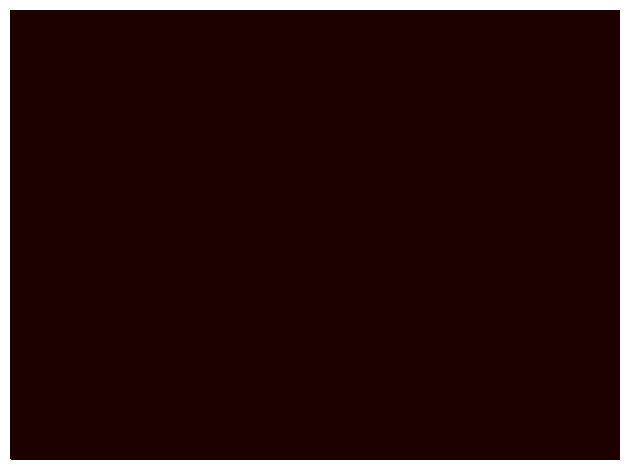

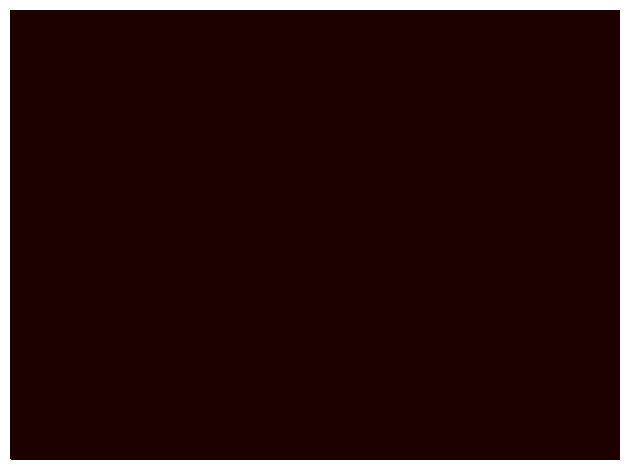

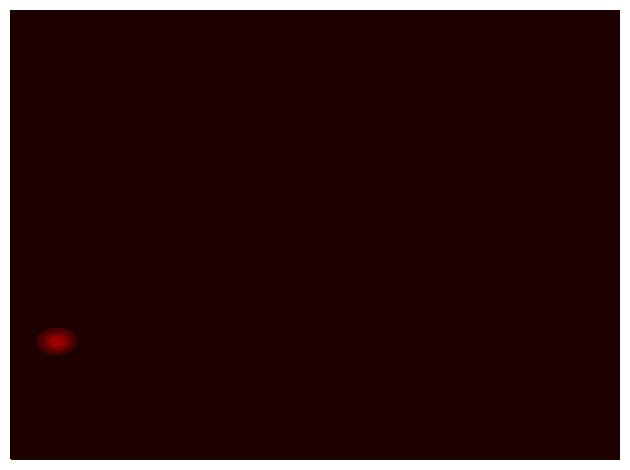

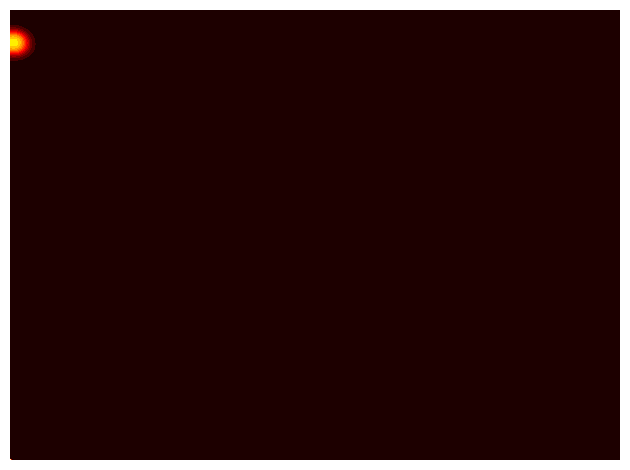

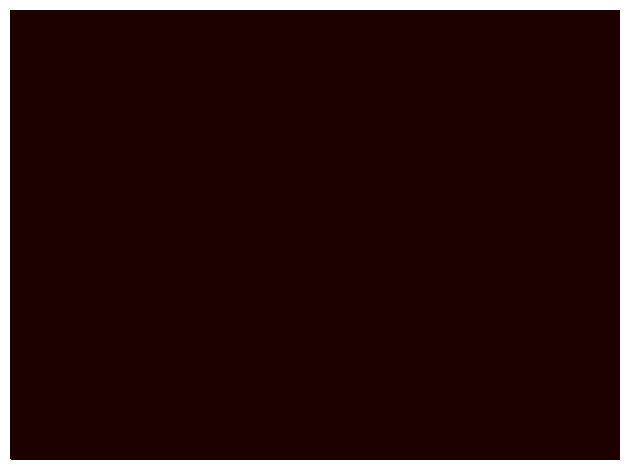

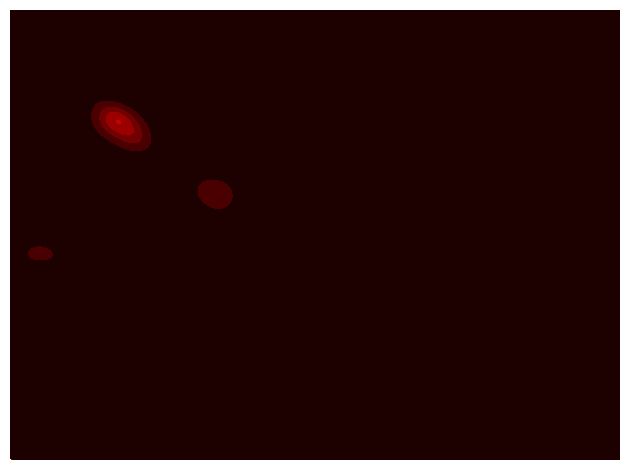

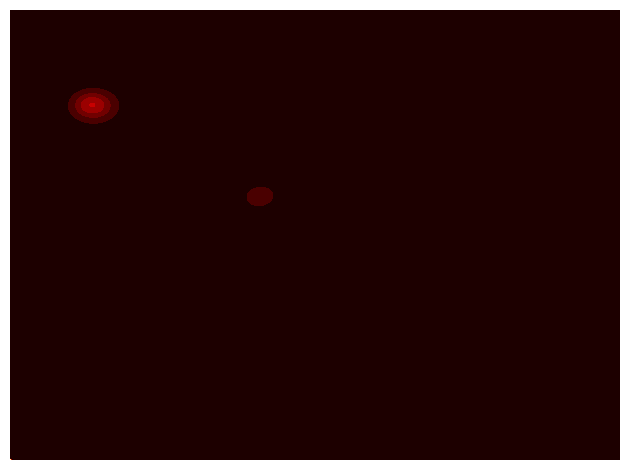

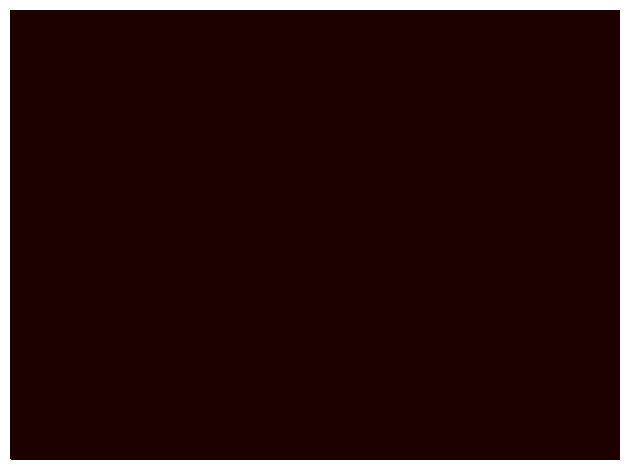

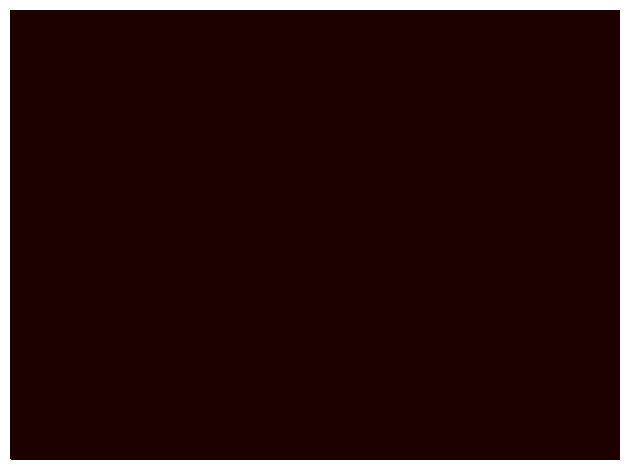

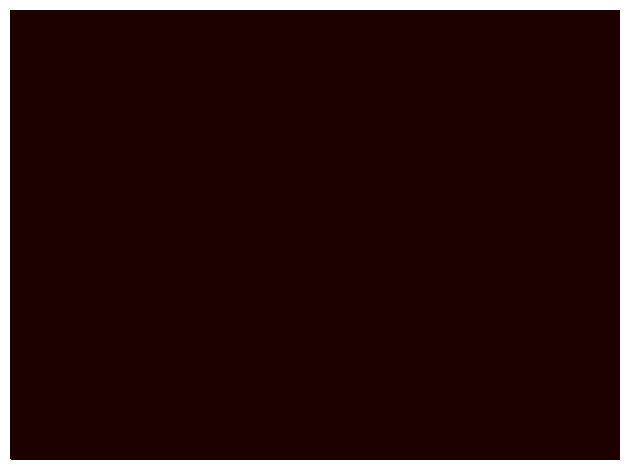

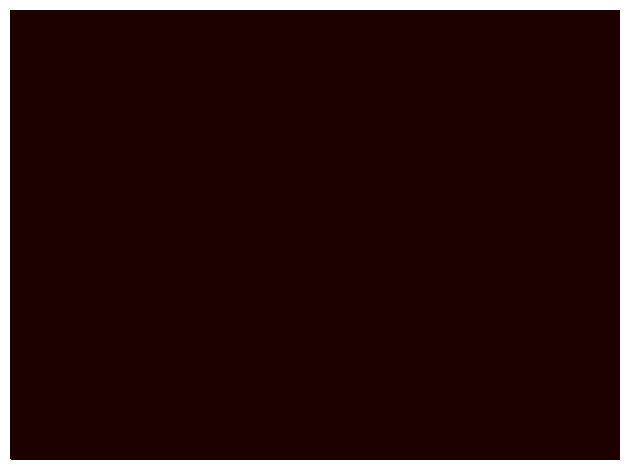

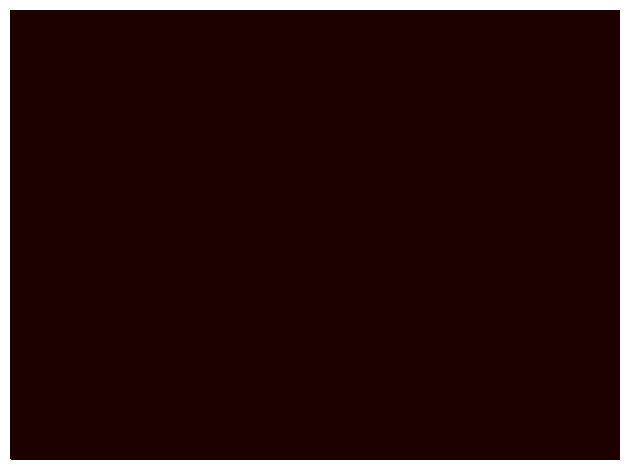

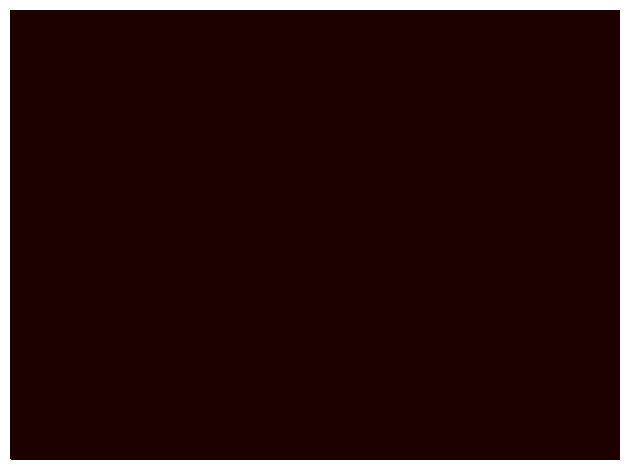

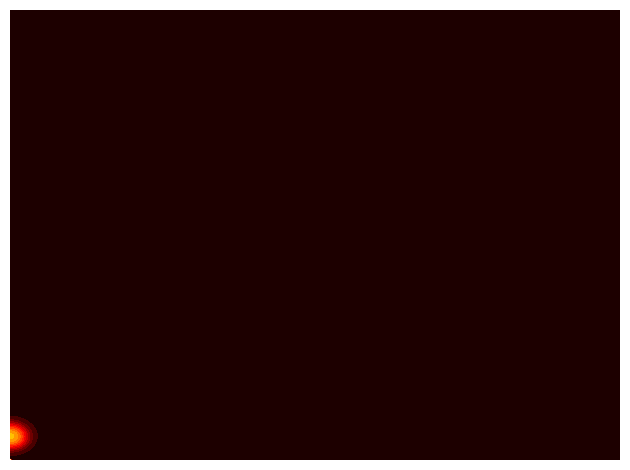

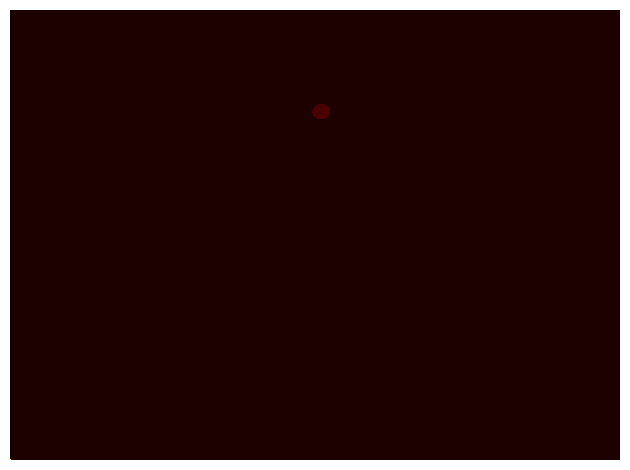

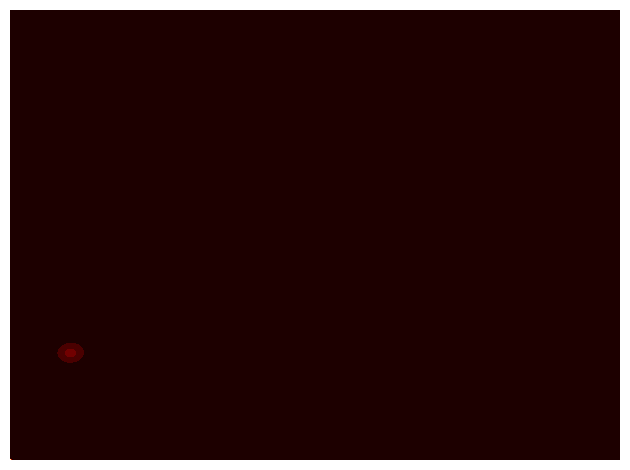

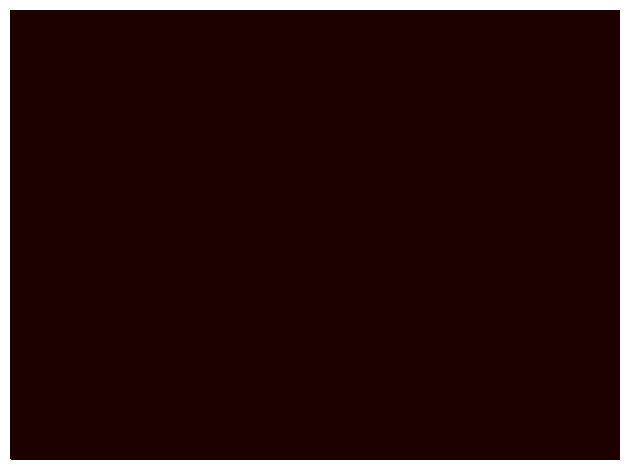

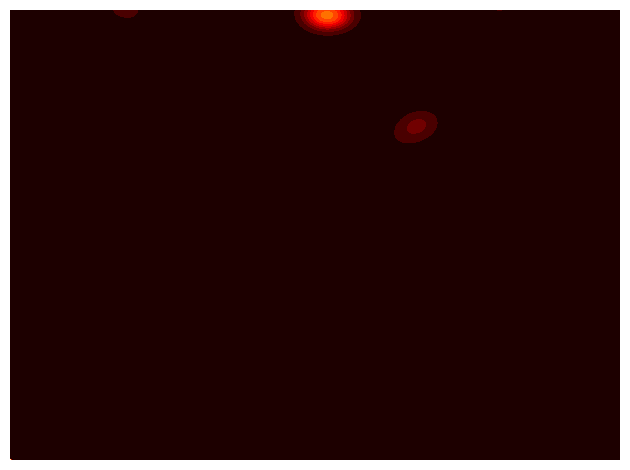

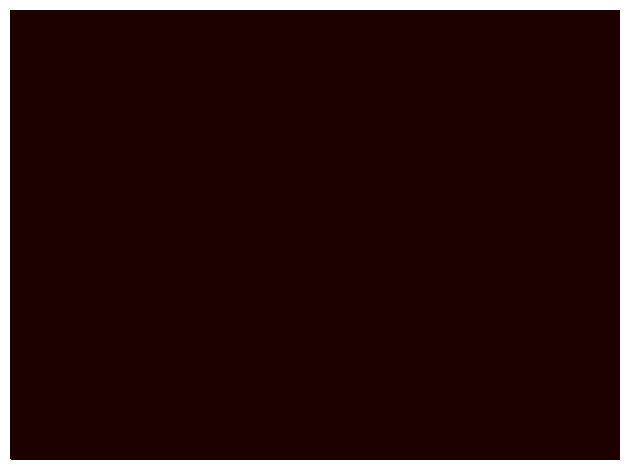

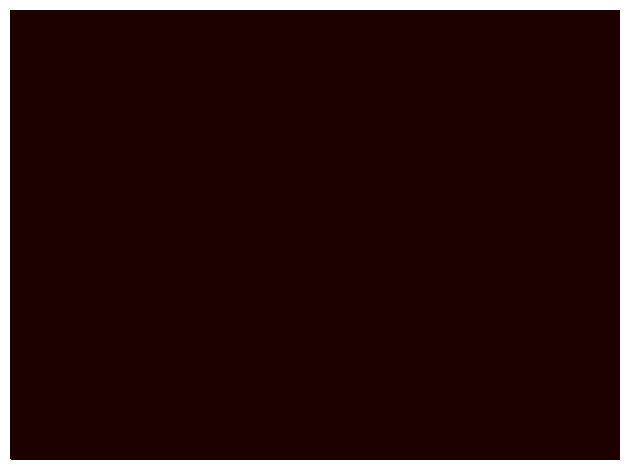

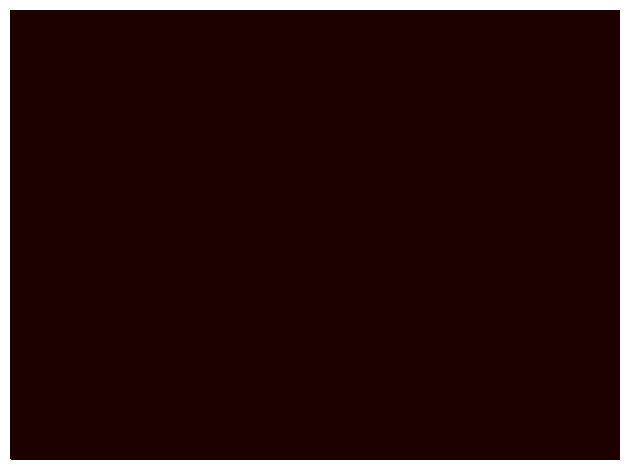

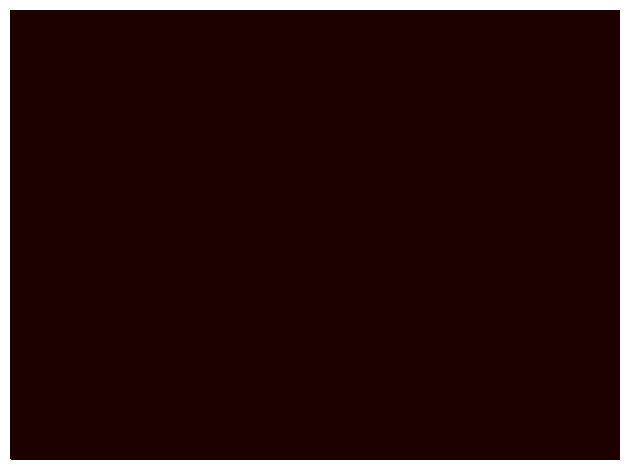

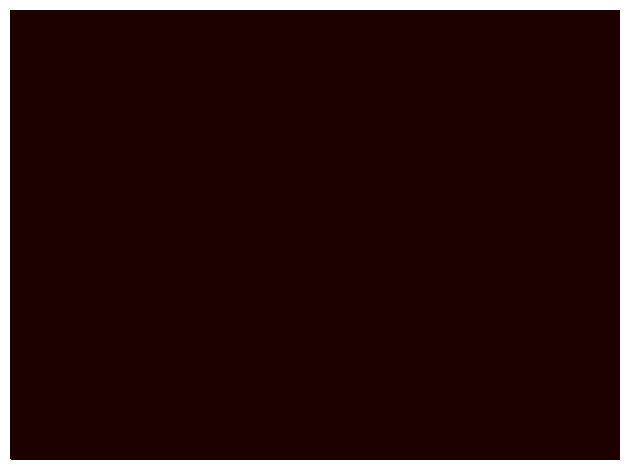

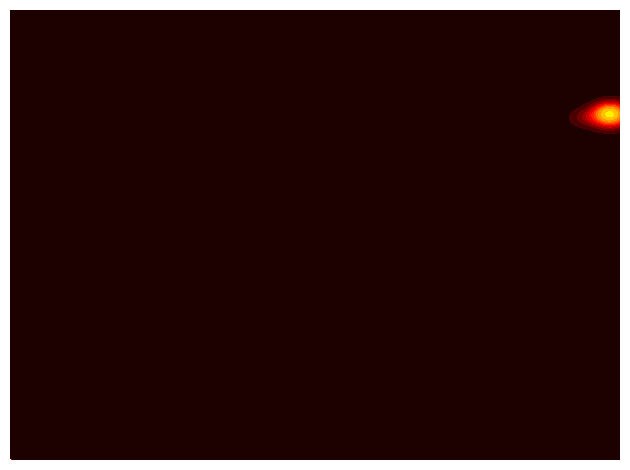

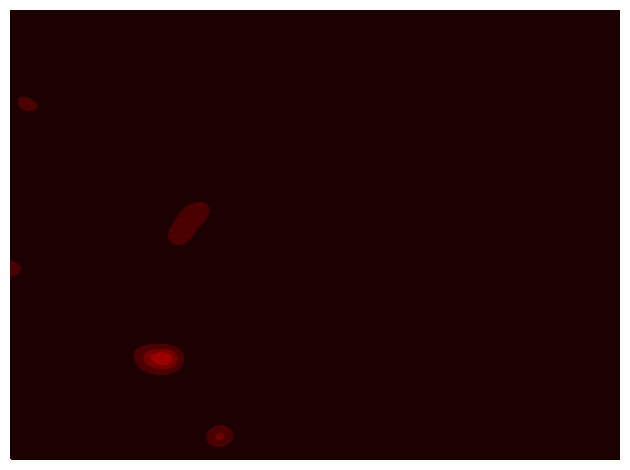

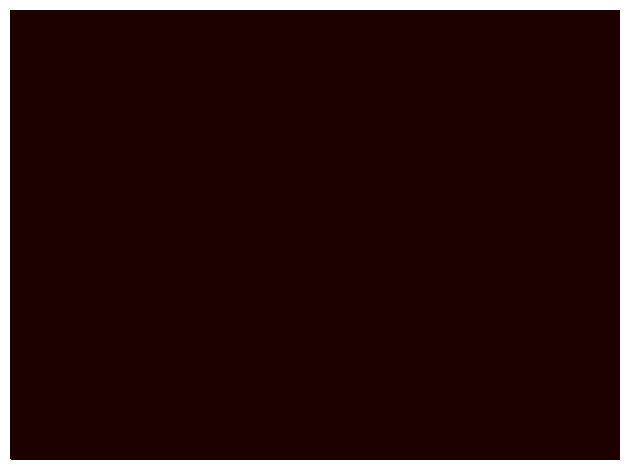

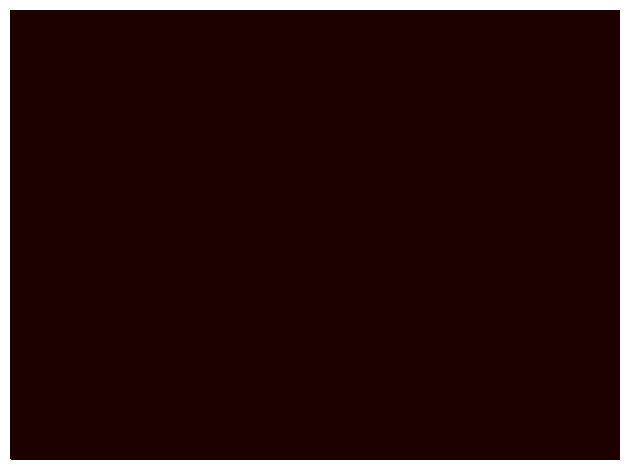

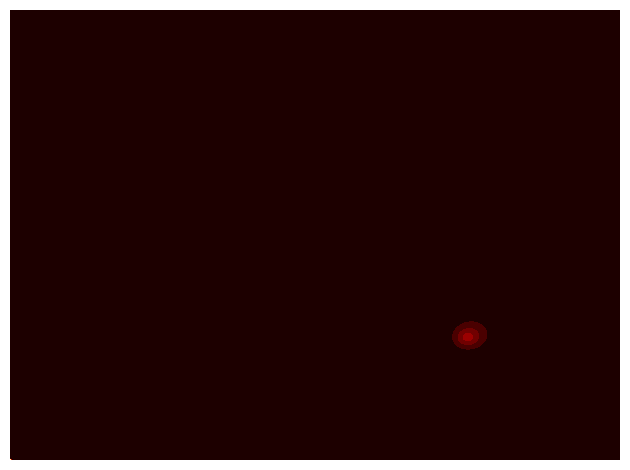

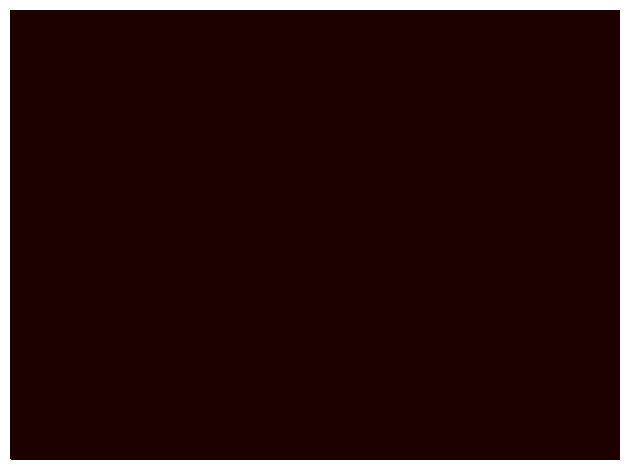

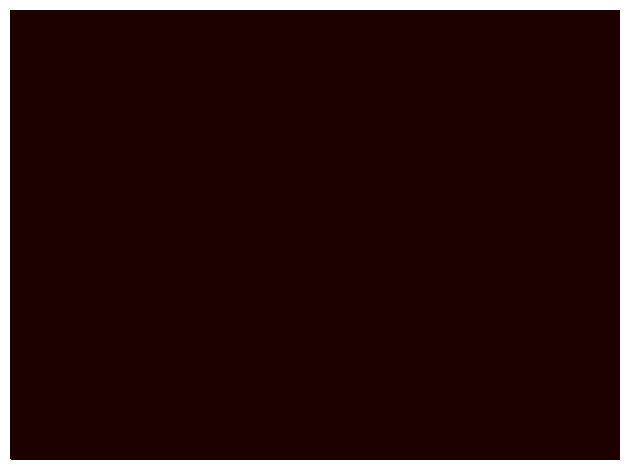

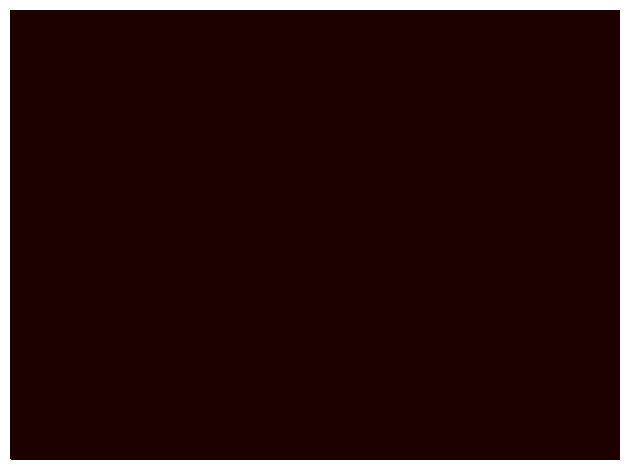

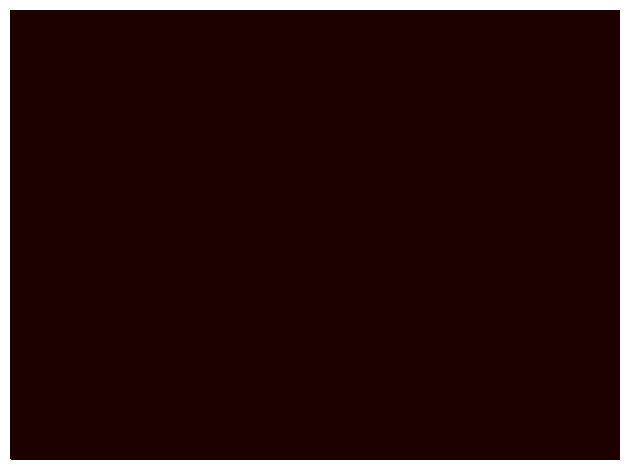

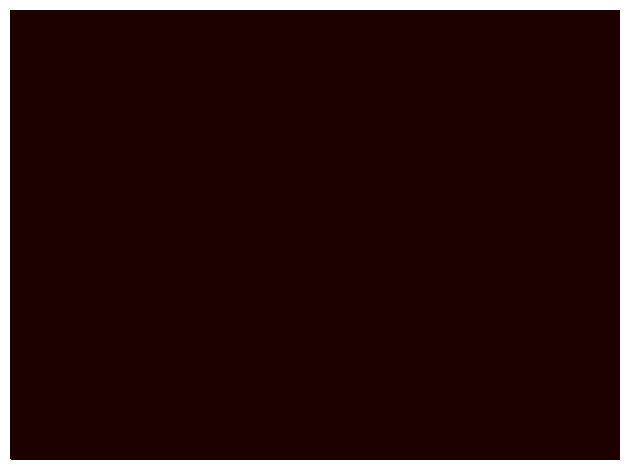

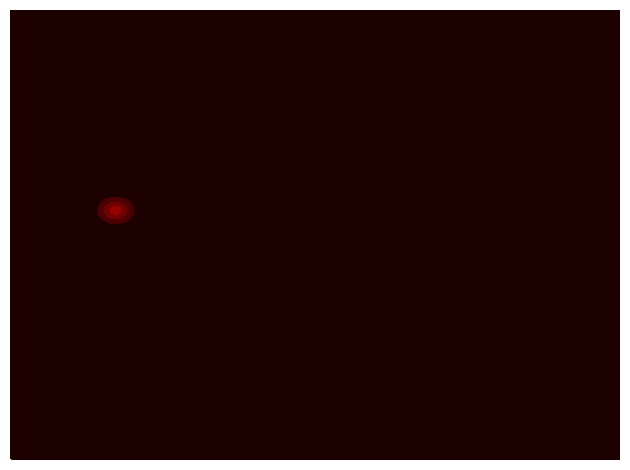

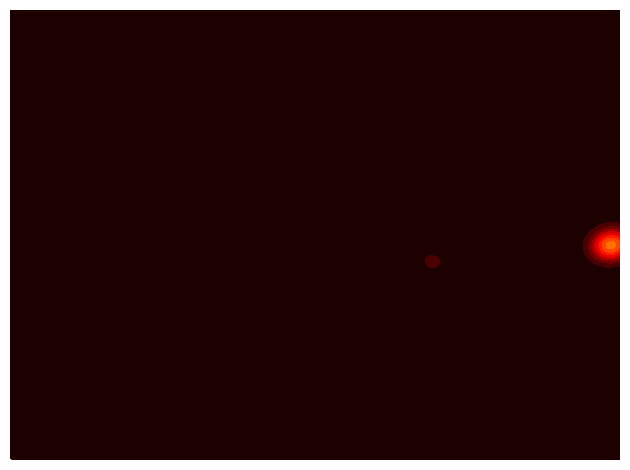

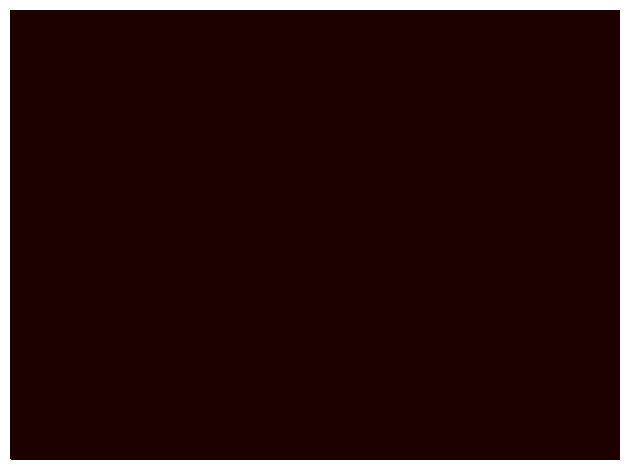

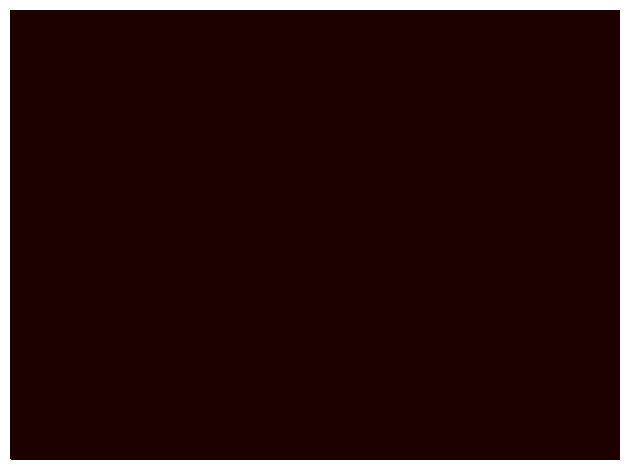

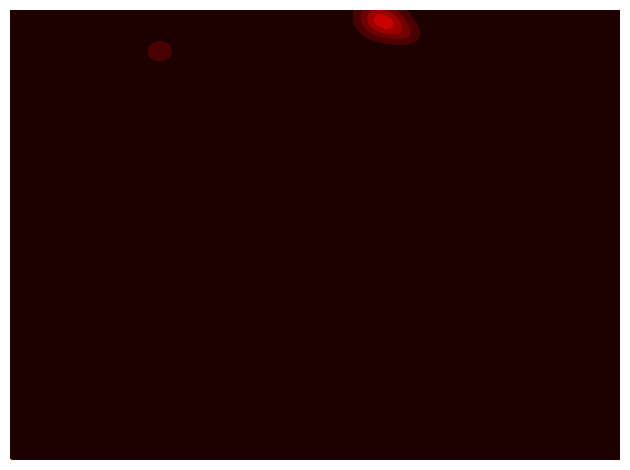

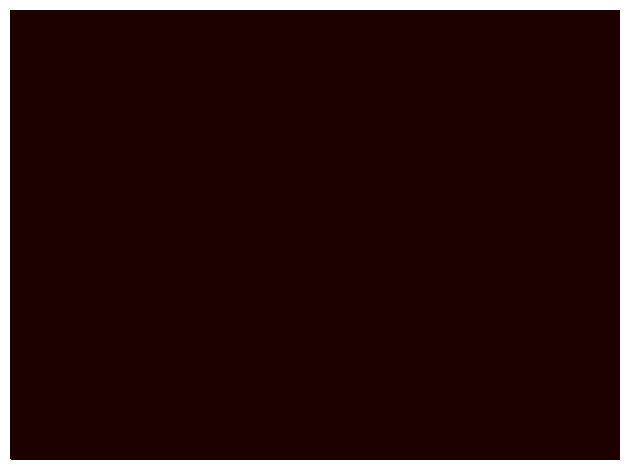

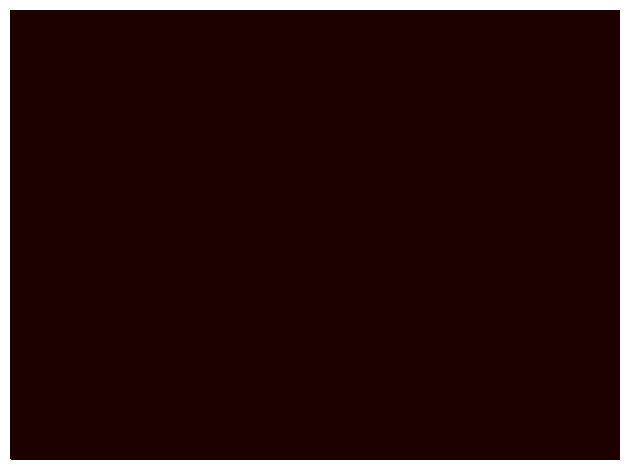

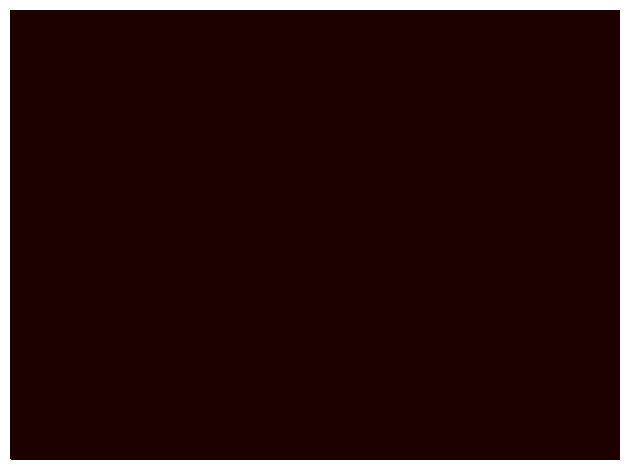

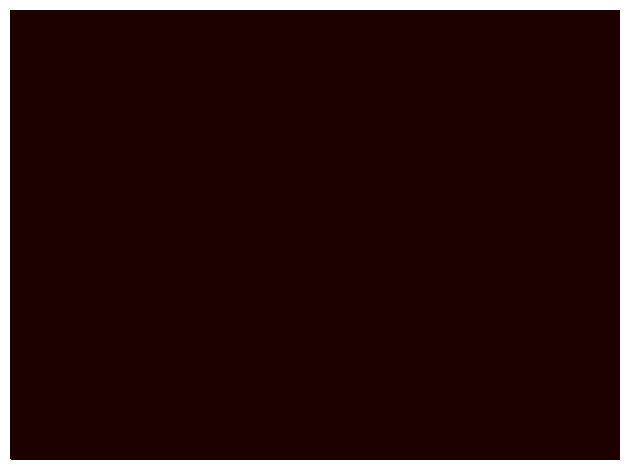

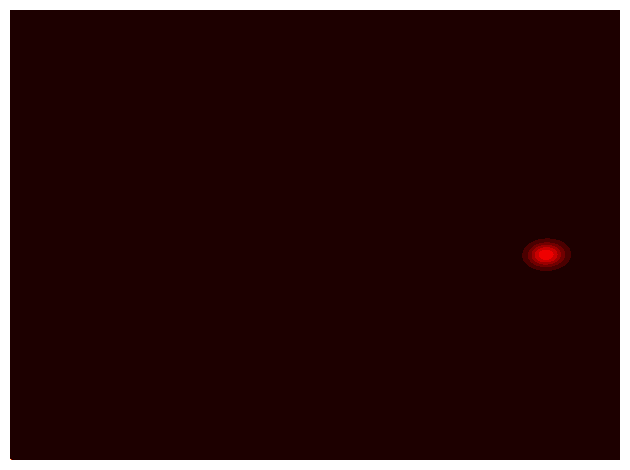

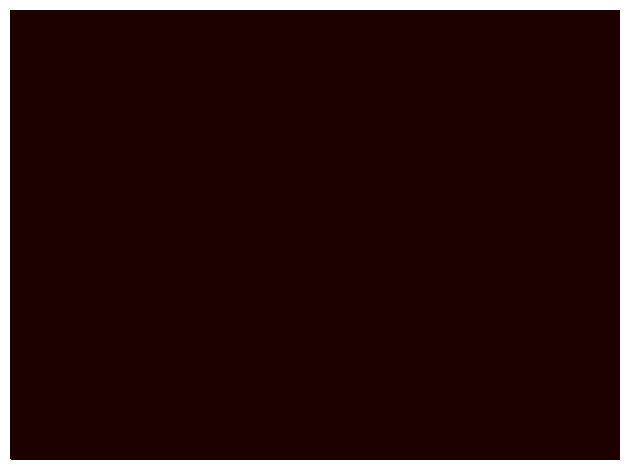

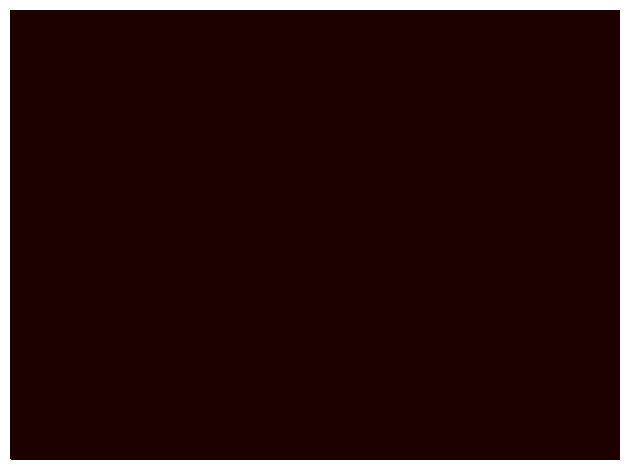

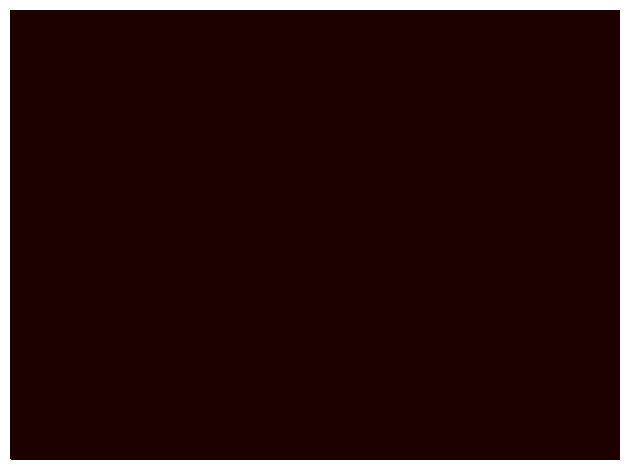

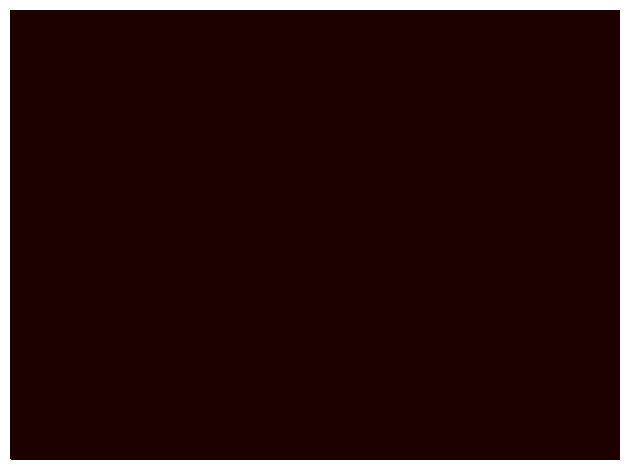

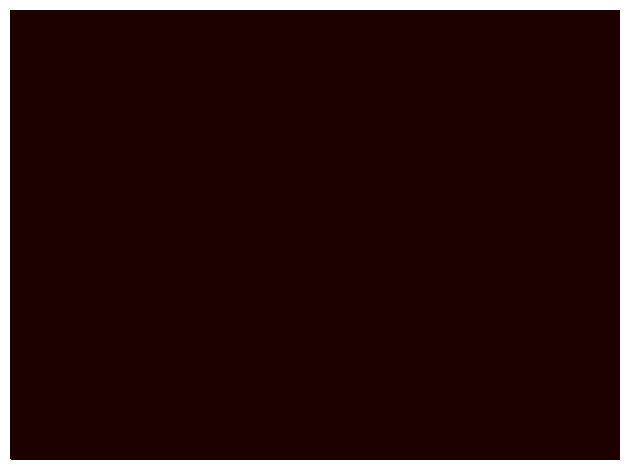

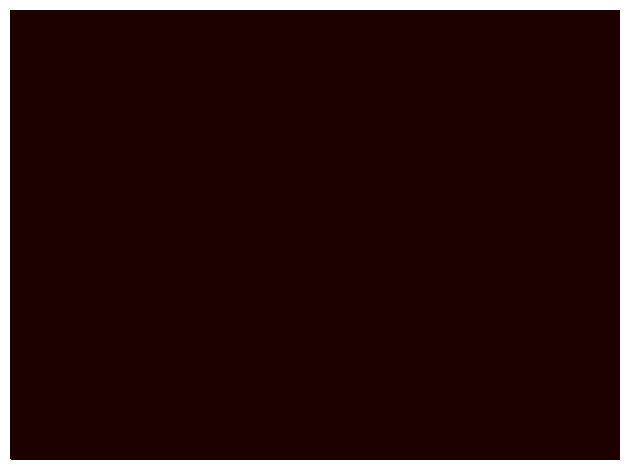

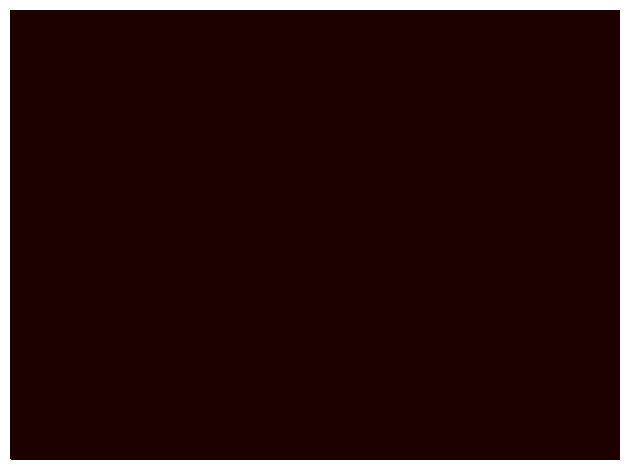

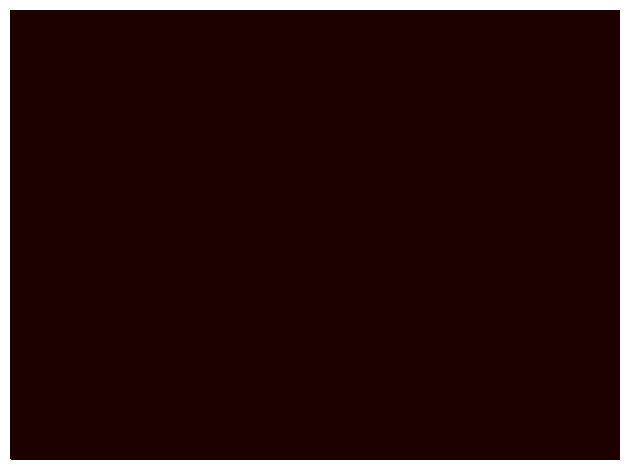

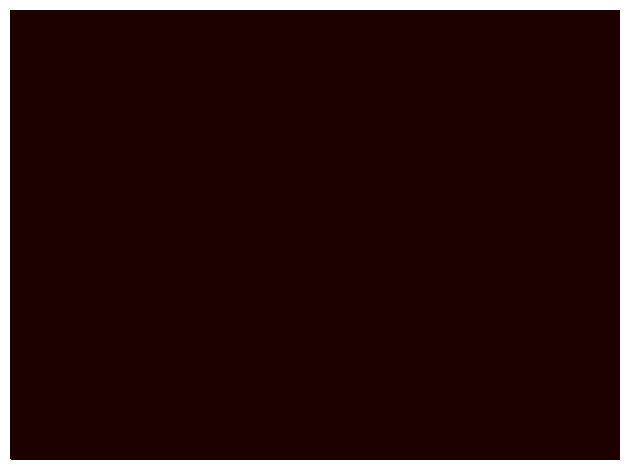

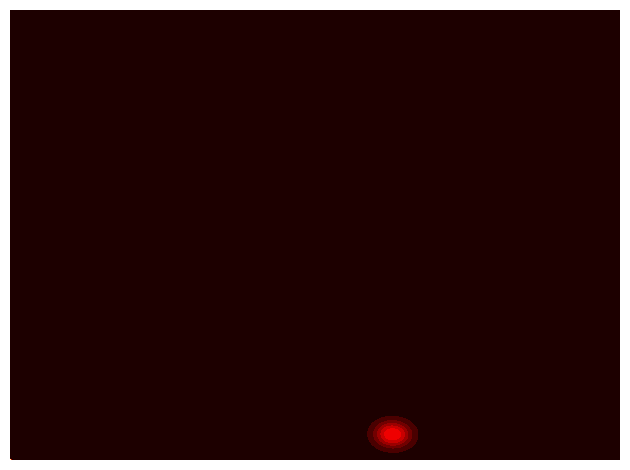

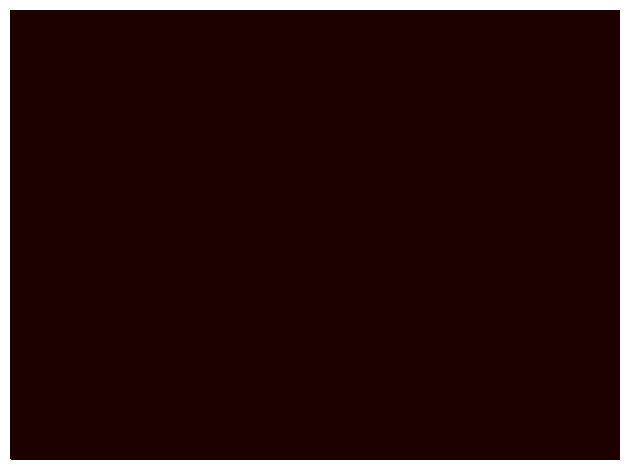

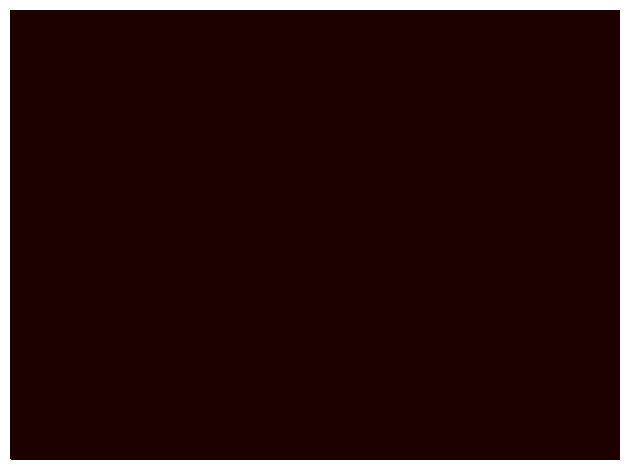

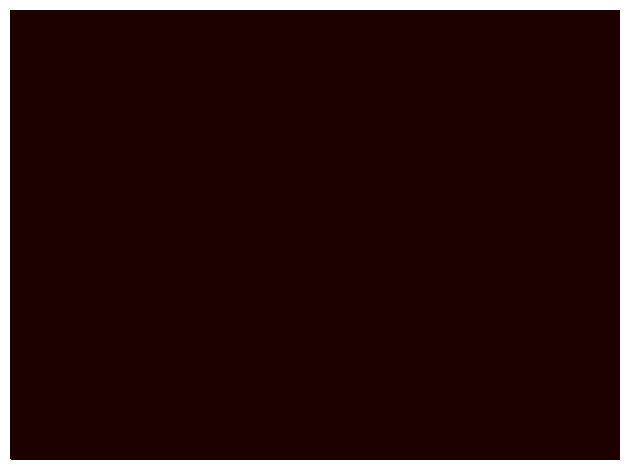

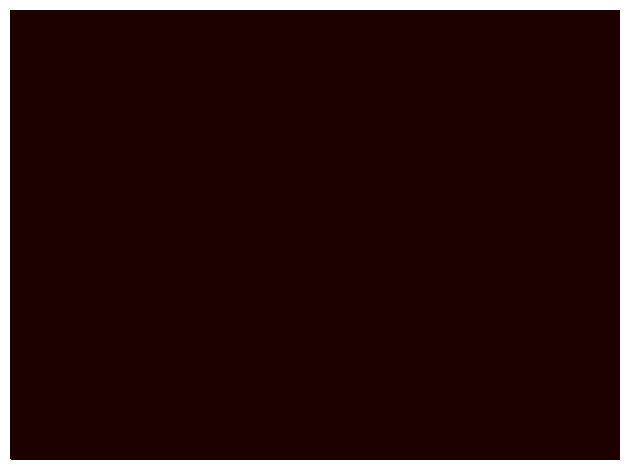

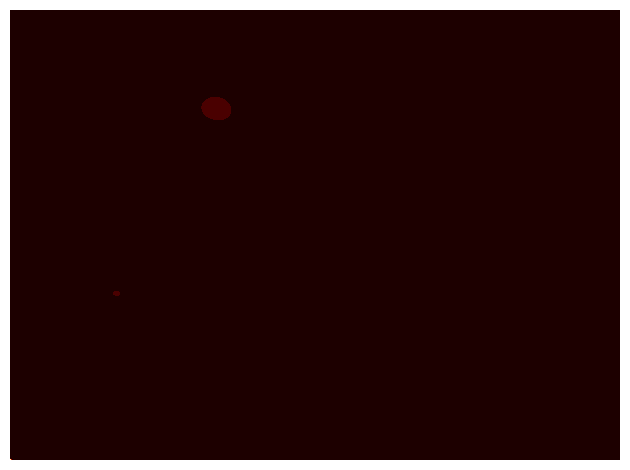

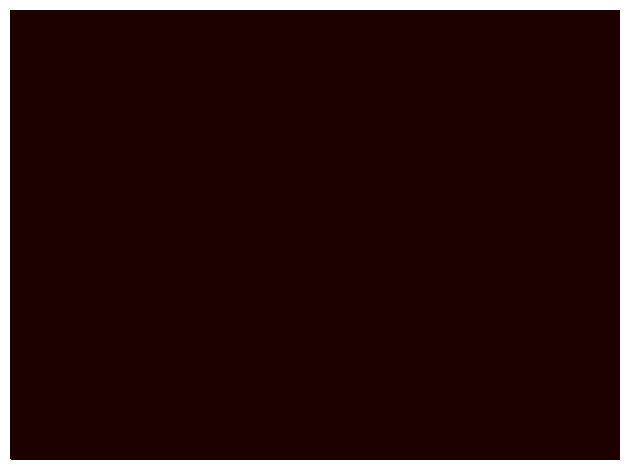

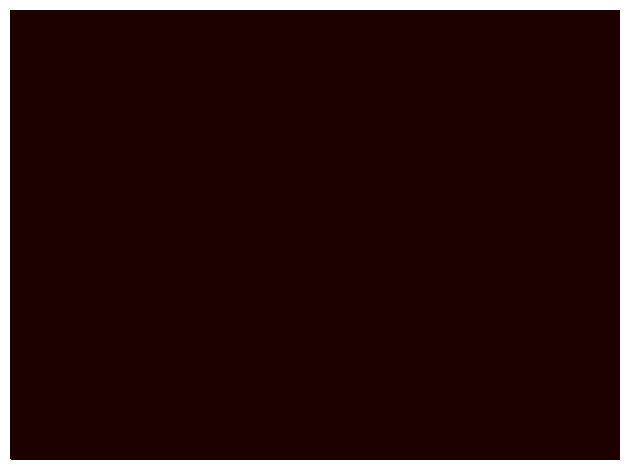

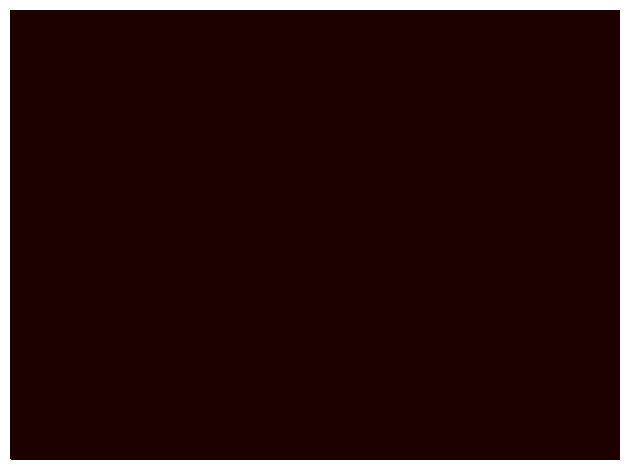

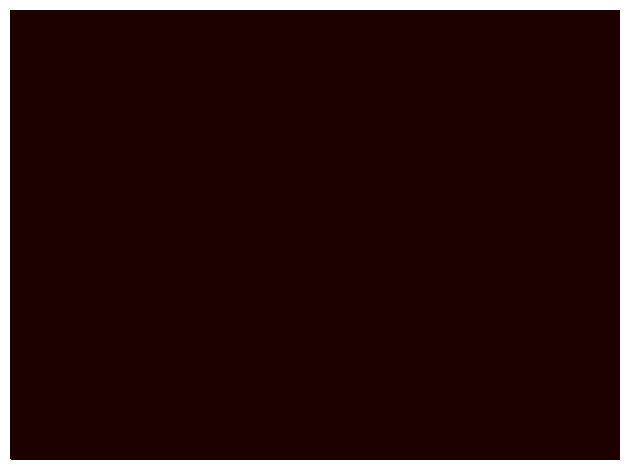

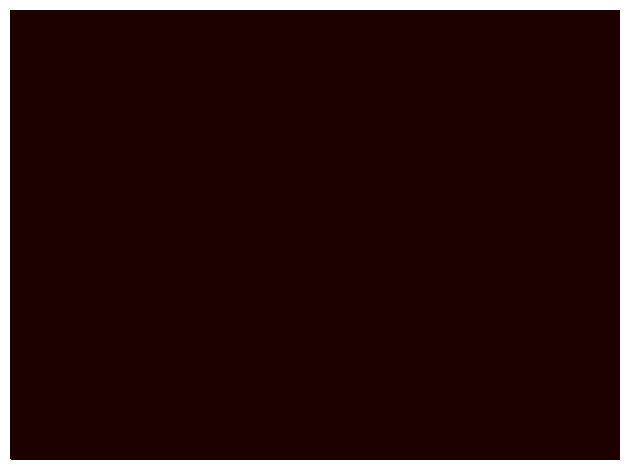

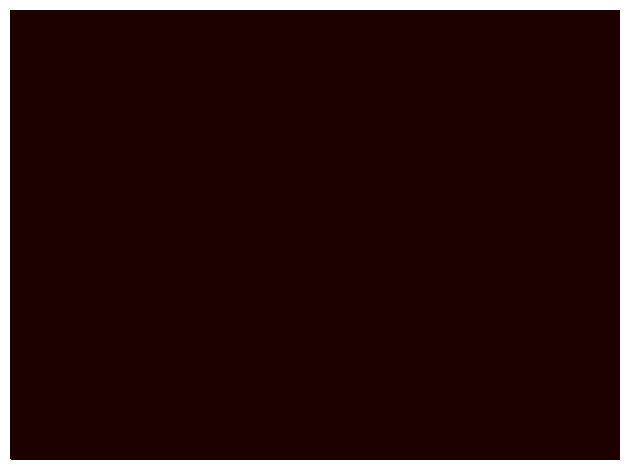

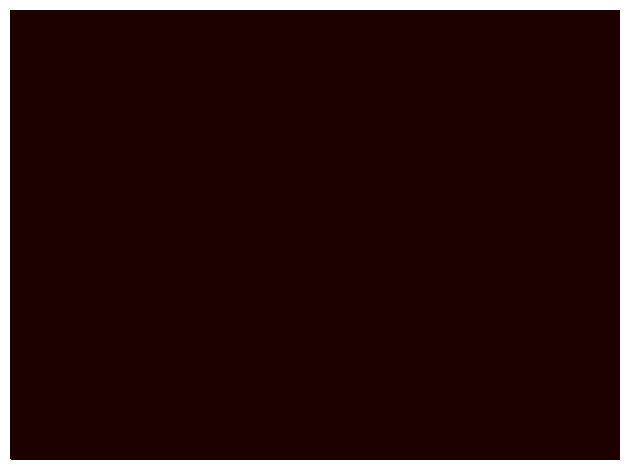

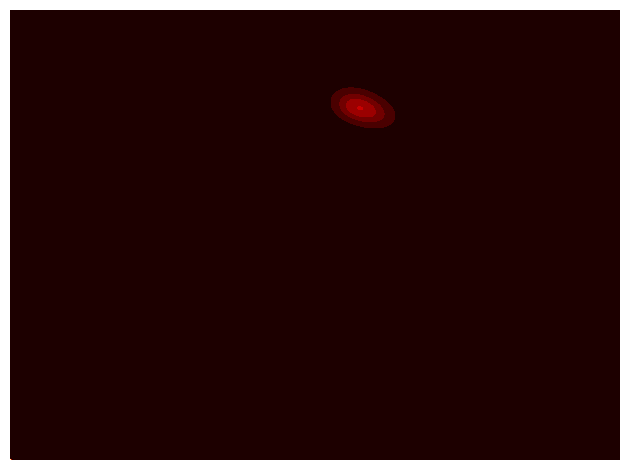

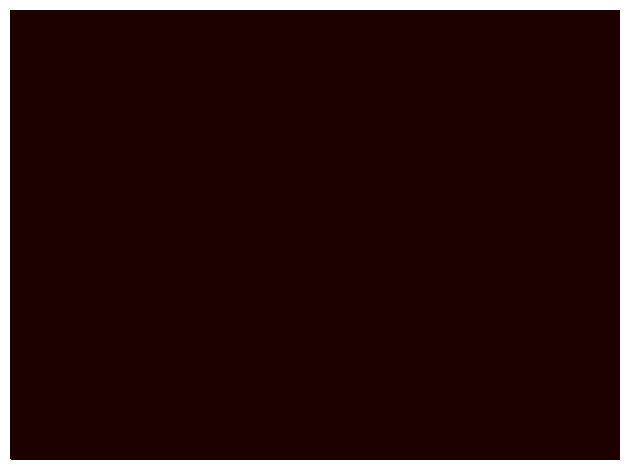

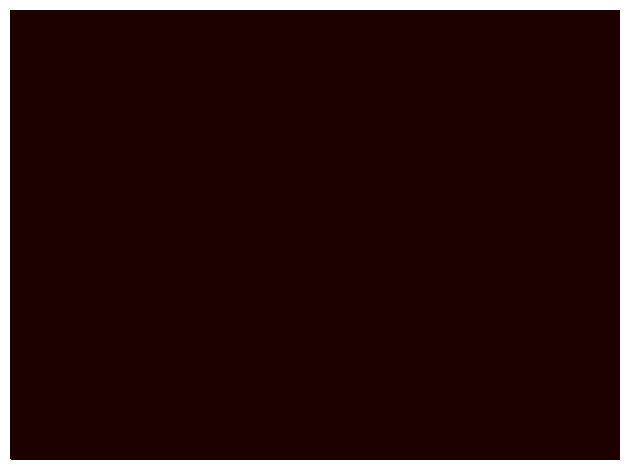

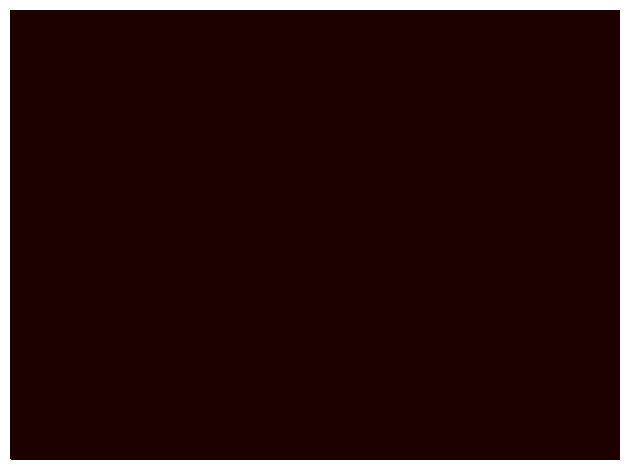

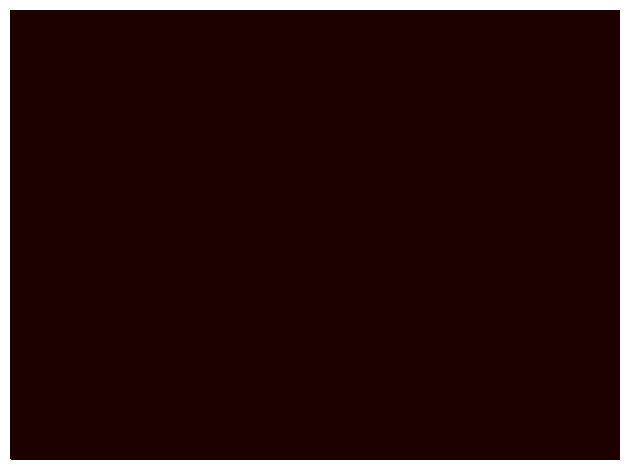

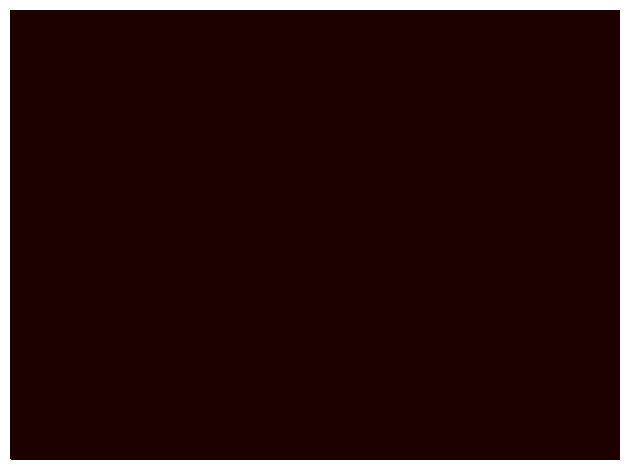

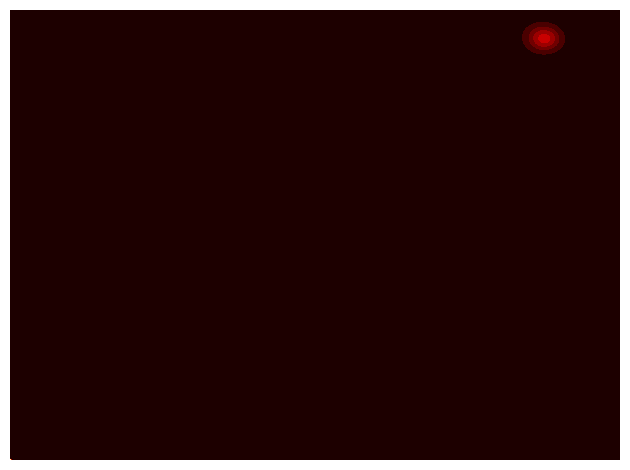

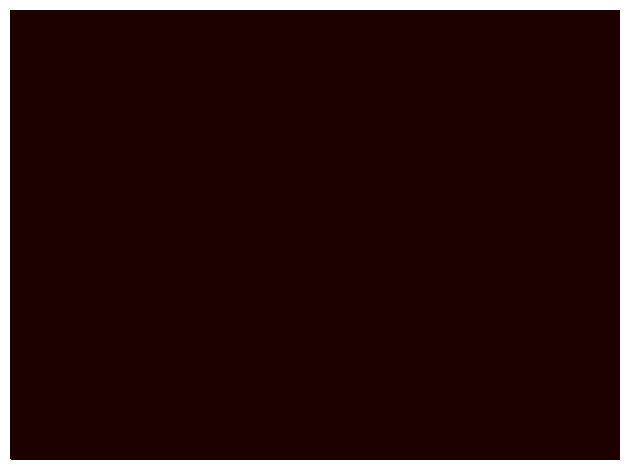

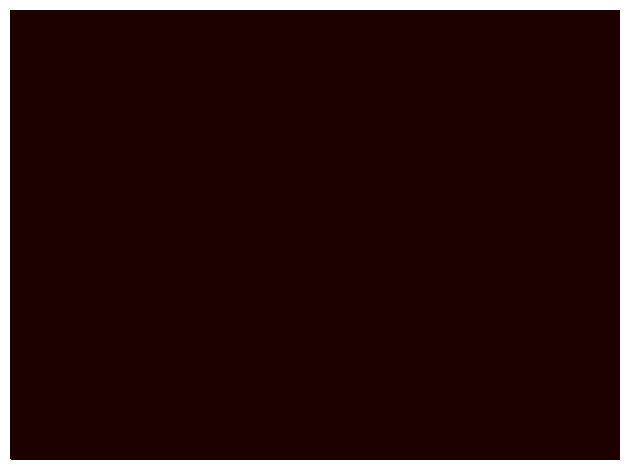

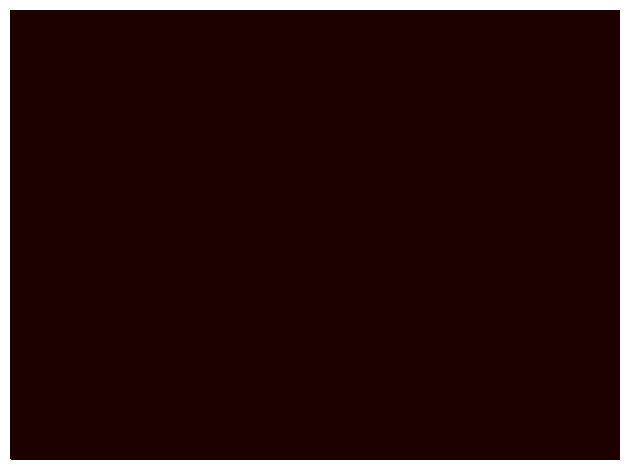

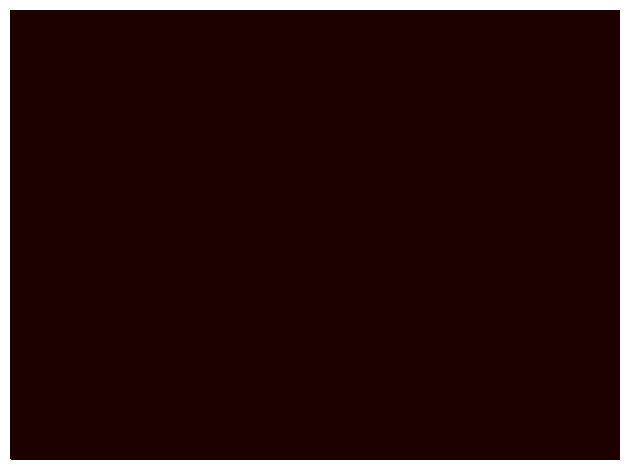

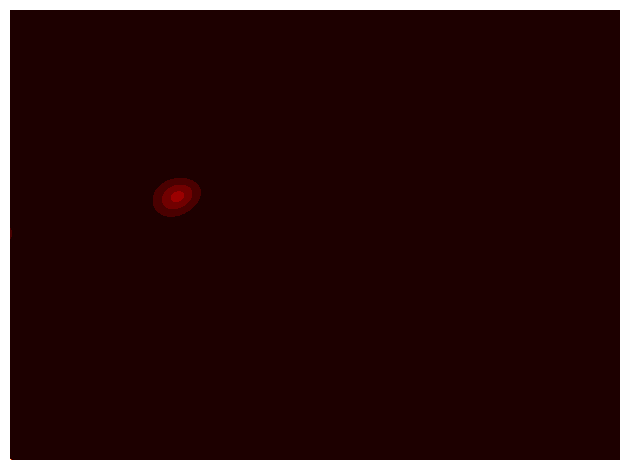

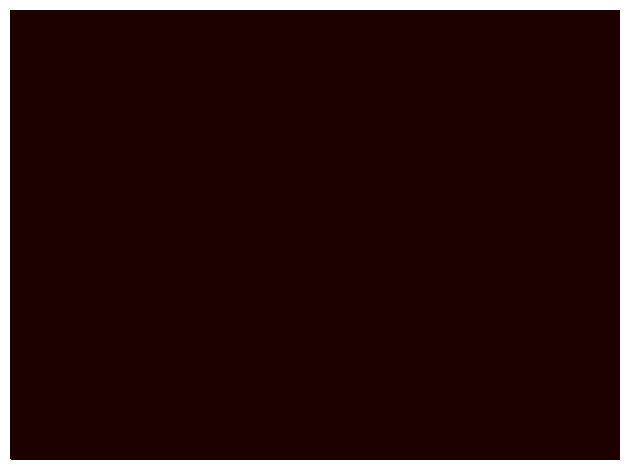

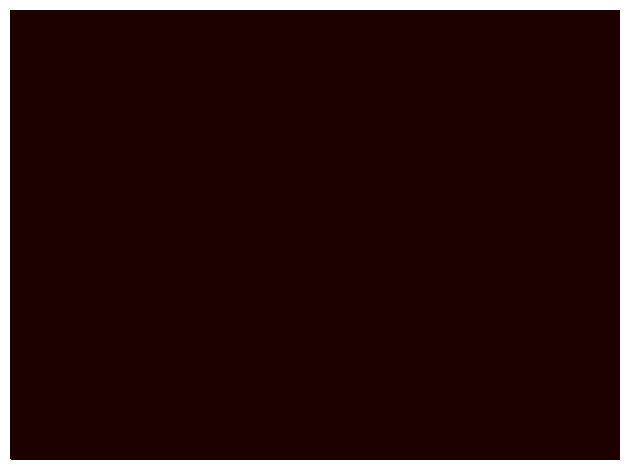

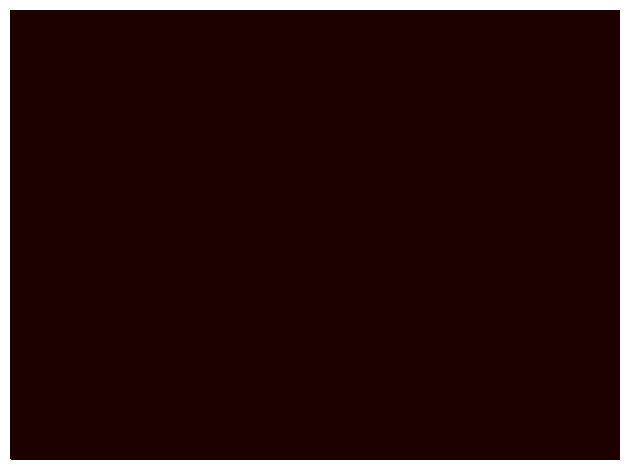

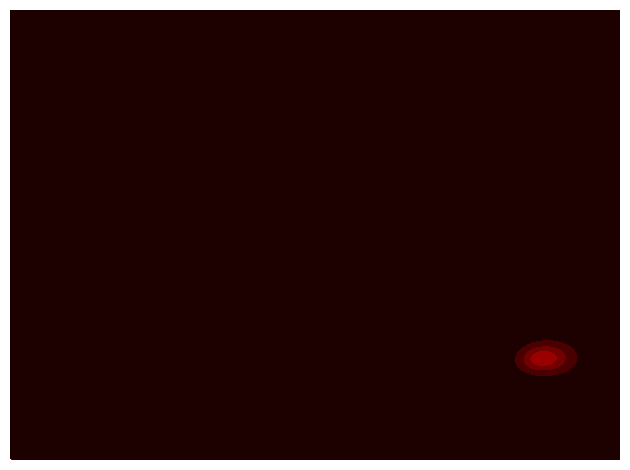

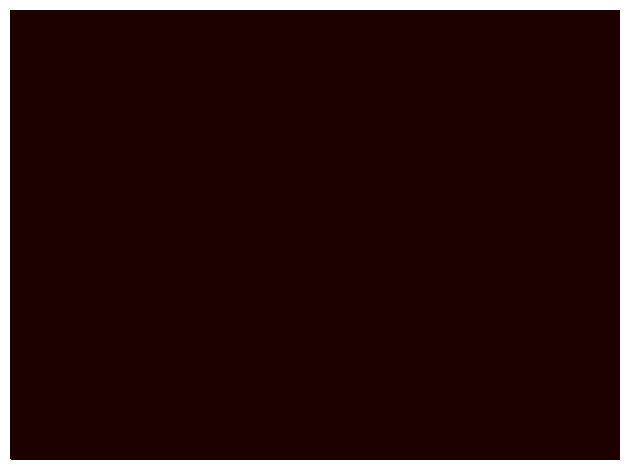

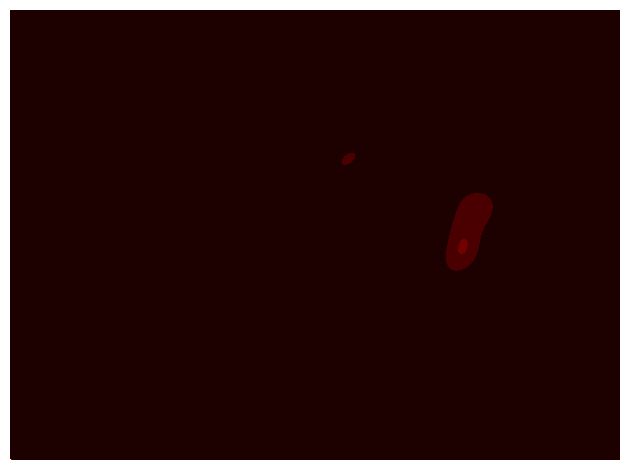

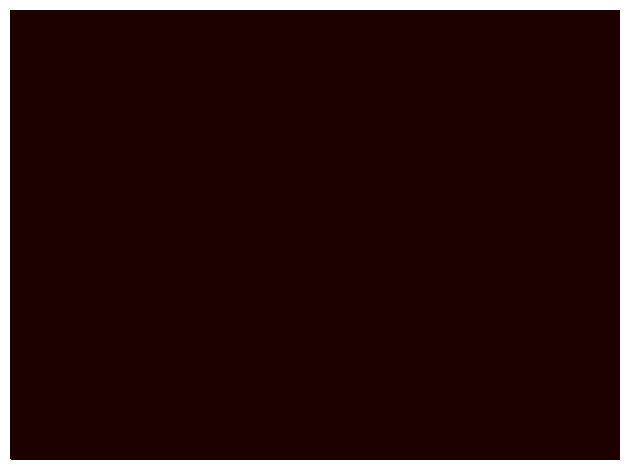

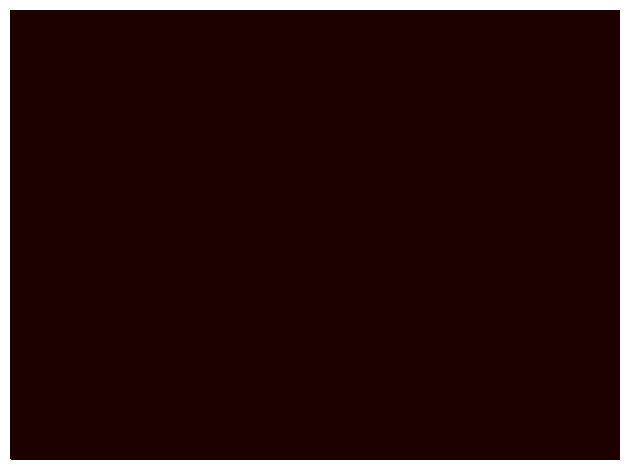

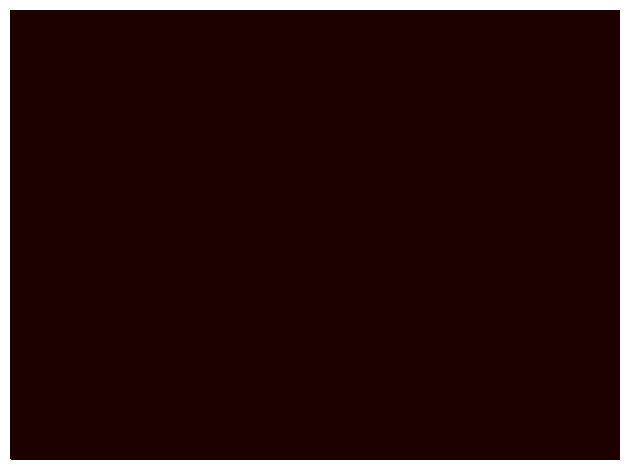

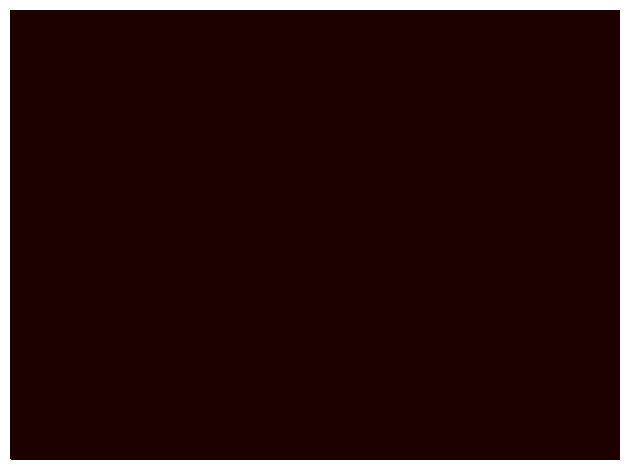

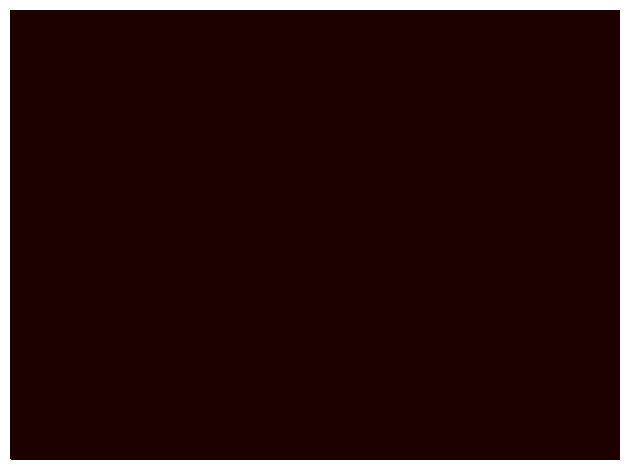

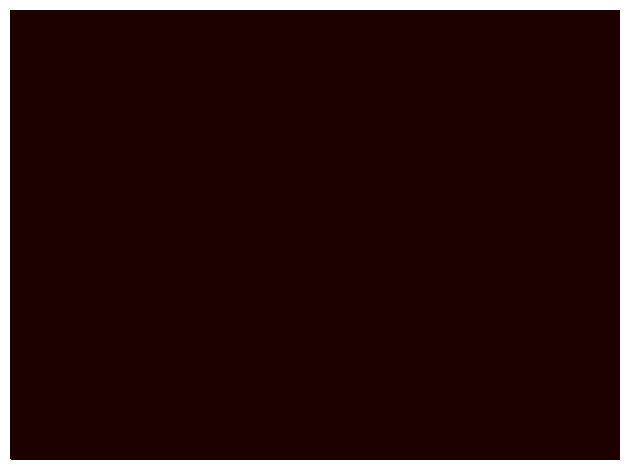

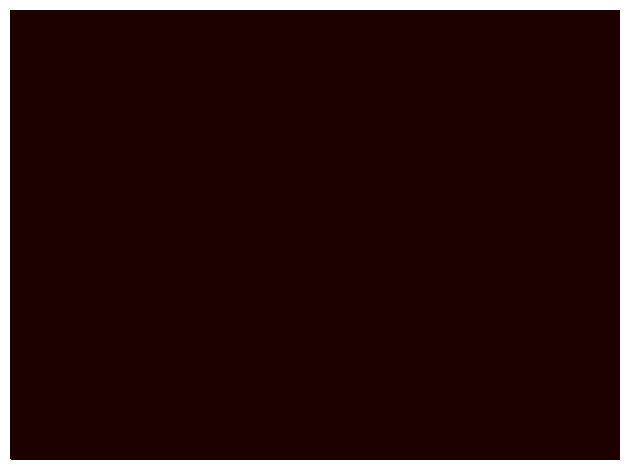

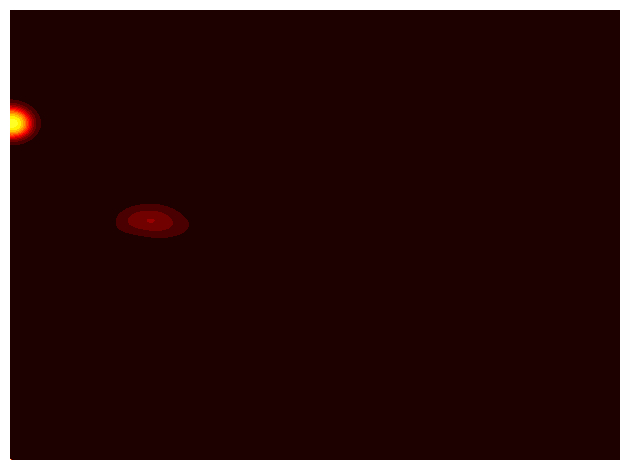

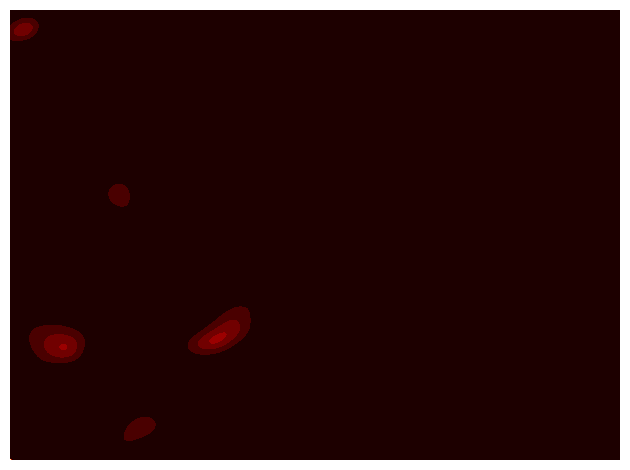

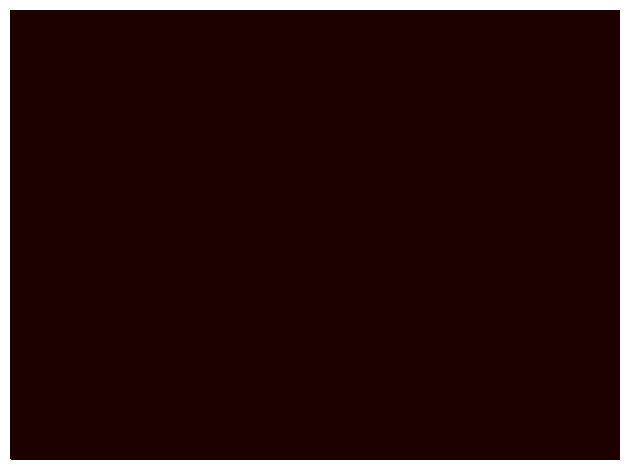

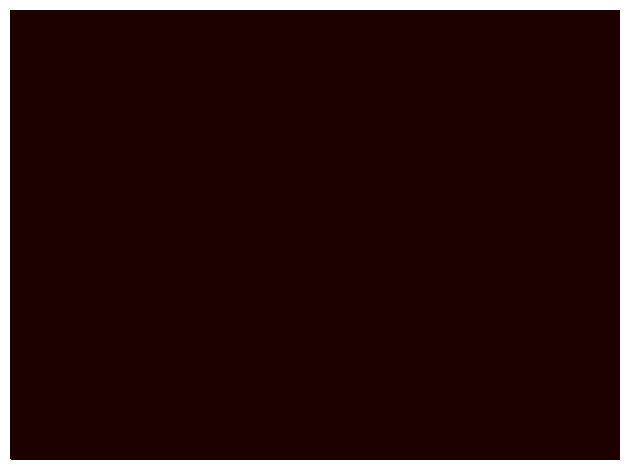

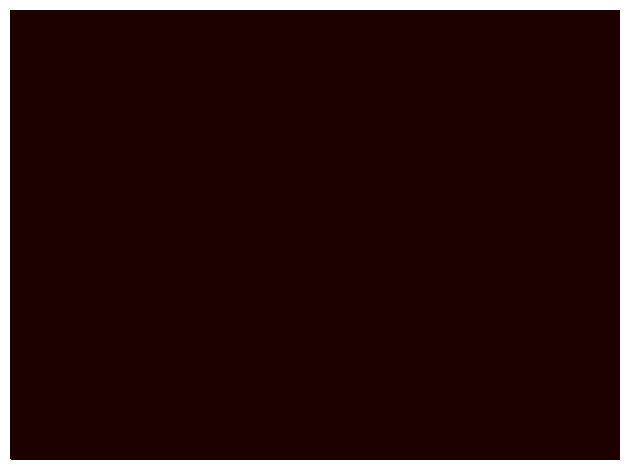

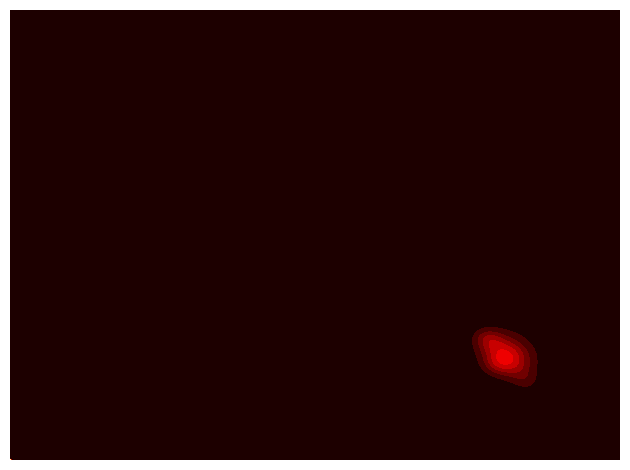

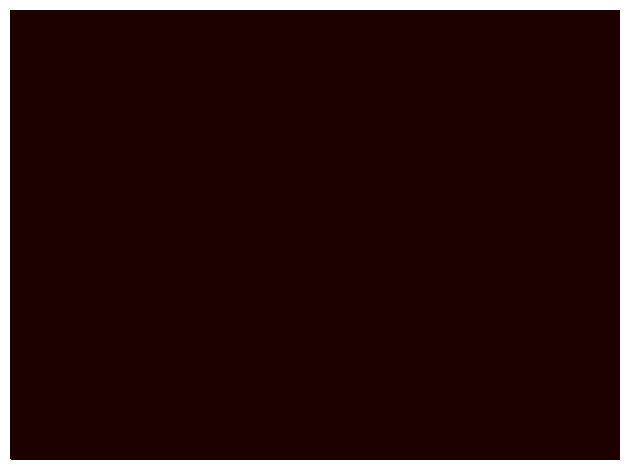

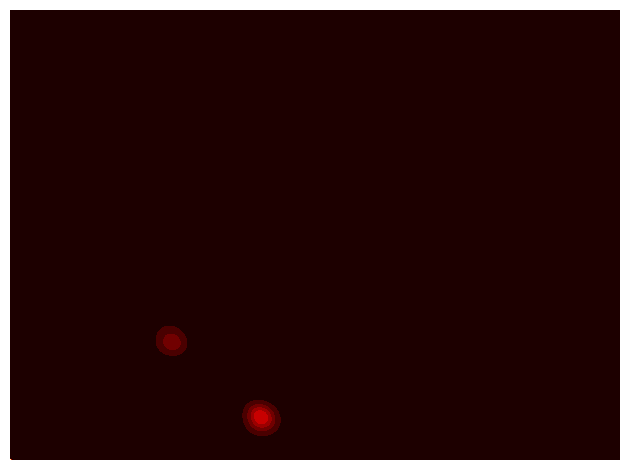

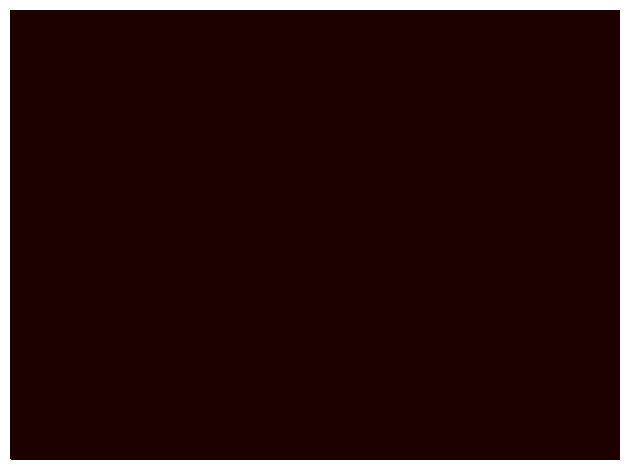

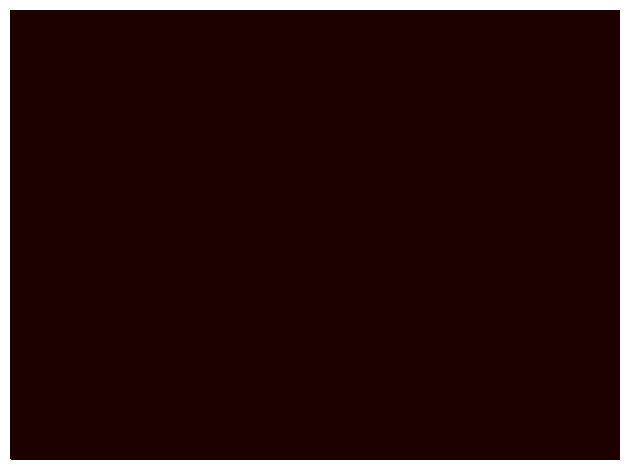

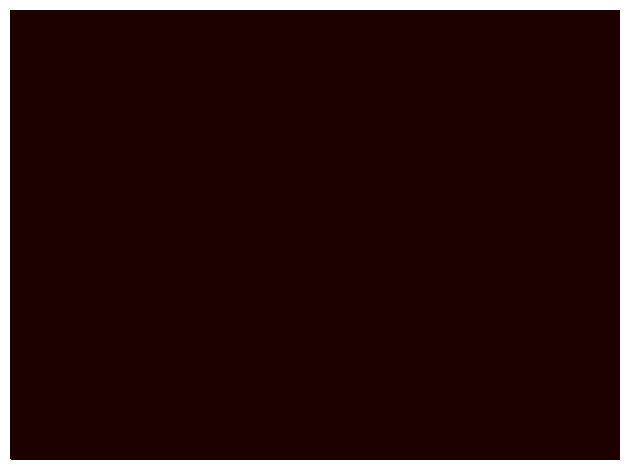

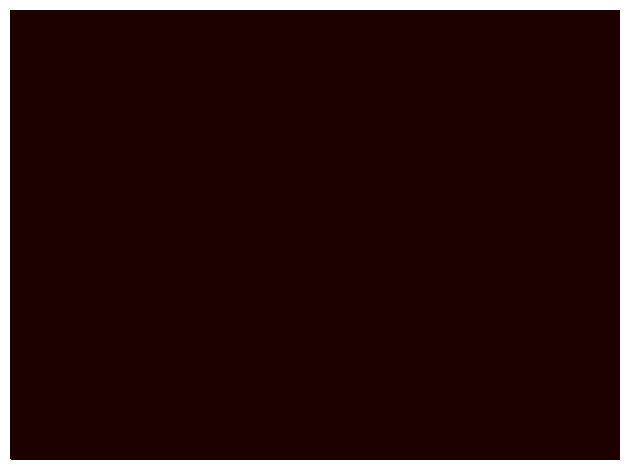

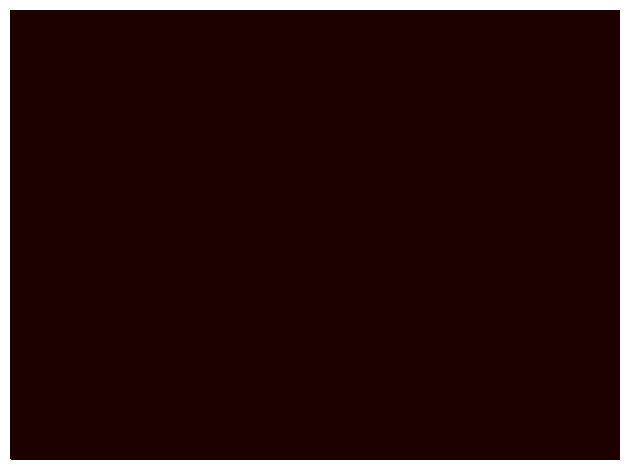

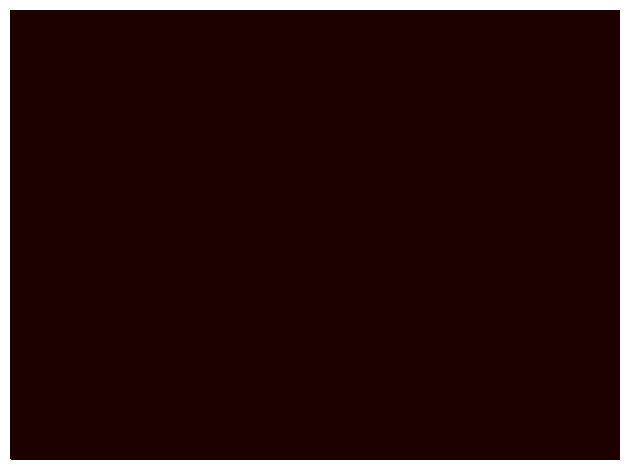

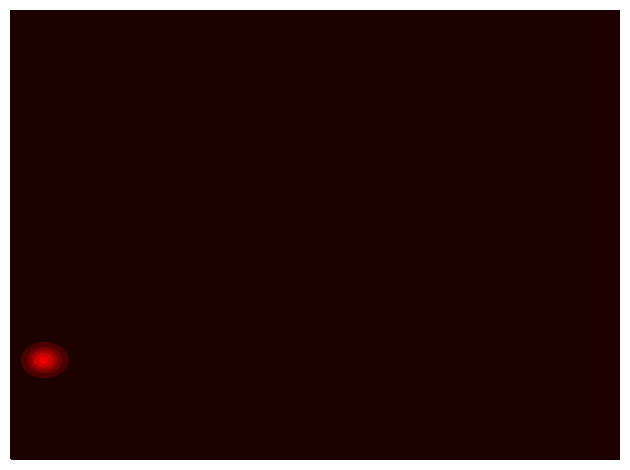

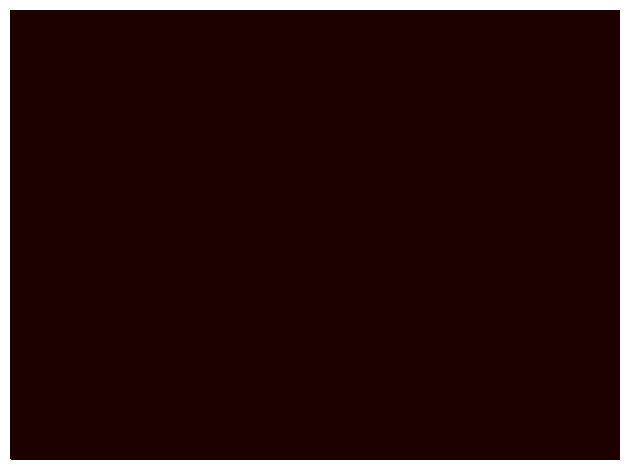

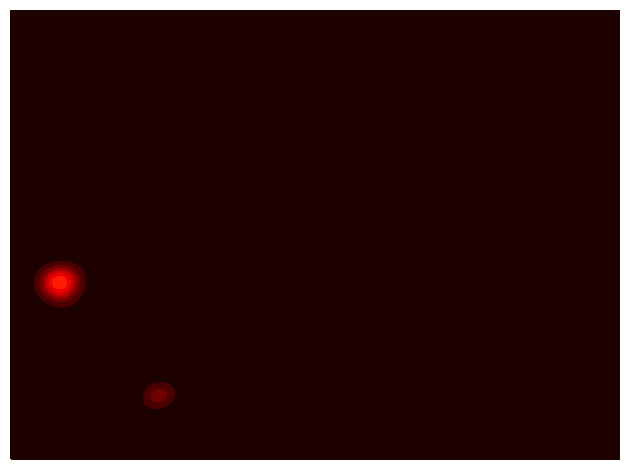

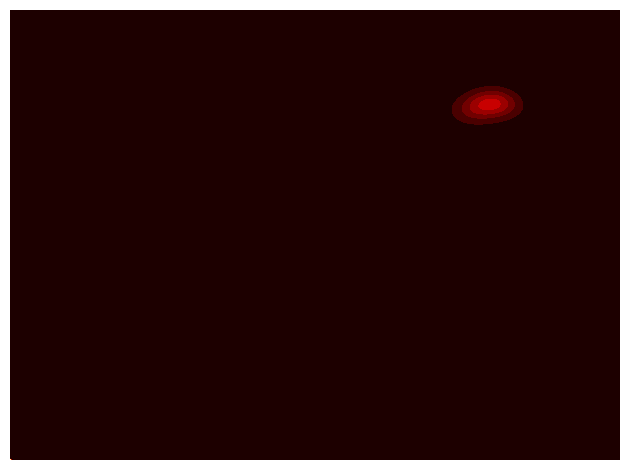

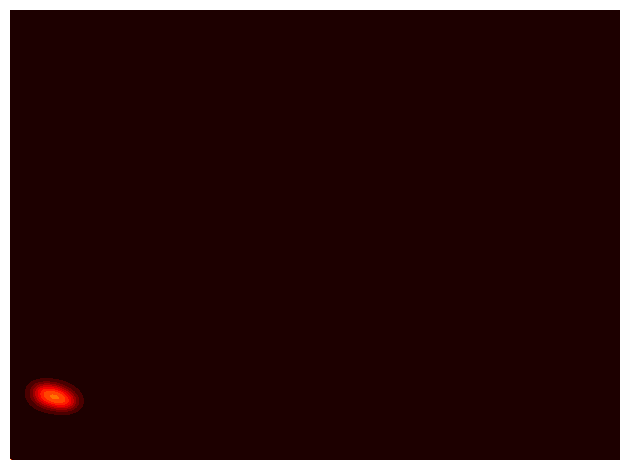

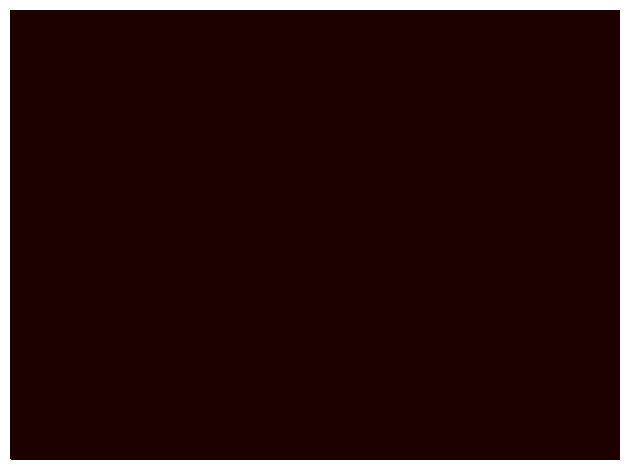

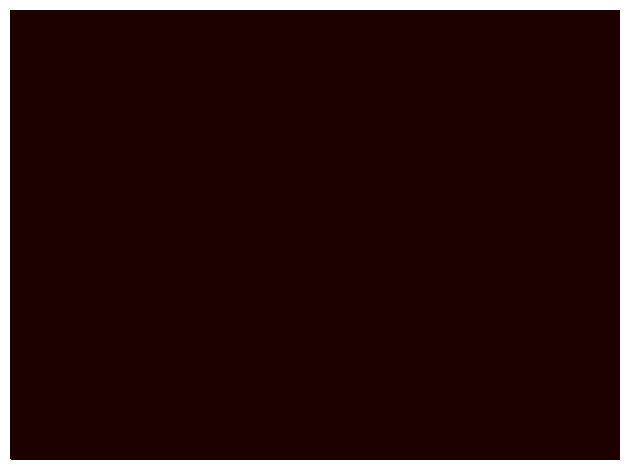

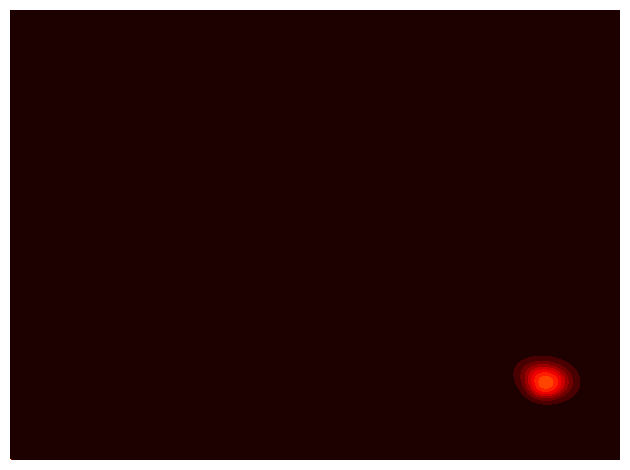

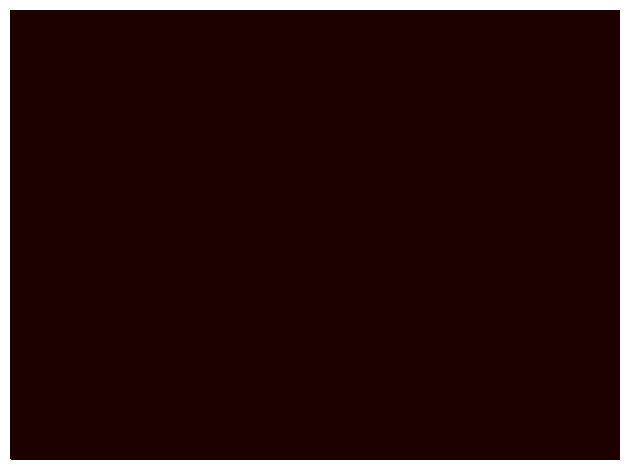

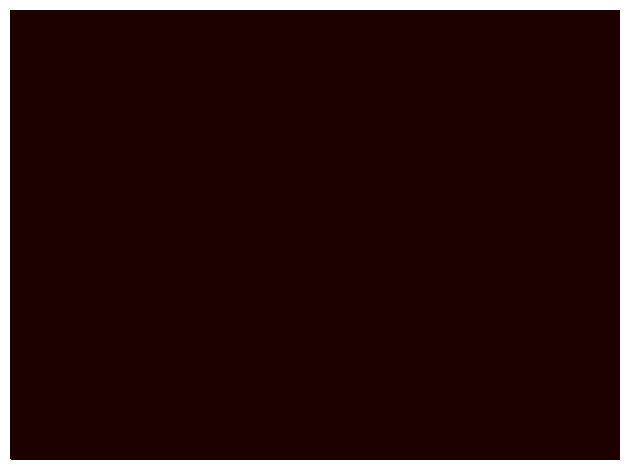

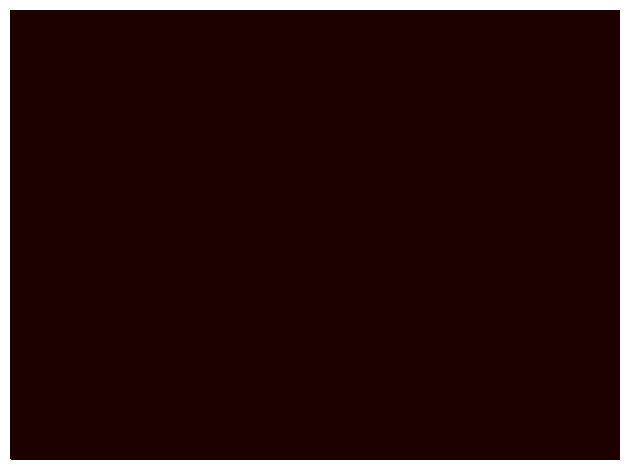

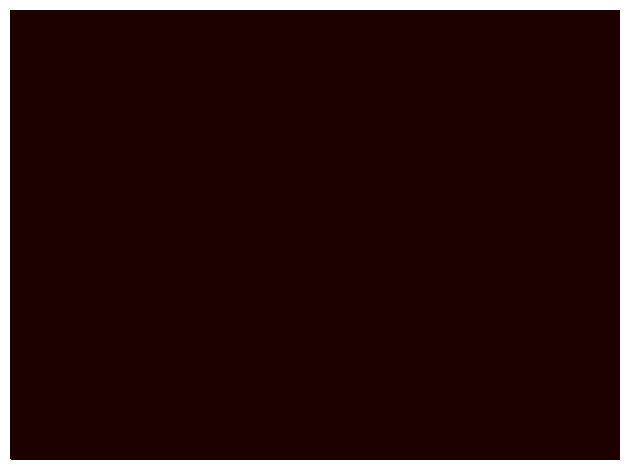

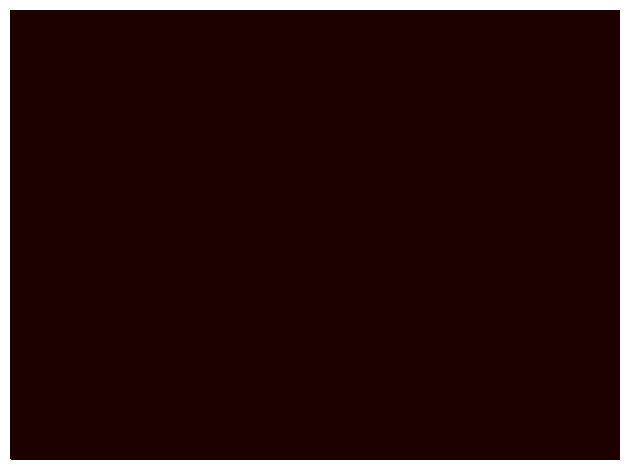

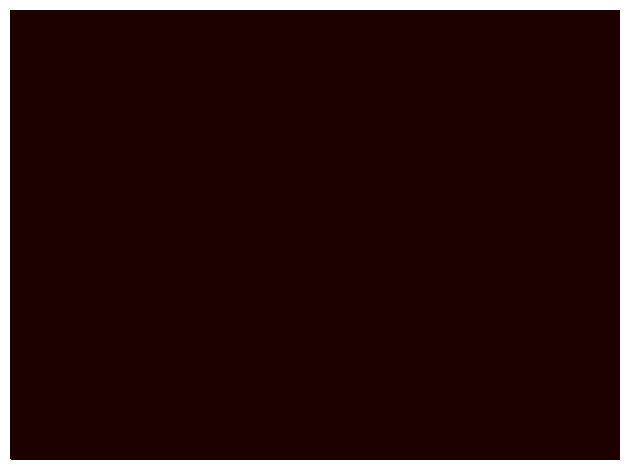

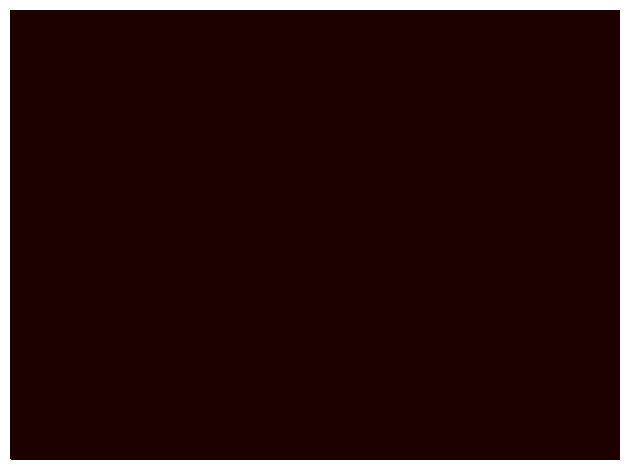

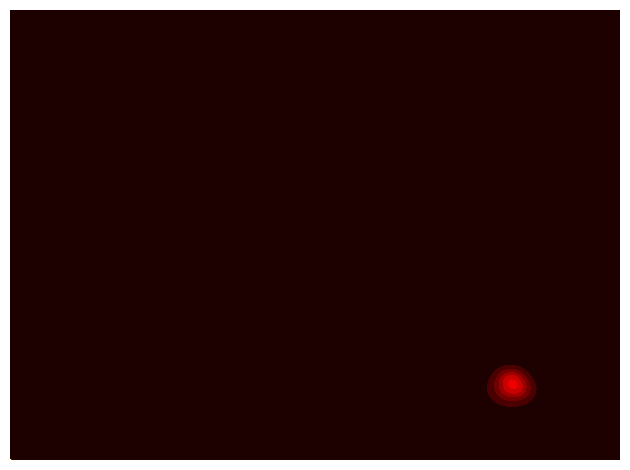

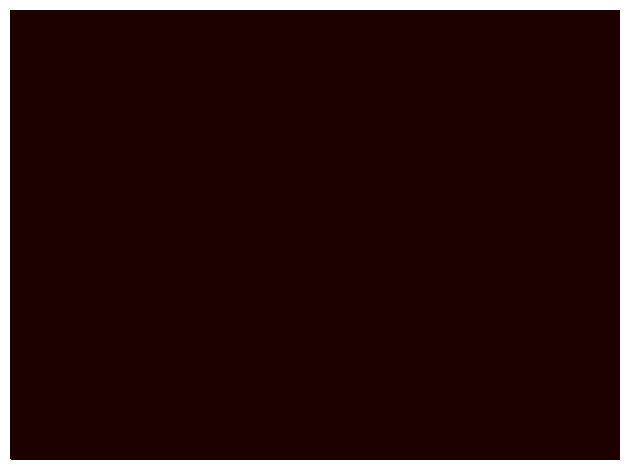

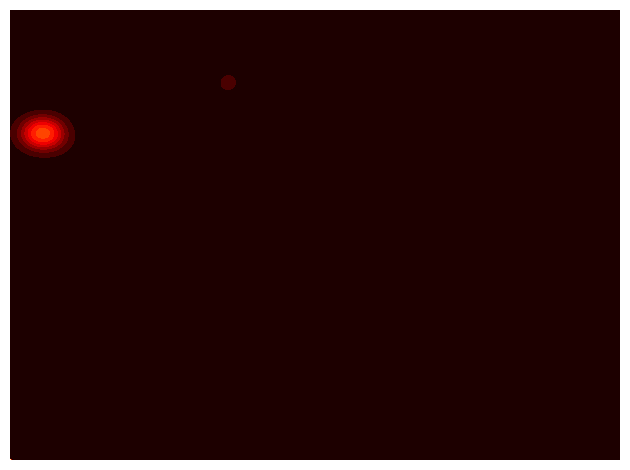

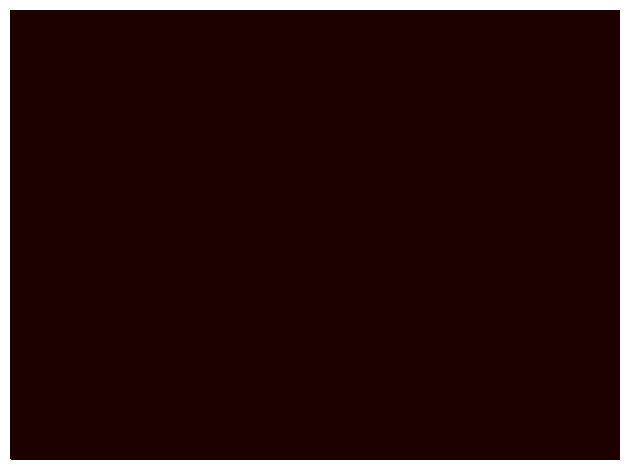

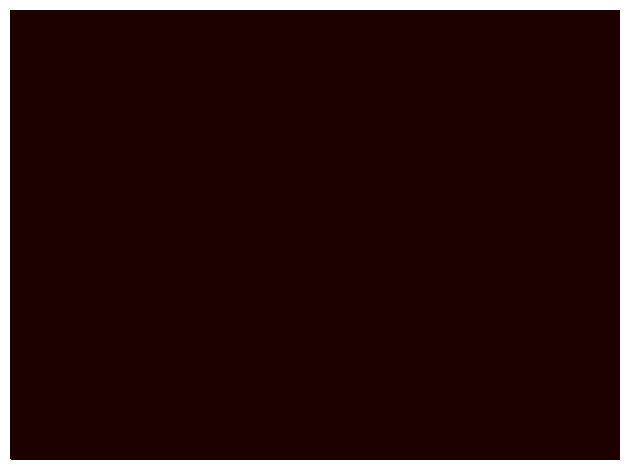

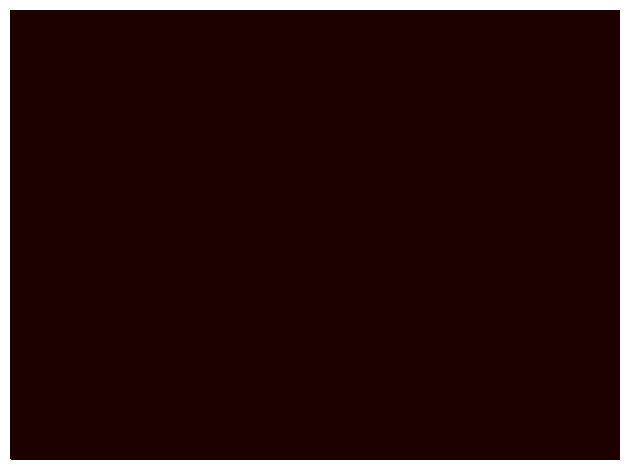

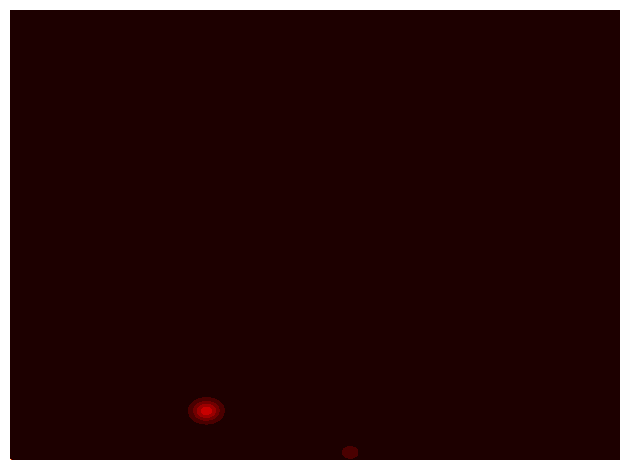

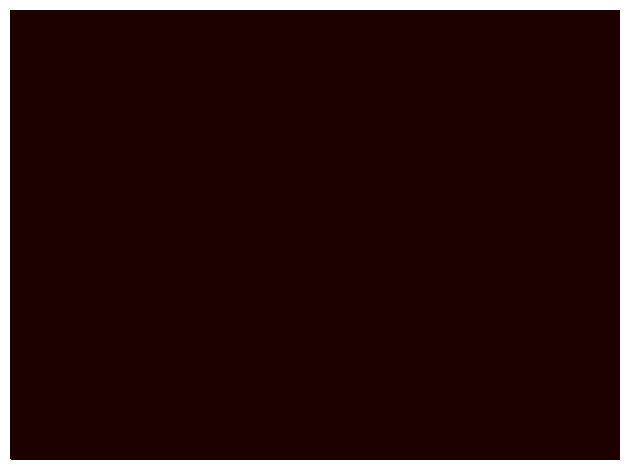

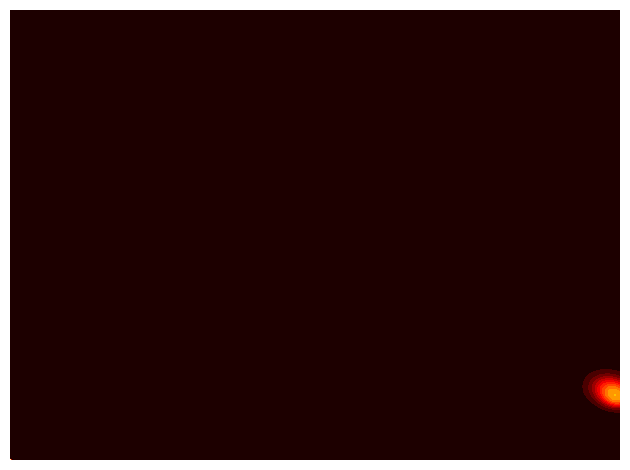

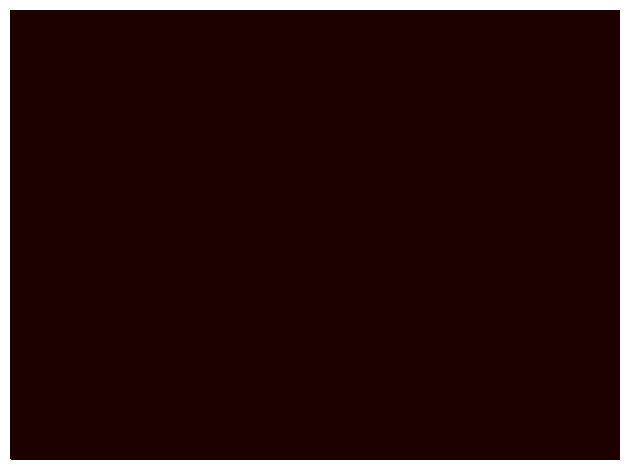

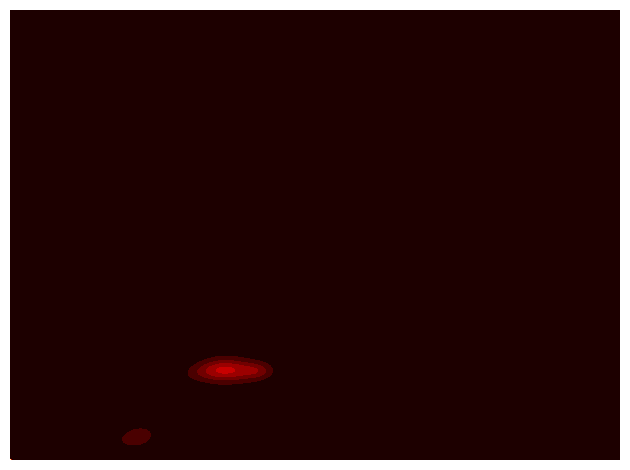

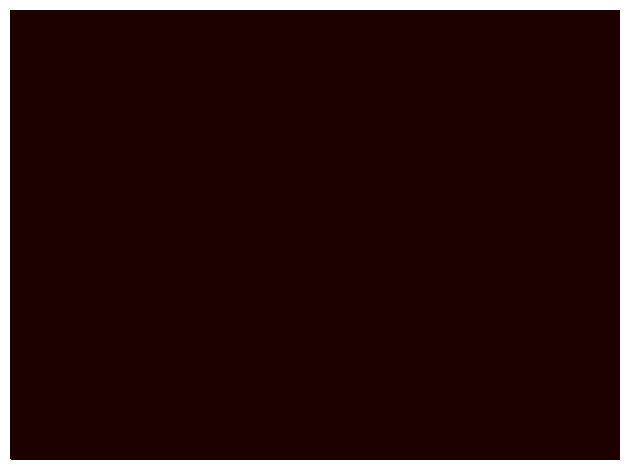

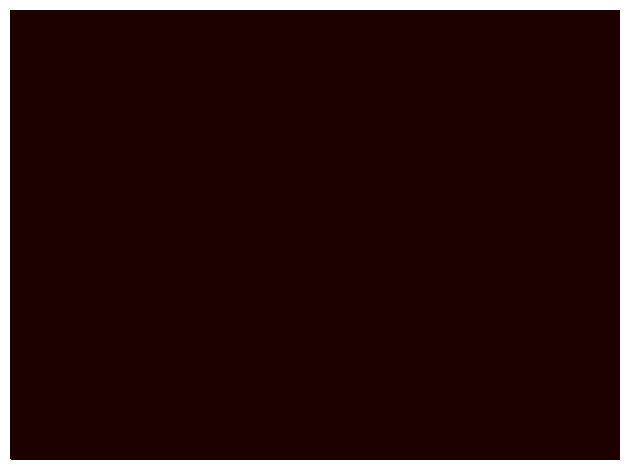

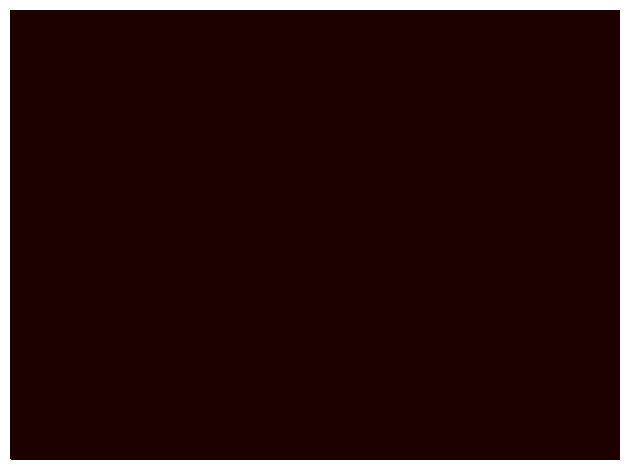

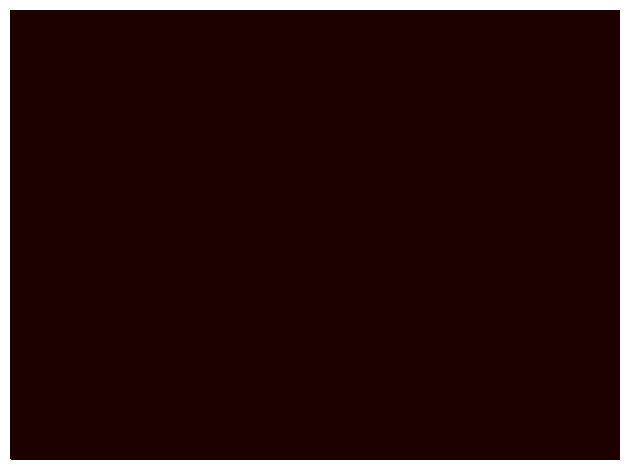

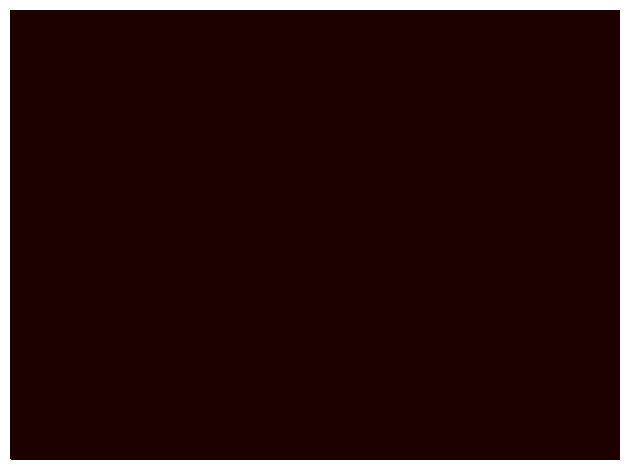

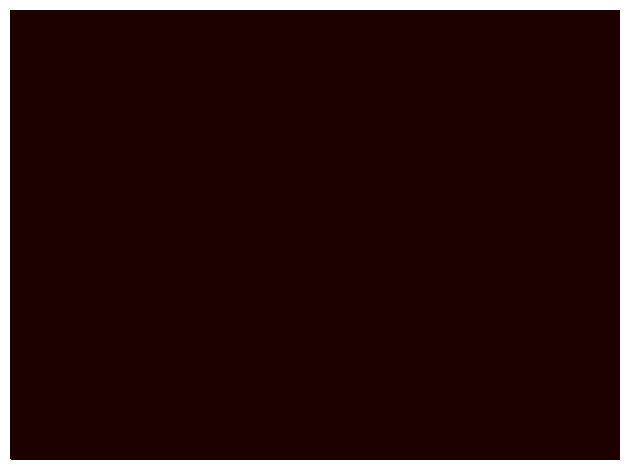

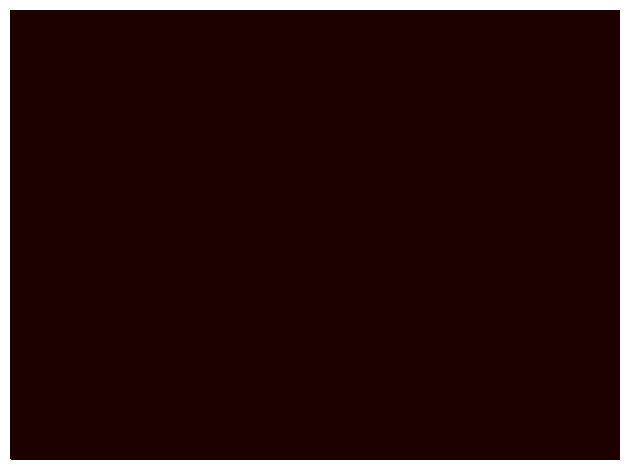

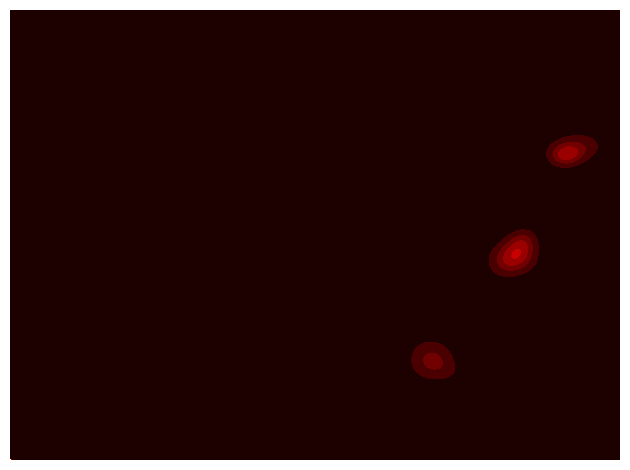

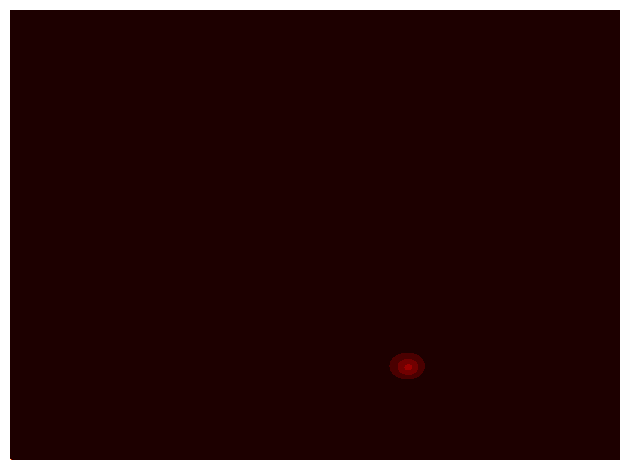

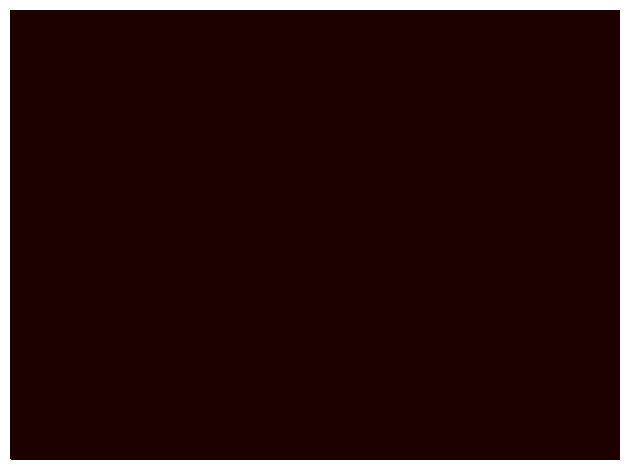

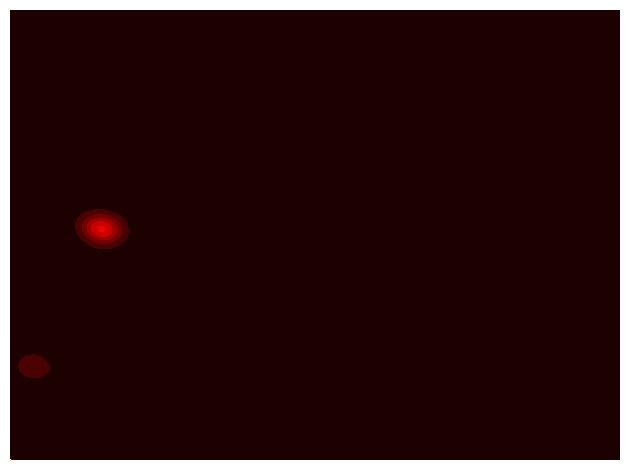

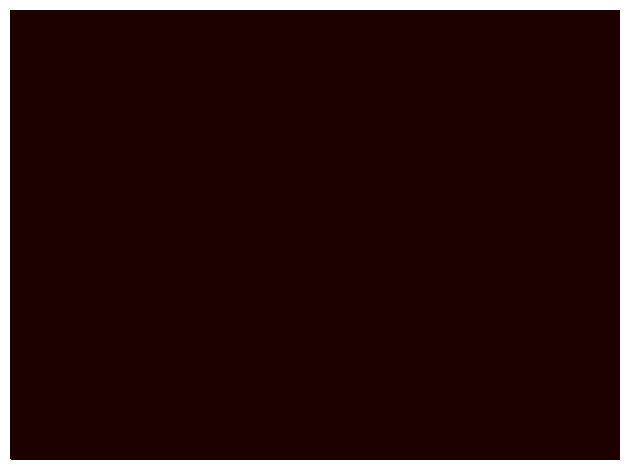

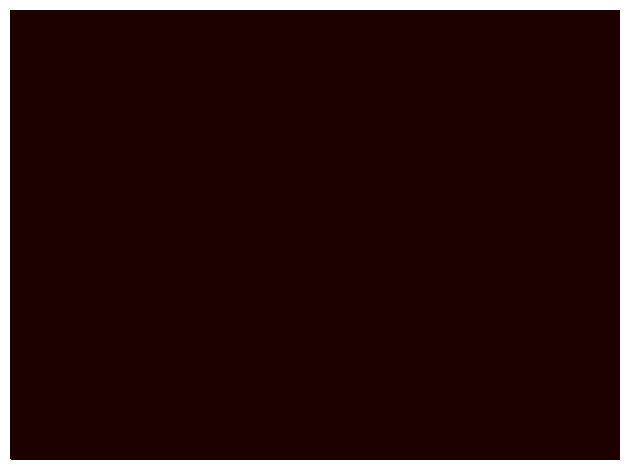

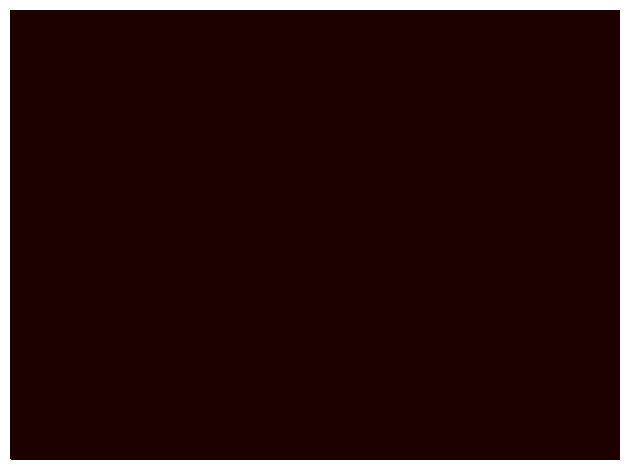

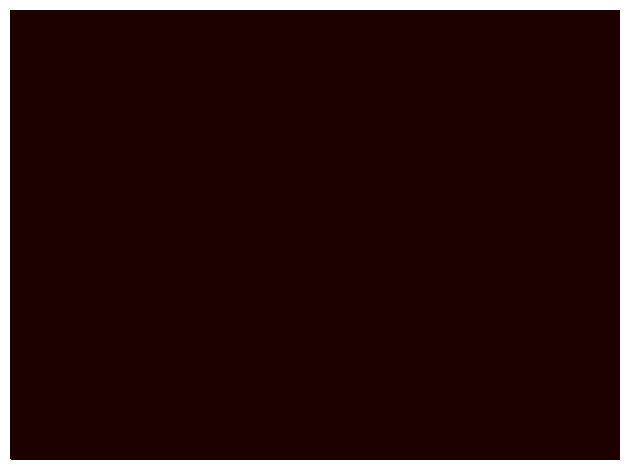

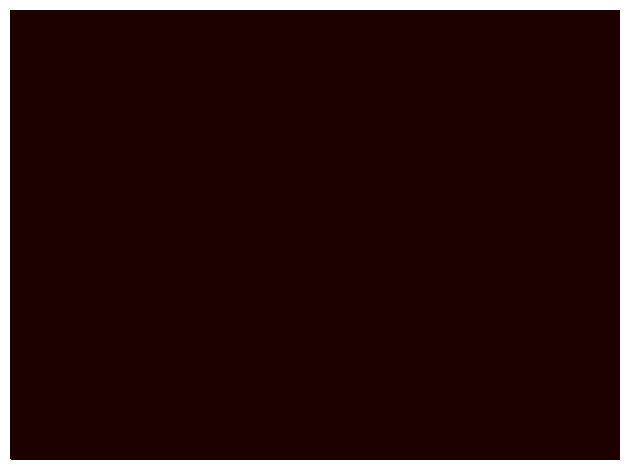

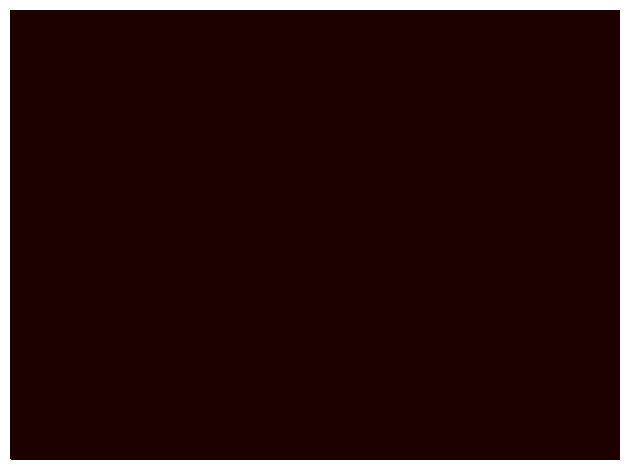

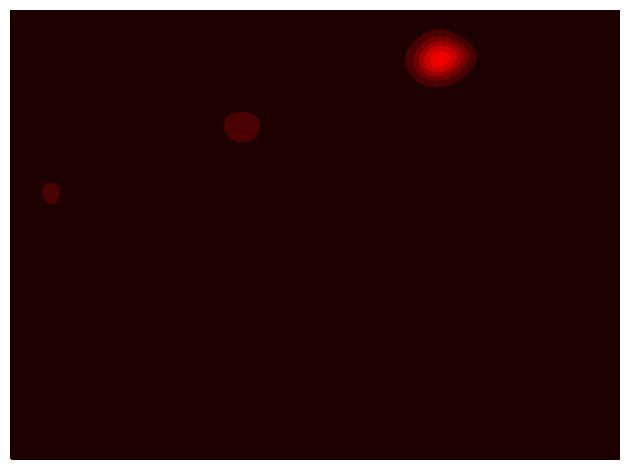

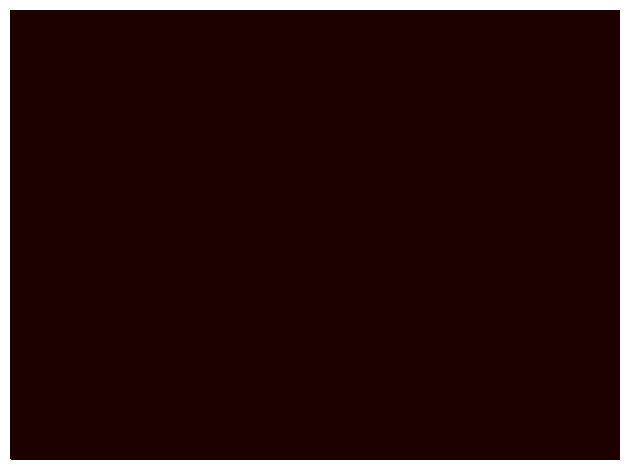

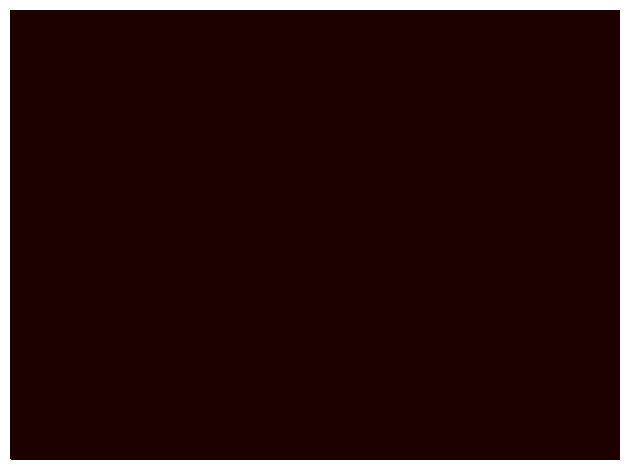

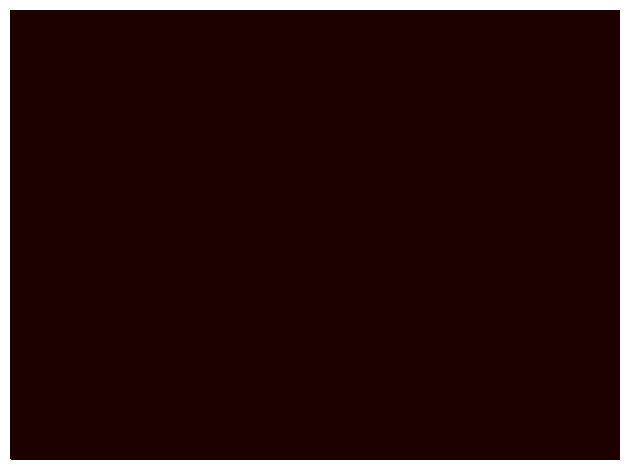

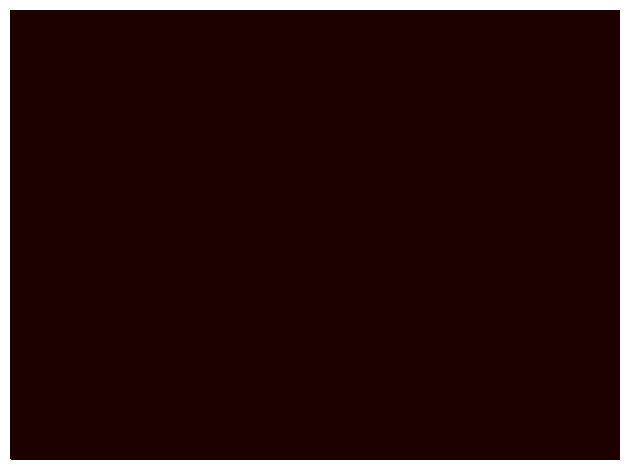

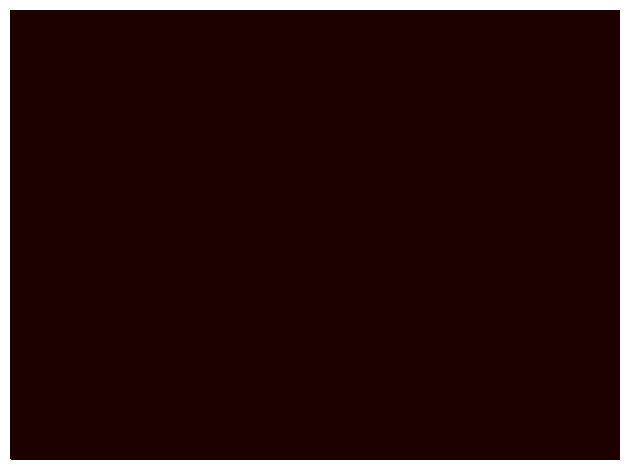

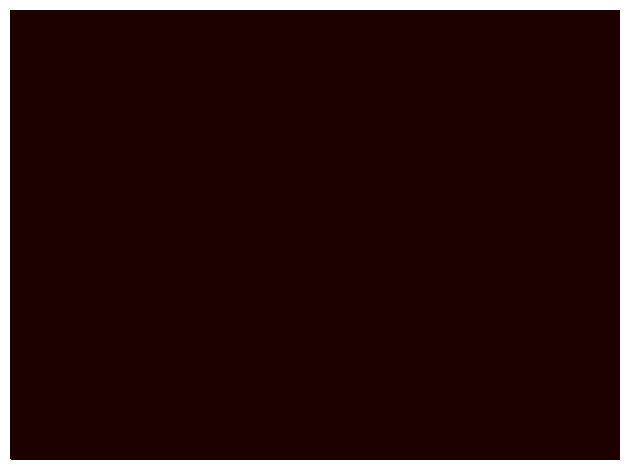

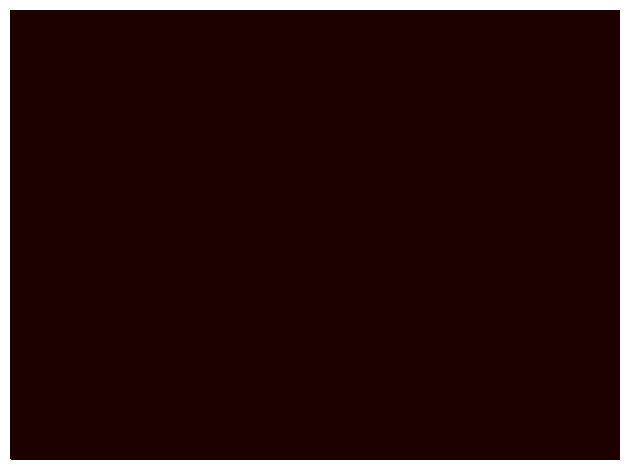

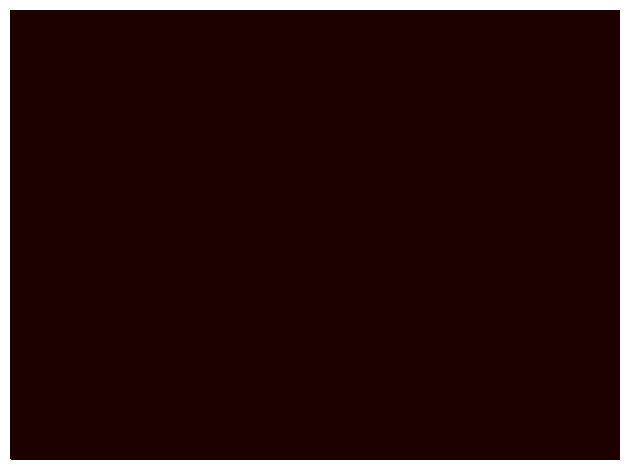

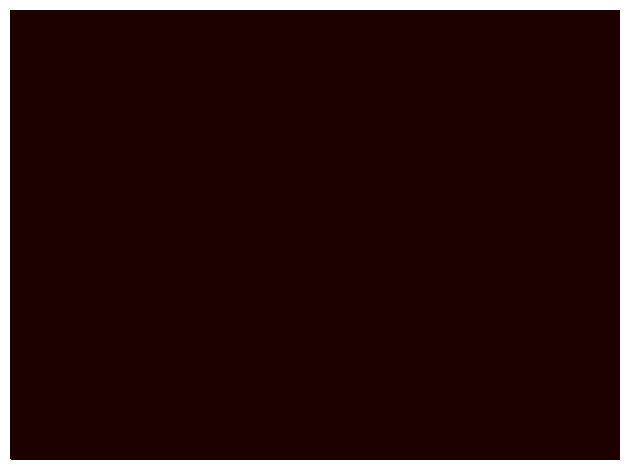

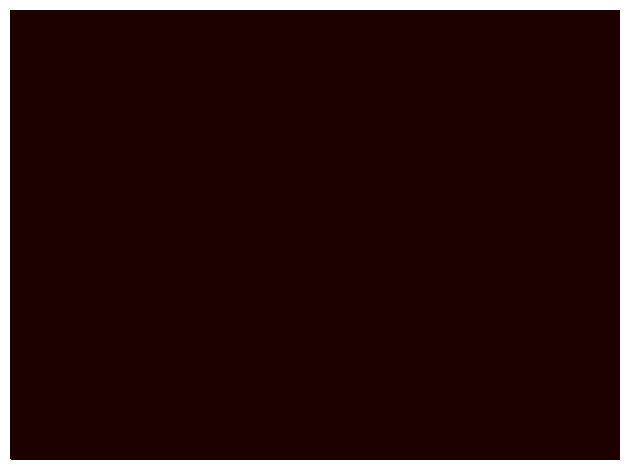

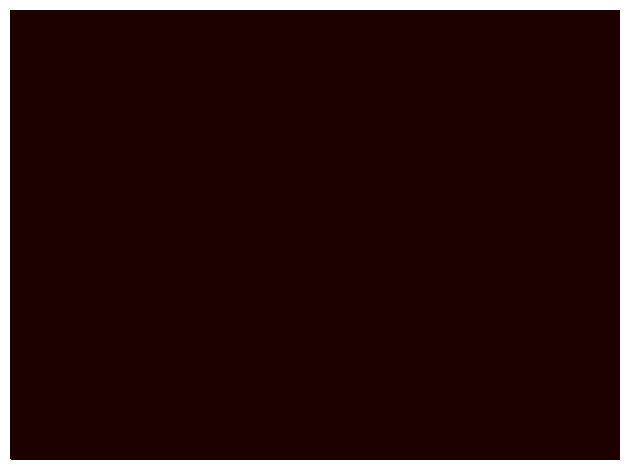

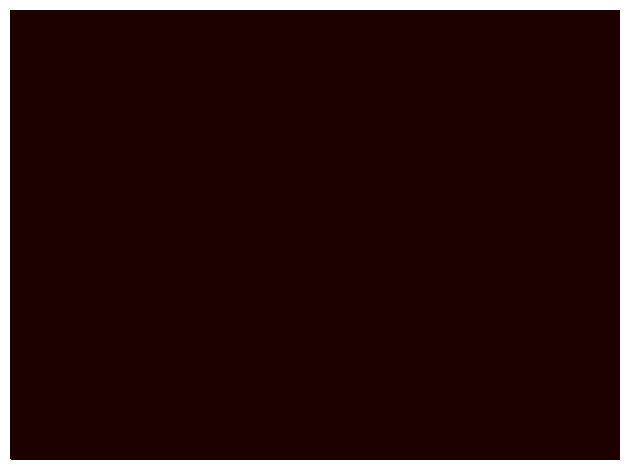

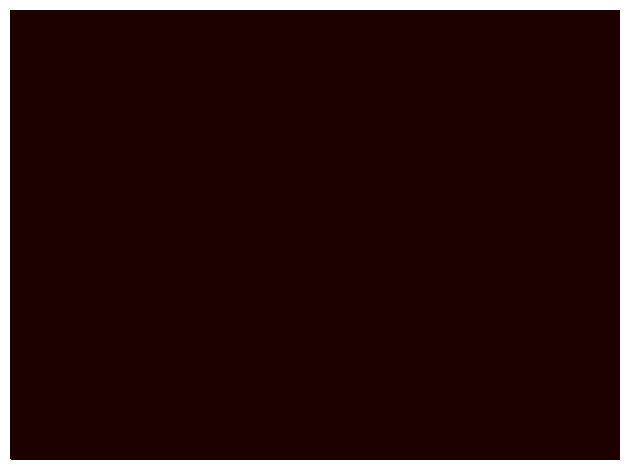

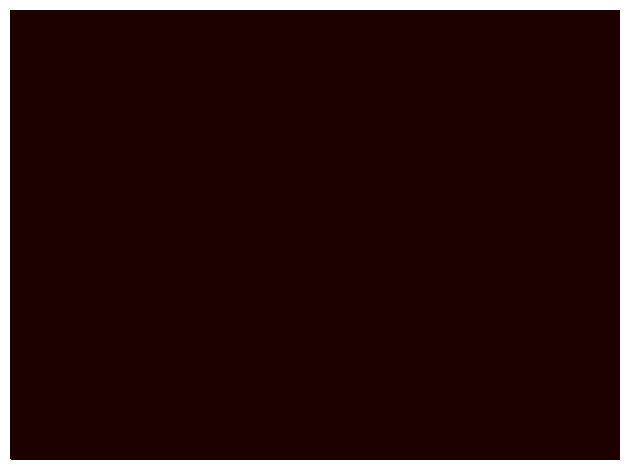

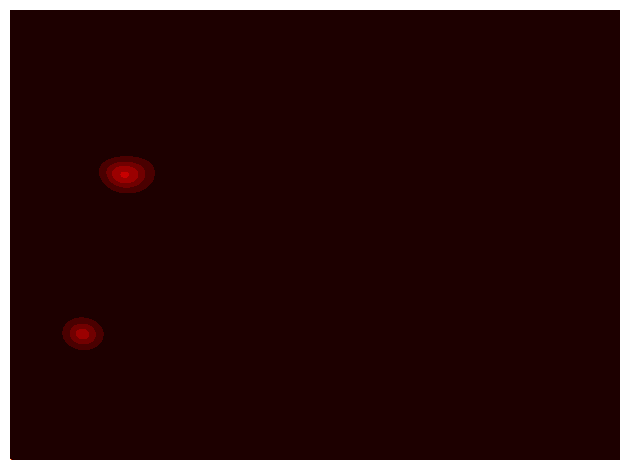

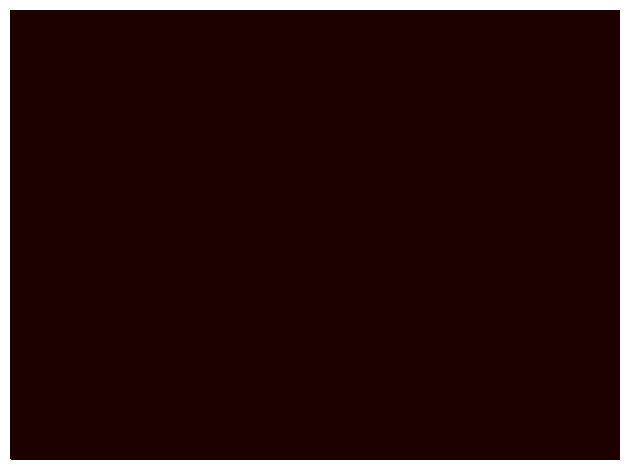

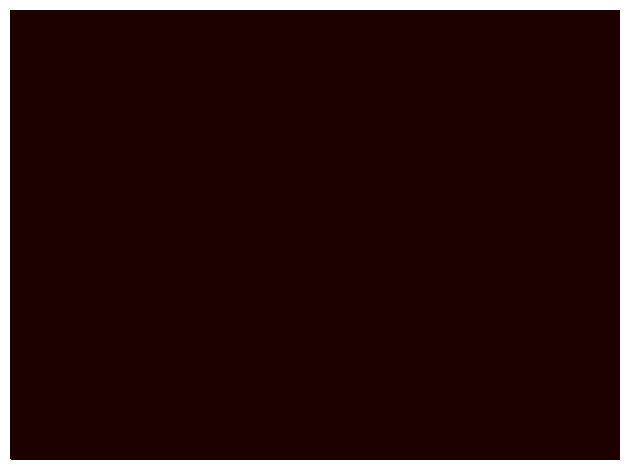

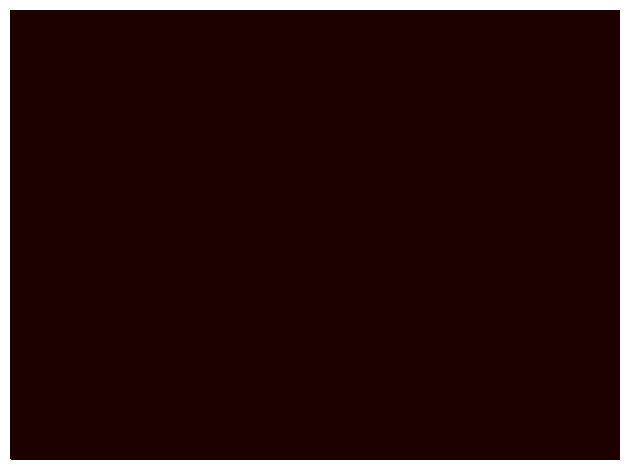

In [18]:
hidden[:,0,0] = hidden.max()

for img in hidden[~used]:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()